In [1]:
import os
import sys
import pandas as pd
import numpy as np
from pathlib import Path
from typing import List, Dict, Union, Tuple, Optional, Any
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def lang_labelblocks(df: pd.DataFrame, indicator_col: str = 'Procedure[Block]') -> pd.DataFrame:
    """
    Label emotion task blocks based on procedure markers.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing E-Prime data
    indicator_col : str, optional
        Column name containing procedure information, by default 'Procedure'
        
    Returns
    -------
    pd.DataFrame
        DataFrame with added 'Block_Label' column
    """
    df = df.copy()  # Avoid modifying the original DataFrame

    # Create a counter for each block type
    block_counters = {'Story': 0, 'Math': 0, 
                      'Dummy': 0, 'Change': 0}
    block_label = None
    block_labels = []

    for procedure in df[indicator_col]:
        # Update block label if a new block starts
        if "StoryProc" in procedure:
            block_counters['Story'] += 1
            block_label = f"Story_Block{block_counters['Story']}"
        elif "MathProc" in procedure:
            block_counters['Math'] += 1
            block_label = f"Math_Block{block_counters['Math']}"
        elif "DummyProc" in procedure:
            block_counters['Dummy'] += 1
            block_label = f"Dummy_Block{block_counters['Dummy']}"
        elif "PresentChangePROC" in procedure:
            block_counters['Change'] += 1
            block_label = f"Change_Block{block_counters['Change']}"

        # Assign current label (will persist across trials)
        block_labels.append(block_label)

    df['Block_Label'] = block_labels
    return df

def language_eprime_preproc(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess E-Prime data from language task for fMRI analysis.
    
    Transforms wide-format data into long-format trial data with onset, duration, and trial type.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing E-Prime data in wide format
        
    Returns
    -------
    pd.DataFrame
        Long-format DataFrame with onset, duration, and trial type information
    """
    df_relab = lang_labelblocks(df)

    long_format = []
    
    for _, row in df_relab.iterrows():
        adjust_by_trigger = row['GetReady.OffsetTime']
        
        # Story trials
        if 'Story' in row['Procedure[Block]']:
            # Present story event
            long_format.append({
                'onset': row['PresentStoryFile.OnsetTime'] - adjust_by_trigger,
                'duration': (row['PresentStoryFile.FinishTime'] - row['PresentStoryFile.OnsetTime']),
                'trial_type': 'present_story',
                'block': row['Block_Label'],
                'response_time': np.nan,
                'accuracy': np.nan,
                'response': np.nan
            })

            # Story to question transition period
            long_format.append({
                'onset': row['PresentStoryFile.OnsetTime'] - adjust_by_trigger,
                'duration': (row['ThatWasAbout.OnsetTime'] - row['PresentStoryFile.OnsetTime']),
                'trial_type': 'story_to_question',
                'block': row['Block_Label'],
                'response_time': np.nan,
                'accuracy': np.nan,
                'response': np.nan            
            })

            # Full story period (including response)
            long_format.append({
                'onset': row['PresentStoryFile.OnsetTime'] - adjust_by_trigger,
                'duration': (row['ResponsePeriod.FinishTime'] - row['PresentStoryFile.OnsetTime']),
                'trial_type': 'full_story',
                'block': row['Block_Label'],
                'response_time': np.nan,
                'accuracy': np.nan,
                'response': np.nan
            })
            
            # "That was about" question prompt
            long_format.append({
                'onset': row['ThatWasAbout.OnsetTime'] - adjust_by_trigger,
                'duration': (row['ThatWasAbout.FinishTime'] - row['ThatWasAbout.OnsetTime']),
                'trial_type': 'question_story',
                'block': row['Block_Label'],
                'response_time': np.nan,
                'accuracy': np.nan,
                'response': np.nan
            })
            
            # Story option 1
            long_format.append({
                'onset': row['PresentStoryOption1.OnsetTime'] - adjust_by_trigger,
                'duration': (row['PresentStoryOption1.FinishTime'] - row['PresentStoryOption1.OnsetTime']),
                'trial_type': 'story_opt1',
                'block': row['Block_Label'],
                'word_opt': row['Option1'],
                'response_time': row.get('PresentStoryOption1.RT', np.nan),
                'accuracy': row.get('PresentStoryOption1.ACC', np.nan),
                'response': row.get('PresentStoryOption1.RESP', np.nan),
                'overall_acc': row.get('OverallAcc[Trial]', np.nan)
            })
            
            # Story option 2
            long_format.append({
                'onset': row['PresentStoryOption2.OnsetTime'] - adjust_by_trigger,
                'duration': (row['PresentStoryOption2.FinishTime'] - row['PresentStoryOption2.OnsetTime']),
                'trial_type': 'story_opt2',
                'word_opt': row['Option2'],
                'block': row['Block_Label'],
                'response_time': row.get('PresentStoryOption2.RT', np.nan),
                'accuracy': row.get('PresentStoryOption2.ACC', np.nan),
                'response': row.get('PresentStoryOption2.RESP', np.nan),
                'overall_acc': row.get('OverallAcc[Trial]', np.nan)
            })
            
            # Response period
            long_format.append({
                'onset': row['ResponsePeriod.OnsetTime'] - adjust_by_trigger,
                'duration': (row['ResponsePeriod.FinishTime'] - row['ResponsePeriod.OnsetTime']),
                'trial_type': 'story_answer',
                'block': row['Block_Label'],
                'response_time': row.get('ResponsePeriod.RT', np.nan),
                'accuracy': row.get('ResponsePeriod.ACC', np.nan),
                'response': row.get('ResponsePeriod.RESP', np.nan),
                'math_lvl': np.nan,
                'overall_acc': row.get('OverallAcc[Trial]', np.nan)
            })
            
        # Math trials
        elif 'Math' in row['Procedure[Block]']:
            # Present math file
            long_format.append({
                'onset': row['PresentMathFile.OnsetTime'] - adjust_by_trigger,
                'duration': (row['PresentMathFile.FinishTime'] - row['PresentMathFile.OnsetTime']),
                'trial_type': 'present_math',
                'block': row['Block_Label']
            })
            
            # Full math period (including response)
            long_format.append({
                'onset': row['PresentMathFile.OnsetTime'] - adjust_by_trigger,
                'duration': (row['ResponsePeriod.FinishTime'] - row['PresentMathFile.OnsetTime']),
                'trial_type': 'full_math',
                'block': row['Block_Label']
            })
            
            long_format.append({
                'onset': row['PresentMathFile.OnsetTime'] - adjust_by_trigger,
                'duration': (row['PresentMathOptions.OnsetTime'] - row['PresentMathFile.OnsetTime']),
                'trial_type': 'math_to_question',
                'block': row['Block_Label']       
            })
            
            # Math options presentation
            long_format.append({
                'onset': row['PresentMathOptions.OnsetTime'] - adjust_by_trigger,
                'duration': (row['PresentMathOptions.FinishTime'] - row['PresentMathOptions.OnsetTime']),
                'trial_type': 'question_math',
                'block': row['Block_Label'],
                'math_lvl': row.get('CurrentMathLevel[Trial]', np.nan)
            })
            
            # Math response period
            long_format.append({
                'onset': row['ResponsePeriod.OnsetTime'] - adjust_by_trigger,
                'duration': (row['ResponsePeriod.FinishTime'] - row['ResponsePeriod.OnsetTime']),
                'trial_type': 'math_answer',
                'block': row['Block_Label'],
                'response_time': row.get('ResponsePeriod.RT', np.nan),
                'accuracy': row.get('ResponsePeriod.ACC', np.nan),
                'response': row.get('ResponsePeriod.RESP', np.nan),
                'math_lvl': row.get('CurrentMathLevel[Trial]', np.nan),
                'overall_acc': row.get('OverallAcc[Trial]', np.nan)
            })
        
        # Block Changes (if present)
        elif 'Change' in row['Procedure[Block]']:
            long_format.append({
                'onset': row['PresentBlockChange.OnsetTime'] - adjust_by_trigger,
                'duration': (row['PresentBlockChange.FinishTime'] - row['PresentBlockChange.OnsetTime']),
                'trial_type': 'change',
                'block': row['Block_Label'],
                'response_time': np.nan,
                'accuracy': np.nan,
                'response': np.nan
            })
    
    # Convert to DataFrame and transform time units
    long_df = pd.DataFrame(long_format)
    long_df['onset'] = long_df['onset'] / 1000  # convert to seconds
    long_df['duration'] = long_df['duration'] / 1000  # convert to seconds
    
    return long_df


def emotion_labelblocks(df: pd.DataFrame, indicator_col: str = 'Procedure') -> pd.DataFrame:
    """
    Label emotion task blocks based on procedure markers.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing E-Prime data
    indicator_col : str, optional
        Column name containing procedure information, by default 'Procedure'
        
    Returns
    -------
    pd.DataFrame
        DataFrame with added 'Block_Label' column
    """
    df = df.copy()  # Avoid modifying the original DataFrame

    # Create a counter for each block type
    block_counters = {'Shape': 0, 'Face': 0}
    block_label = None
    block_labels = []

    for procedure in df[indicator_col]:
        # Update block label if a new block starts
        if "ShapePromptPROC" in procedure:
            block_counters['Shape'] += 1
            block_label = f"Shape_Block{block_counters['Shape']}"
        elif "FacePromptPROC" in procedure:
            block_counters['Face'] += 1
            block_label = f"Face_Block{block_counters['Face']}"

        # Assign current label (will persist across trials)
        block_labels.append(block_label)

    df['Block_Label'] = block_labels
    return df


def emotion_eprime_preproc(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess E-Prime data from emotion task for fMRI analysis.
    
    Transforms wide-format data into long-format with onset, duration, and trial information.
    Labels blocks and calculates block-level metrics.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing E-Prime data in wide format
        
    Returns
    -------
    pd.DataFrame
        Long-format DataFrame with trial and block information
    """
    # Label blocks first
    df_relab = emotion_labelblocks(df)
    
    long_format = []
    adjust_by_trigger = df_relab['SyncSlide.OnsetTime'].iloc[0]  # Initial sync time

    # Store previous durations for edge cases
    last_duration = None
    face_dur_last = None

    # Trial-by-trial processing
    for index in range(len(df_relab)):  
        row = df_relab.iloc[index]

        # Shape cue trials
        if row['Procedure'] == 'ShapePromptPROC':
            if index < len(df_relab) - 1:
                next_row = df_relab.iloc[index + 1]
                duration = next_row['StimSlide.OnsetTime'] - row['shape.OnsetTime']
                last_duration = duration  # Save for potential edge cases
            else:
                # If last row, use previous duration
                duration = last_duration if last_duration is not None else 1000
                
            long_format.append({
                'onset': row['shape.OnsetTime'] - adjust_by_trigger,
                'duration': duration,
                'trial_type': 'cue_shape',
                'block_type': row['Block_Label'],
                'response_time': row.get('StimSlide.RT', np.nan),
                'accuracy': row.get('StimSlide.ACC', np.nan)
            })
            
        # Face cue trials
        elif row['Procedure'] == 'FacePromptPROC':
            if index < len(df_relab) - 1:
                next_row = df_relab.iloc[index + 1]
                face_dur = next_row['StimSlide.OnsetTime'] - row['face.OnsetTime']
                face_dur_last = face_dur  # Save for potential edge cases
            else:
                # If last row, use previous duration
                face_dur = face_dur_last if face_dur_last is not None else 1000
                
            long_format.append({
                'onset': row['face.OnsetTime'] - adjust_by_trigger,
                'duration': face_dur,
                'trial_type': 'cue_face',
                'block_type': row['Block_Label'],
                'response_time': row.get('StimSlide.RT', np.nan),
                'accuracy': row.get('StimSlide.ACC', np.nan)
            })

    # Add block-level entries
    block_labels = df_relab['Block_Label'].dropna().unique()
    
    for block_label in block_labels:
        # Filter rows for this block
        block_rows = df_relab[df_relab['Block_Label'] == block_label]
        
        if len(block_rows) > 0:
            # Get first and last rows (skip cue row)
            first_row = block_rows.iloc[1]
            last_row = block_rows.iloc[-1]
            
            # Determine block type 
            block_type = "Shape" if "Shape" in block_label else "Face"
            
            # Calculate block onset and duration
            block_onset = first_row['StimSlide.OnsetTime']
            
            # Try to find end time using various methods
            if pd.notna(last_row.get('StimSlide.FinishTime')):
                block_end = last_row['StimSlide.FinishTime']
            elif pd.notna(last_row.get('StimSlide.OnsetTime')):
                # If no finish time, estimate using onset plus typical duration
                expected_dur = last_row.get('StimSlide.OnsetToOnsetTime', 1000)
                block_end = last_row['StimSlide.OnsetTime'] + expected_dur
            else:
                # Try to find start of next block
                next_idx = df_relab.index[df_relab.index > last_row.name].min()
                if pd.notna(next_idx):
                    next_row = df_relab.loc[next_idx]
                    if "Shape" in next_row.get('Block_Label', ''):
                        block_end = next_row['shape.OnsetTime']
                    else:
                        block_end = next_row['face.OnsetTime']
                else:
                    # Default if no other method works
                    block_end = block_onset + 30000  # 30 second default
            
            block_duration = block_end - block_onset
            
            # Calculate block metrics
            block_acc = block_rows['StimSlide.ACC'].mean()
            block_rt = block_rows['StimSlide.RT'].mean()
            
            # Add block entry
            long_format.append({
                'onset': block_onset - adjust_by_trigger,
                'duration': block_duration,
                'trial_type': f'{block_type.lower()}_block',
                'block_type': block_label,
                'response_time': block_rt,
                'accuracy': block_acc
            })

            # Process each trial in the block (skip first row as it's the prompt)
            for index, row in block_rows.iloc[1:].iterrows():
                # Add stimulus trial
                long_format.append({
                    'onset': row['StimSlide.OnsetTime'] - adjust_by_trigger,
                    'duration': row['StimSlide.OnsetToOnsetTime'],
                    'trial_type': f"{row['Block_Label'].split('_')[0].lower()}_stim",
                    'block_type': row['Block_Label'],
                    'response_time': row['StimSlide.RT'],
                    'accuracy': row['StimSlide.ACC']
                })
                
                # add ISI
                long_format.append({
                    'onset': row['Fixation.OnsetTime'] - adjust_by_trigger,
                    'duration': 2000, # using papers defined 2000ms, as calc between rows is meticululous and diff approx ~40-60ms
                    'trial_type': f"{row['Block_Label'].split('_')[0].lower()}_isi",
                    'block_type': row['Block_Label'],
                    'response_time': row['StimSlide.RT'],
                    'accuracy': row['StimSlide.ACC']
                })

        
    
    # Convert to DataFrame and sort by onset time
    long_df = pd.DataFrame(long_format)
    
    # Convert times from ms to seconds
    long_df['onset'] = long_df['onset'] / 1000  # convert to seconds
    long_df['duration'] = long_df['duration'] / 1000  # convert to seconds
    
    # Sort events by onset time
    long_df = long_df.sort_values(by='onset').reset_index(drop=True)
    
    return long_df


def wm_labelblocks(df: pd.DataFrame, indicator_col: str = 'Procedure[Block]') -> pd.DataFrame:
    """
    Label working memory task blocks based on procedure markers.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing E-Prime data
    indicator_col : str, optional
        Column name containing procedure information, by default 'Procedure[Block]'
        
    Returns
    -------
    pd.DataFrame
        DataFrame with added 'Block_Label' column
    """
    df = df.copy()  # Avoid modifying the original DataFrame
    
    # Create a counter for each block type
    block_counters = {'2Back': 0, '0Back': 0, 'Fix': 0}
    block_label = None  
    block_labels = []
    
    for procedure in df[indicator_col]:
        # Update block label if a new block starts
        if "Cue2BackPROC" in procedure:
            block_counters['2Back'] += 1
            block_label = f"2Back_Block{block_counters['2Back']}"
        elif "Cue0BackPROC" in procedure:
            block_counters['0Back'] += 1
            block_label = f"0Back_Block{block_counters['0Back']}"
        elif "Fix15secPROC" in procedure:
            block_counters['Fix'] += 1
            block_label = f"Fix_Block{block_counters['Fix']}"
        
        # Assign current label
        block_labels.append(block_label)
    
    df['Block_Label'] = block_labels
    return df


def wm_eprime_preproc(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess E-Prime data from working memory task for fMRI analysis.
    
    Transforms wide-format data into long-format with onset, duration, and trial information.
    Labels blocks and calculates block-level metrics.
    
    Parameters
    ----------
    df : pd.DataFrame
        DataFrame containing E-Prime data in wide format
        
    Returns
    -------
    pd.DataFrame
        Long-format DataFrame with trial and block information
    """
    # Label blocks first
    df_relab = wm_labelblocks(df)
    
    long_format = []
    adjust_by_trigger = df_relab['SyncSlide.OnsetTime'].iloc[0]  # Initial sync time

    # Store previous durations for edge cases
    last_duration = None
    back2_dur_last = None

    # Trial-by-trial processing
    for index in range(len(df_relab)):  
        row = df_relab.iloc[index]

        # 0-back cue trials
        if row['Procedure[Block]'] == 'Cue0BackPROC':
            if index < len(df_relab) - 1:
                next_row = df_relab.iloc[index + 1]
                duration = next_row['Stim.OnsetTime'] - row['CueTarget.OnsetTime']
                last_duration = duration
            else:
                duration = last_duration if last_duration is not None else 2000
                
            long_format.append({
                'onset': row['CueTarget.OnsetTime'] - adjust_by_trigger,
                'duration': duration,
                'trial_type': 'cue_0back',
                'block_type': row['Block_Label'],
                'stimulus_type': row['StimType'],
                'response_time': row.get('Stim.RT', np.nan),
                'accuracy': row.get('Stim.ACC', np.nan)
            })
            
        # 2-back cue trials
        elif row['Procedure[Block]'] == 'Cue2BackPROC':
            if index < len(df_relab) - 1:
                next_row = df_relab.iloc[index + 1]
                back2_dur = next_row['Stim.OnsetTime'] - row['Cue2Back.OnsetTime']
                back2_dur_last = back2_dur
            else:
                back2_dur = back2_dur_last if back2_dur_last is not None else 2000
                
            long_format.append({
                'onset': row['Cue2Back.OnsetTime'] - adjust_by_trigger,
                'duration': back2_dur,
                'trial_type': 'cue_2back',
                'block_type': row['Block_Label'],
                'stimulus_type': row['StimType'],
                'response_time': row.get('Stim.RT', np.nan),
                'accuracy': row.get('Stim.ACC', np.nan)
            })
        
        # Fixation blocks
        elif row['Procedure[Block]'] == 'Fix15secPROC':
            long_format.append({
                'onset': row['Fix15sec.OnsetTime'] - adjust_by_trigger,
                'duration': 15000,  # Fixed 15s fixation duration
                'trial_type': 'fixation',
                'block_type': row['Block_Label'],
                'response_time': row.get('Stim.RT', np.nan),
                'accuracy': row.get('Stim.ACC', np.nan)
            })

    # Add block-level entries
    block_labels = df_relab['Block_Label'].dropna().unique()
    
    for block_label in block_labels:
        # Skip fixation blocks for block-level analysis
        if "Fix_Block" in block_label:
            continue
            
        # Filter rows for this block
        block_rows = df_relab[df_relab['Block_Label'] == block_label]
        
        if len(block_rows) > 0:
            # Get the main rows (skip cue row)
            first_row = block_rows.iloc[1]
            last_row = block_rows.iloc[-1]
            
            # Determine block type
            block_type = "0Back" if "0Back" in block_label else "2Back"
            
            # Calculate block timing
            block_onset = first_row['Stim.OnsetTime']
            
            # Try to determine end time
            if pd.notna(last_row.get('Stim.OnsetTime')):
                block_end = last_row['Stim.OnsetTime'] + last_row['Stim.OnsetToOnsetTime']
            else:
                # Fallback if not available
                expected_dur = last_row.get('Stim.OnsetTime', 2000)
                block_end = last_row['Stim.OnsetTime'] + expected_dur

            block_duration = block_end - block_onset
            
            # Calculate block metrics
            block_acc = block_rows['Stim.ACC'].mean()
            block_rt = block_rows['Stim.RT'].mean()
            
            # Add block-level entry
            long_format.append({
                'onset': block_onset - adjust_by_trigger,
                'duration': block_duration,
                'trial_type': f'{block_type.lower()}_full',
                'block_type': block_label,
                'stimulus_type': first_row['StimType'],
                'response_time': block_rt,
                'accuracy': block_acc
            })
            
            # Add trial-level entries within blocks
            if block_type in ["0Back", "2Back"]:
                # Skip the cue (first row)
                for i, row in block_rows.iloc[1:].iterrows():
                    if 'TargetType' in row:
                        # Calculate trial timing
                        trial_onset = row['Stim.OnsetTime']
                        
                        # Use OnsetToOnsetTime if available, otherwise use default
                        trial_duration = row.get('Stim.OnsetToOnsetTime', 2000)
                        
                        # Add trial entry
                        long_format.append({
                            'onset': trial_onset - adjust_by_trigger,
                            'duration': trial_duration,
                            'trial_type': f'{block_type.lower()}_{row["TargetType"].lower()}',
                            'block_type': block_label,
                            'stimulus_type': row['StimType'],
                            'target_type': row['TargetType'],
                            'response_time': row['Stim.RT'] if pd.notna(row.get('Stim.RT')) else None,
                            'accuracy': row['Stim.ACC'] if pd.notna(row.get('Stim.ACC')) else None
                        })
    
    # Convert to DataFrame and process times
    long_df = pd.DataFrame(long_format)
    
    # Convert times from ms to seconds
    long_df['onset'] = long_df['onset'] / 1000  # convert to seconds
    long_df['duration'] = long_df['duration'] / 1000  # convert to seconds
    
    # Sort by onset time
    long_df = long_df.sort_values(by='onset').reset_index(drop=True)
    
    return long_df


def motor_labelblocks(df: pd.DataFrame, indicator_col: str = 'Procedure[Trial]') -> pd.DataFrame:
    """
    Labels blocks in the DataFrame based on motor procedure markers.
    
    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing the procedure information.
    indicator_col : str, optional
        The column name that contains procedure types, by default 'Procedure[Trial]'
    
    Returns
    -------
    pd.DataFrame
        A copy of the original DataFrame with an additional 'Block_Label' column
        that identifies the block type and number (e.g., 'LeftHand_Block1').
    """
    df = df.copy()  # Avoid modifying the original DataFrame
    
    # Create a counter for each type
    block_counters = {
        'LeftHand': 0, 
        'RightHand': 0,
        'LeftFoot': 0, 
        'RightFoot': 0,
        'Tongue': 0, 
        'Fix': 0
    }
    block_label = None
    block_labels = []

    for procedure in df[indicator_col].fillna(""):
        if "LeftHand" in procedure:
            block_counters['LeftHand'] += 1
            block_label = f"LeftHand_Block{block_counters['LeftHand']}"
        elif "RightHand" in procedure:
            block_counters['RightHand'] += 1
            block_label = f"RightHand_Block{block_counters['RightHand']}"
        elif "LeftFoot" in procedure:
            block_counters['LeftFoot'] += 1
            block_label = f"LeftFoot_Block{block_counters['LeftFoot']}"
        elif "RightFoot" in procedure:
            block_counters['RightFoot'] += 1
            block_label = f"RightFoot_Block{block_counters['RightFoot']}"
        elif "Tongue" in procedure:
            block_counters['Tongue'] += 1
            block_label = f"Tongue_Block{block_counters['Tongue']}"
        elif "Fix" in procedure:
            block_counters['Fix'] += 1
            block_label = f"Fix_Block{block_counters['Fix']}"
        
        # Assign the current label
        block_labels.append(block_label)

    df['Block_Label'] = block_labels
    return df


def motor_eprime_preproc(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess E-Prime output data from a motor experiment into a long-format DataFrame.
    
    This function processes motor experiment data, including left/right hand/foot and tongue
    movement cues. It creates trial-by-trial entries and block-level entries in the resulting
    DataFrame.
    
    Parameters
    ----------
    df : pd.DataFrame
        Raw E-Prime output data containing motor experiment information.
    
    Returns
    -------
    pd.DataFrame
        Long-format DataFrame with columns:
        - onset: onset time in seconds
        - duration: duration in seconds
        - trial_type: type of trial (e.g., 'cue_LeftHand', 'lefthand')
        - block_type: block label
    
    Notes
    -----
    The function first labels blocks using motor_labelblocks() and then:
    1. Processes individual trial events (cues)
    2. Adds block-level entries with onset/duration for each motor movement type
    3. Converts times from milliseconds to seconds
    4. Sorts entries by onset time
    """
    # Label blocks in the DataFrame
    df_relab = motor_labelblocks(df)
    
    # Initialize list to store long format data
    long_format = []
    
    # Get the reference time point for adjusting onset times
    adjust_by_trigger = df_relab['CountDownSlide.OnsetTime'][0]
    
    # Process trial-by-trial data
    for index in range(len(df_relab)):
        row = df_relab.iloc[index]

        # Process different types of cue trials
        if row['Procedure[Trial]'] == 'LeftHandCueProcedure':
            next_row = df_relab.iloc[index + 1]
            duration = next_row['CrossLeft.OnsetTime'] - row['LeftHandCue.OnsetTime']
            
            long_format.append({
                'onset': row['LeftHandCue.OnsetTime'] - adjust_by_trigger,
                'duration': duration,
                'trial_type': 'cue_lefthand',
                'block_type': row['Block_Label']
            })
        elif row['Procedure[Trial]'] == 'RightHandCuePROC':
            next_row = df_relab.iloc[index + 1]
            duration = next_row['CrossRight.OnsetTime'] - row['RightHandCue.OnsetTime']
            
            long_format.append({
                'onset': row['RightHandCue.OnsetTime'] - adjust_by_trigger,
                'duration': duration,
                'trial_type': 'cue_righthand',
                'block_type': row['Block_Label']
            })
        elif row['Procedure[Trial]'] == 'LeftFootCuePROC':
            next_row = df_relab.iloc[index + 1]
            duration = next_row['CrossLeft.OnsetTime'] - row['LeftFootCue.OnsetTime']
            
            long_format.append({
                'onset': row['LeftFootCue.OnsetTime'] - adjust_by_trigger,
                'duration': duration,
                'trial_type': 'cue_leftfoot',
                'block_type': row['Block_Label']
            })
        elif row['Procedure[Trial]'] == 'RightFoottCuePROC':
            next_row = df_relab.iloc[index + 1]
            duration = next_row['CrossRight.OnsetTime'] - row['RightFootCue.OnsetTime']
            
            long_format.append({
                'onset': row['RightFootCue.OnsetTime'] - adjust_by_trigger,
                'duration': duration,
                'trial_type': 'cue_rightfoot',
                'block_type': row['Block_Label']
            })
        elif row['Procedure[Trial]'] == 'TongueCuePROC':
            next_row = df_relab.iloc[index + 1]
            duration = next_row['CrossCenter.OnsetTime'] - row['TongueCue.OnsetTime']
            
            long_format.append({
                'onset': row['TongueCue.OnsetTime'] - adjust_by_trigger,
                'duration': duration,
                'trial_type': 'cue_tongue',
                'block_type': row['Block_Label']
            })
        elif row['Procedure[Trial]'] == 'FixPROC':
            long_format.append({
                'onset': row['Fixdot.OnsetTime'] - adjust_by_trigger,
                'duration': 18000, # default per paper
                'trial_type': 'fixation',
                'block_type': row['Block_Label']
            })

    # Add block-level entries
    block_labels = df_relab['Block_Label'].dropna().unique()
    
    for block_label in block_labels:
        if "Fix_Block" in block_label:
            continue
            
        # Filter rows for this block
        block_rows = df_relab[df_relab['Block_Label'] == block_label]
        
        if len(block_rows) > 0:
            # Get first and last row in block. Since Cue is row one for block
            first_row = block_rows.iloc[1]
            last_row = block_rows.iloc[-1]
            
            # Determine block type
            block_type = first_row['Block_Label'].split("_")[0]
            
            # Calculate block onset and duration based on block type
            if "LeftHand" in block_label:
                onsetblock = first_row['CrossLeft.OnsetTime'] - adjust_by_trigger
                durationblock = (last_row['BLANK.OnsetTime'] + 1000) - first_row['CrossLeft.OnsetTime']
            elif "RightHand" in block_label:
                onsetblock = first_row['CrossRight.OnsetTime'] - adjust_by_trigger
                durationblock = (last_row['BLANK.OnsetTime'] + 1000) - first_row['CrossRight.OnsetTime']
            elif "LeftFoot" in block_label:
                onsetblock = first_row['CrossLeft.OnsetTime'] - adjust_by_trigger
                durationblock = (last_row['BLANK.OnsetTime'] + 1000) - first_row['CrossLeft.OnsetTime']
            elif "RightFoot" in block_label:
                onsetblock = first_row['CrossRight.OnsetTime'] - adjust_by_trigger
                durationblock = (last_row['BLANK.OnsetTime'] + 1000) - first_row['CrossRight.OnsetTime']
            elif "Tongue" in block_label:
                onsetblock = first_row['CrossCenter.OnsetTime'] - adjust_by_trigger
                durationblock = (last_row['BLANK.OnsetTime'] + 1000) - first_row['CrossCenter.OnsetTime']
            
            # Add block entry
            long_format.append({
                'onset': onsetblock,
                'duration': durationblock,
                'trial_type': f'{block_type.lower()}',
                'block_type': first_row['Block_Label']
            })
    
    # Convert list to DataFrame and process times
    long_df = pd.DataFrame(long_format)
    
    long_df['onset'] = long_df['onset'] / 1000  # convert to seconds
    long_df['duration'] = long_df['duration'] / 1000  # convert to seconds
    
    
    # Sort and reset index
    long_df = long_df.sort_values(by='onset')
    long_df = long_df.reset_index(drop=True)
    
    return long_df


def social_eprime_preproc(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess E-Prime output data from a social experiment into a long-format DataFrame.
    
    This function processes social experiment data, extracting trial information for 
    response slides, movie slides, social interactions, and fixation blocks.
    
    Parameters
    ----------
    df : pd.DataFrame
        Raw E-Prime output data containing social experiment information.
    
    Returns
    -------
    pd.DataFrame
        Long-format DataFrame with columns:
        - onset: onset time in seconds
        - duration: duration in seconds
        - trial_type: type of trial ('response', 'movie', 'social_full', 'fixation')
        - social_type: type of social interaction if applicable
        - response_time: participant response time in seconds
        - accuracy: response accuracy
        - response: participant's response
    
    Notes
    -----
    The function extracts three event types for each social trial:
    1. Response events (participant responses)
    2. Movie events (stimulus presentation)
    3. Full social trial events (movie + response)
    
    It also processes fixation blocks between trials.
    All times are converted from milliseconds to seconds.
    """
    # Initialize list to store long format data
    long_format = []
    
    # Get the reference time point for adjusting onset times
    adjust_by_trigger = df['CountDownSlide.OnsetTime'][0]
    
    # Process each row in the input DataFrame
    for index, row in df.iterrows():
        # Social trials
        if row['Procedure'] == 'SOCIALrunPROC':
            # Add response event
            long_format.append({
                'onset': row['ResponseSlide.OnsetTime'] - adjust_by_trigger,
                'duration': row['ResponseSlide.OnsetToOnsetTime'],
                'trial_type': 'response',
                'social_type': row.get('Type', np.nan),
                'response_time': row.get('ResponseSlide.RT', np.nan),
                'accuracy': row.get('ResponseSlide.ACC', np.nan),
                'response': row.get('ResponseSlide.RESP', np.nan)
            })
            
            # Add movie event
            long_format.append({
                'onset': row['MovieSlide.OnsetTime'] - adjust_by_trigger,
                'duration': row['MovieSlide.OnsetToOnsetTime'],
                'trial_type': 'movie',
                'social_type': row.get('Type', np.nan),
                'response_time': np.nan,
                'accuracy': np.nan,
                'response': np.nan
            })
            
            # Add full social trial event (movie + response)
            long_format.append({
                'onset': row['MovieSlide.OnsetTime'] - adjust_by_trigger,
                'duration': (row['ResponseSlide.OnsetTime'] + row['ResponseSlide.OnsetToOnsetTime']) - row['MovieSlide.OnsetTime'],
                'trial_type': 'social_full',
                'social_type': row.get('Type', np.nan),
                'response_time': row.get('ResponseSlide.RT', np.nan),
                'accuracy': row.get('ResponseSlide.ACC', np.nan),
                'response': row.get('ResponseSlide.RESP', np.nan)
            })

        # Fixation blocks
        elif row['Procedure'] == 'FixationBlockPROC':
            # Find the onset time of the next movie slide
            next_movie_row = df.loc[index+1:, 'MovieSlide.OnsetTime'].dropna()
            next_movie_onset = next_movie_row.iloc[0] if not next_movie_row.empty else None
            
            # Calculate duration (use default of 15s if no next movie)
            duration = next_movie_onset - row['FixationBlock.OnsetTime'] if next_movie_onset is not None else 15000
            
            # Add fixation block event
            long_format.append({
                'onset': row['FixationBlock.OnsetTime'] - adjust_by_trigger,
                'duration': duration,
                'trial_type': 'fixation',
                'social_type': np.nan,
                'response_time': np.nan,
                'accuracy': np.nan,
                'response': np.nan
            })
    
    # Convert list to DataFrame and process times
    long_df = pd.DataFrame(long_format)
    long_df['onset'] = long_df['onset'] / 1000        # convert to seconds
    long_df['duration'] = long_df['duration'] / 1000  # convert to seconds
    
    # Sort and reset index
    long_df = long_df.sort_values(by='onset')
    long_df = long_df.reset_index(drop=True)
    
    return long_df


def relational_labelblocks(df: pd.DataFrame, indicator_col: str = 'Procedure') -> pd.DataFrame:
    """
    Labels blocks in the DataFrame based on relational experiment procedure markers.
    
    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing procedure information.
    indicator_col : str, optional
        The column name that contains procedure types, by default 'Procedure'
    
    Returns
    -------
    pd.DataFrame
        A copy of the original DataFrame with an additional 'Block_Label' column
        that identifies the block type and number (e.g., 'Relation_Block1',
        'Control_Block1', 'Fix_Block1').
    """
    df = df.copy()  # Avoid modifying the original DataFrame
    
    # Create a counter for each block type
    block_counters = {'Relational': 0, 'Control': 0, 'Fix': 0}
    block_label = None  
    block_labels = []

    # Process each procedure and assign a block label
    for procedure in df[indicator_col].fillna(""):
        if "RelationalPromptPROC" in procedure:
            block_counters['Relational'] += 1
            block_label = f"Relation_Block{block_counters['Relational']}"
        elif "ControlPromptPROC" in procedure:
            block_counters['Control'] += 1
            block_label = f"Control_Block{block_counters['Control']}"
        elif "FixationPROC" in procedure:
            block_counters['Fix'] += 1
            block_label = f"Fix_Block{block_counters['Fix']}"
            
        # Append the current label to the list
        block_labels.append(block_label)

    # Add block labels to the DataFrame
    df['Block_Label'] = block_labels
    return df


def relation_eprime_preproc(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess E-Prime output data from a relational experiment into a long-format DataFrame.
    
    This function processes relational reasoning experiment data, extracting information
    about relational and control trials, including prompts, stimuli, responses, and
    fixation blocks.
    
    Parameters
    ----------
    df : pd.DataFrame
        Raw E-Prime output data containing relational experiment information.
    
    Returns
    -------
    pd.DataFrame
        Long-format DataFrame with columns:
        - onset: onset time in seconds
        - duration: duration in seconds
        - trial_type: type of trial ('relation_prompt', 'control_prompt', 'fix_block', etc.)
        - stim_type: type of stimulus if applicable
        - response_time: participant response time in seconds
        - block: block label
        - accuracy: response accuracy
        - response: participant's response
    
    Notes
    -----
    The function first labels blocks using relational_labelblocks(), then:
    1. Processes individual trial events (prompts, fixations)
    2. Adds block-level and trial-level entries for relational and control blocks
    3. Includes detailed stimulus, response, and accuracy information
    4. Converts times from milliseconds to seconds
    5. Sorts entries by onset time
    """
    # Label blocks in the DataFrame
    df_relab = relational_labelblocks(df)
    
    # Initialize list to store long format data
    long_format = []
    
    # Get the reference time point for adjusting onset times
    adjust_by_trigger = df_relab['SyncSlide.OnsetTime'][0]
    
    # Process each row in the input DataFrame
    for index, row in df_relab.iterrows():
        # Relational prompt trials
        if row['Procedure'] == 'RelationalPromptPROC':
            long_format.append({
                'onset': row['RelationalPrompt.OnsetTime'] - adjust_by_trigger,
                'duration': row['RelationalPrompt.OffsetTime'] - row['RelationalPrompt.OnsetTime'],
                'trial_type': 'relation_prompt',
                'stim_type': np.nan,
                'response_time': np.nan,
                'block': row['Block_Label'],
                'accuracy': np.nan,
                'response': np.nan
            })
        
        # Control prompt trials    
        elif row['Procedure'] == 'ControlPromptPROC':
            long_format.append({
                'onset': row['ControlPrompt.OnsetTime'] - adjust_by_trigger,
                'duration': row['ControlPrompt.OffsetTime'] - row['ControlPrompt.OnsetTime'],
                'trial_type': 'control_prompt',
                'stim_type': np.nan,
                'response_time': np.nan,
                'block': row['Block_Label'],
                'accuracy': np.nan,
                'response': np.nan
            })

        # Fixation blocks
        elif row['Procedure'] == 'FixationPROC':
            long_format.append({
                'onset': row['FixationBlock.OnsetTime'] - adjust_by_trigger,
                'duration': row['FixationBlock.FinishTime'] - row['FixationBlock.OnsetTime'],
                'trial_type': 'fix_block',
                'stim_type': np.nan,
                'response_time': np.nan,
                'block': row['Block_Label'],
                'accuracy': np.nan,
                'response': np.nan
            })

    # Process block-level and trial-level entries
    block_labels = df_relab['Block_Label'].dropna().unique()
    
    for block_label in block_labels:
        # Skip fixation blocks
        if "Fix_Block" in block_label:
            continue
            
        # Filter rows for this block
        block_rows = df_relab[df_relab['Block_Label'] == block_label]
        
        # Get first and last row in block (skip first row as it's the prompt)
        first_row = block_rows.iloc[1]
        last_row = block_rows.iloc[-1]
        
        # Process relational blocks
        if "Relation_Block" in block_label:
            # Calculate block onset and duration
            onset_rel_block = first_row['RelationalSlide.OnsetTime']
            end_rel_block = last_row['RelationalBlank.FinishTime']
            
            # Add block-level entry
            long_format.append({
                'onset': onset_rel_block - adjust_by_trigger,
                'duration': end_rel_block - onset_rel_block,
                'trial_type': 'relation_block',
                'stim_type': np.nan,
                'response_time': block_rows['RelationalSlide.RT'].mean(),
                'block': first_row['Block_Label'],
                'accuracy': block_rows['RelationalSlide.ACC'].mean(),
                'response': np.nan
            })
            
            # Process each trial in the block (skip first row as it's the prompt)
            for index, row in block_rows.iloc[1:].iterrows():
                # Add stimulus trial
                long_format.append({
                    'onset': row['RelationalSlide.OnsetTime'] - adjust_by_trigger,
                    'duration': row['RelationalSlide.FinishTime'] - row['RelationalSlide.OnsetTime'],
                    'trial_type': 'relation_stim',
                    'stim_type': row['Instruction'],
                    'response_time': row['RelationalSlide.RT'],
                    'block': row['Block_Label'],
                    'accuracy': row['RelationalSlide.ACC'],
                    'response': row['RelationalSlide.RESP']
                })
                
                # Add blank/ISI trial
                long_format.append({
                    'onset': row['RelationalBlank.OnsetTime'] - adjust_by_trigger,
                    'duration': row['RelationalBlank.OnsetToOnsetTime'],
                    'trial_type': 'relation_blank',
                    'stim_type': row['Instruction'],
                    'response_time': np.nan,
                    'block': row['Block_Label'],
                    'accuracy': np.nan,
                    'response': np.nan
                })
        
        # Process control blocks      
        elif "Control_Block" in block_label:
            # Calculate block onset and duration
            onset_rel_block = first_row['ControlSlide.OnsetTime']
            end_rel_block = last_row['ControlBlank.FinishTime']
            
            # Add block-level entry
            long_format.append({
                'onset': onset_rel_block - adjust_by_trigger,
                'duration': end_rel_block - onset_rel_block,
                'trial_type': 'control_block',
                'stim_type': np.nan,
                'response_time': block_rows['ControlSlide.RT'].mean(),
                'block': first_row['Block_Label'],
                'accuracy': block_rows['ControlSlide.ACC'].mean(),
                'response': np.nan
            })

            # Process each trial in the block (skip first row as it's the prompt)
            for index, row in block_rows.iloc[1:].iterrows():
                # Add stimulus trial
                long_format.append({
                    'onset': row['ControlSlide.OnsetTime'] - adjust_by_trigger,
                    'duration': row['ControlSlide.FinishTime'] - row['ControlSlide.OnsetTime'],
                    'trial_type': 'control_stim',
                    'stim_type': row['Instruction'],
                    'response_time': row['ControlSlide.RT'],
                    'block': row['Block_Label'],
                    'accuracy': row['ControlSlide.ACC'],
                    'response': row['ControlSlide.RESP']
                })
                
                # Add blank/ISI trial
                long_format.append({
                    'onset': row['ControlBlank.OnsetTime'] - adjust_by_trigger,
                    'duration': row['ControlBlank.OnsetToOnsetTime'],
                    'trial_type': 'control_blank',
                    'stim_type': row['Instruction'],
                    'response_time': np.nan,
                    'block': row['Block_Label'],
                    'accuracy': np.nan,
                    'response': np.nan
                })

    # Convert list to DataFrame and process times
    long_df = pd.DataFrame(long_format)
    long_df['onset'] = long_df['onset'] / 1000  # convert to seconds
    long_df['duration'] = long_df['duration'] / 1000  # convert to seconds
    
    # Sort and reset index
    long_df = long_df.sort_values(by='onset')
    long_df = long_df.reset_index(drop=True)
    
    return long_df


def gamble_labelblocks(df: pd.DataFrame, indicator_col: str = 'Procedure[Trial]') -> pd.DataFrame:
    """
    Labels blocks in the DataFrame based on gambling experiment procedure markers.
    
    This function identifies blocks in the experiment by detecting transitions between
    different procedure types. It expects to find 4 gambling blocks interspersed with
    fixation blocks.
    
    Parameters
    ----------
    df : pd.DataFrame
        The input DataFrame containing procedure information.
    indicator_col : str, optional
        The column name that contains procedure types, by default 'Procedure[Trial]'
    
    Returns
    -------
    pd.DataFrame
        A copy of the original DataFrame with an additional 'Block_Label' column
        that identifies the block type and number (e.g., 'Gamble_Block1', 'Fix_Block1').
    """
    df = df.copy()  # Avoid modifying the original DataFrame
    
    # Create a counter for each block type
    block_counters = {'Gamble': 0, 'Fix': 0}
    block_labels = []
    
    # Track the current block type to detect transitions
    current_block_type = None
    current_block_label = None

    # Process each procedure and assign a block label
    for procedure in df[indicator_col].fillna(""):
        if "GamblingTrialPROC" in procedure:
            # Only increment counter when transitioning from a different block type
            if current_block_type != 'Gamble':
                block_counters['Gamble'] += 1
                current_block_type = 'Gamble'
                current_block_label = f"Gamble_Block{block_counters['Gamble']}"
        elif "FixationBlockPROC" in procedure:
            # Only increment counter when transitioning from a different block type
            if current_block_type != 'Fix':
                block_counters['Fix'] += 1
                current_block_type = 'Fix'
                current_block_label = f"Fix_Block{block_counters['Fix']}"
        else:
            # For any other procedure type, don't change the current block
            pass
            
        # Append the current label to the list
        block_labels.append(current_block_label)

    # Add block labels to the DataFrame
    df['Block_Label'] = block_labels
    return df


def gamble_eprime_preproc(df: pd.DataFrame) -> pd.DataFrame:
    """
    Preprocess E-Prime output data from a gambling experiment into a long-format DataFrame.
    
    This function processes gambling experiment data, extracting information
    about trials, prompts, stimuli, responses, and fixation blocks.
    
    Parameters
    ----------
    df : pd.DataFrame
        Raw E-Prime output data containing gambling experiment information.
    
    Returns
    -------
    pd.DataFrame
        Processed data in long format with trial information.
    """
    # Label blocks in the DataFrame
    df_relab = gamble_labelblocks(df)
    
    # Initialize list to store long format data
    long_format = []
    
    # Get the reference time point for adjusting onset times
    adjust_by_trigger = df_relab['SyncSlide.OnsetTime'][0]
    
    # Process each row in the input DataFrame
    for index, row in df_relab.iterrows():
        # Gambling trials
        if row['Procedure[Trial]'] == 'GamblingTrialPROC':
            
            # sometimes the first row has 0 for onset / durations, this accounts for it.
            if row['FillerFixation.OnsetTime'] not in [0, None]:
                quest_duration = row['FillerFixation.OnsetTime'] - row['QuestionMark.OnsetTime']
                filler_onset = row['FillerFixation.OnsetTime'] - adjust_by_trigger
                filler_duration = row['FillerFixation.OnsetToOnsetTime']
            else:
                quest_duration = row['QuestionMark.OnsetToOnsetTime']
                filler_onset = None
                filler_duration = None
     
            long_format.append({
                'onset': row['QuestionMark.OnsetTime'] - adjust_by_trigger,
                'duration': quest_duration,
                'trial_type': 'quest_mark',
                'reward_type': row['TrialType'],
                'response_time': row['QuestionMark.RT'],
                'accuracy': row['QuestionMark.ACC'],
                'response': row['QuestionMark.RESP'],
                'feedback_type': np.nan,
                'block': row['Block_Label']
            })
            long_format.append({
                'onset': filler_onset,
                'duration': filler_duration,
                'trial_type': 'filler',
                'reward_type': row['TrialType'],
                'response_time': row['QuestionMark.RT'],
                'accuracy': np.nan,
                'response': np.nan,
                'feedback_type': np.nan,
                'block': row['Block_Label']
            })

            # sometimes the first row has 0 for onset / durations, this accounts for it.
            if row['Feedback.OnsetTime'] not in [0, None]:
                fb_onset = row['Feedback.OnsetTime'] - adjust_by_trigger
                fb_duration = row['Feedback.OnsetToOnsetTime']
            else:
                fb_onset = None
                fb_duration = None
                
            long_format.append({
                'onset': fb_onset,
                'duration': fb_duration,
                'trial_type': 'feedback',
                'reward_type': row['TrialType'],
                'response_time': np.nan,
                'accuracy': np.nan,
                'response': np.nan,
                'feedback_type': row['FeedbackNumber'],
                'block': row['Block_Label']
            })
            
            next_row_index = index + 1
            if next_row_index < len(df_relab) and df_relab.loc[next_row_index, 'Procedure[Trial]'] == 'GamblingTrialPROC':
                # If there's a next row and it's a gambling trial
                fix1sec_duration = df_relab.loc[next_row_index, 'QuestionMark.OnsetTime'] - row['OneSecFixation.OnsetTime']
            else:
                # no next row, using default in paper, 1000
                fix1sec_duration = 1000
        
            long_format.append({
                'onset': row['OneSecFixation.OnsetTime'] - adjust_by_trigger,
                'duration': fix1sec_duration,
                'trial_type': 'isi_1sec',
                'reward_type': row['TrialType'],
                'response_time': np.nan,
                'accuracy': np.nan,
                'response': np.nan,
                'feedback_type': np.nan,
                'block': row['Block_Label']
            })
        elif row['Procedure[Trial]'] == 'FixationBlockPROC':
            next_row_index = index + 1
            if next_row_index < len(df_relab) and df_relab.loc[next_row_index, 'Procedure[Trial]'] == 'GamblingTrialPROC':
                # If there's a next row and it's a gambling trial
                fix_duration = df_relab.loc[next_row_index, 'QuestionMark.OnsetTime'] - row['FifteenSecFixation.OnsetTime']
            else:
                # no next row, using default in paper, 15000
                fix_duration = 15000
                
            long_format.append({
                'onset': row['FifteenSecFixation.OnsetTime'] - adjust_by_trigger,
                'duration': fix_duration,
                'trial_type': 'fixation',
                'reward_type': np.nan,
                'response_time': np.nan,
                'accuracy': np.nan,
                'response': np.nan,
                'feedback_type': np.nan,
                'block': row['Block_Label']
            })

    # Convert list to DataFrame
    long_df = pd.DataFrame(long_format)

    # Process blocks to add full_gamble entries and reward/punishment proportions
    block_labels = df_relab['Block_Label'].dropna().unique()
    full_gamble_rows = []  # Store full_gamble entries separately
    
    # Calculate reward/punishment proportions for each block & full gamble blocks
    for block_label in block_labels:
        # Skip fixation blocks
        if "Fix_Block" in block_label:
            continue
            
        # Get all trials in this block
        block_trials = long_df[long_df['block'] == block_label]
        
        # Count rewards and punishments
        reward_count = sum(block_trials['reward_type'] == 'Reward')
        punish_count = sum(block_trials['reward_type'] == 'Punishment')
        
        # Determine if block is mostly reward or punishment
        mostly_reward = 1 if reward_count > punish_count else 0
        mostly_punish = 1 if punish_count > reward_count else 0
        
        # Add these flags to all rows with this block
        long_df.loc[long_df['block'] == block_label, 'mostly_reward'] = mostly_reward
        long_df.loc[long_df['block'] == block_label, 'mostly_punish'] = mostly_punish

        # full block onset/ duration
        # Filter rows for this block
        block_rows = df_relab[df_relab['Block_Label'] == block_label]
        
        # Get first and last row in block (skip first row as it's the prompt)
        if len(block_rows) > 1:  # Ensure there are at least 2 rows
            first_row = block_rows.iloc[0]
            last_row = block_rows.iloc[-1]
            
            full_gamble_rows.append({
                'onset': first_row['QuestionMark.OnsetTime'] - adjust_by_trigger,
                'duration': (last_row['Feedback.OnsetTime'] + last_row['Feedback.OnsetToOnsetTime']) - first_row['QuestionMark.OnsetTime'],
                'trial_type': 'full_gamble',
                'reward_type': np.nan,
                'response_time': np.nan,
                'accuracy': np.nan,
                'response': np.nan,
                'feedback_type': np.nan,
                'block': first_row['Block_Label'],
                'mostly_reward': mostly_reward,
                'mostly_punish': mostly_punish
            })
    
    # Add full_gamble rows to the DataFrame
    if full_gamble_rows:
        full_gamble_df = pd.DataFrame(full_gamble_rows)
        long_df = pd.concat([long_df, full_gamble_df], ignore_index=True)
    
    # Convert times to seconds
    long_df['onset'] = long_df['onset'] / 1000  # convert to seconds
    long_df['duration'] = long_df['duration'] / 1000  # convert to seconds
    
    # Sort and reset index
    long_df = long_df.sort_values(by='onset')
    long_df = long_df.reset_index(drop=True)
    
    return long_df

In [3]:
hcp_eprime_folder = "/home/feczk001/mdemiden/data/hcp_eprime/HCP_1200"
# 0 = emotion , 1 = gambling, 2= language, 3 = motor, 4= relatonal, 5=social, 6 =wm
task_names = ['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']
runs = {
    "LR": "run2",
    "RL": "run1"
}

In [4]:
hcp_eprime_folder = "/home/feczk001/mdemiden/data/hcp_eprime/HCP_1200"
# 0 = emotion , 1 = gambling, 2= language, 3 = motor, 4= relatonal, 5=social, 6 =wm
task_names = ['EMOTION','GAMBLING','LANGUAGE','MOTOR','RELATIONAL','SOCIAL','WM']
runs = {
    "LR": "run2",
    "RL": "run1"
}


## Single Sub Test

In [24]:
task_name = 'GAMBLING'
subject = '100408'
run_num = 'run1'
files = sorted(Path(hcp_eprime_folder).rglob(f"{subject}_3T_{task_name}_{run_num}_TAB.txt"))
files

[PosixPath('/home/feczk001/mdemiden/data/hcp_eprime/HCP_1200/100408/unprocessed/3T/tfMRI_GAMBLING_RL/LINKED_DATA/EPRIME/100408_3T_GAMBLING_run1_TAB.txt')]

In [29]:
eprime_df = pd.read_csv(files[0], sep='\t')
gamble_eprime_preproc(eprime_df)

,onset,duration,trial_type,reward_type,response_time,accuracy,response,feedback_type,block,mostly_reward,mostly_punish
0,8.063,1.546,quest_mark,Reward,0.0,1.0,NaN,NaN,Gamble_Block1,1.0,0.0
1,8.063,27.816,full_gamble,NaN,NaN,NaN,NaN,NaN,Gamble_Block1,1.0,0.0
2,10.609,1.066,isi_1sec,Reward,NaN,NaN,NaN,NaN,Gamble_Block1,1.0,0.0
3,11.675,0.600,quest_mark,Reward,527.0,0.0,2.0,NaN,Gamble_Block1,1.0,0.0
4,12.275,0.946,filler,Reward,527.0,NaN,NaN,NaN,Gamble_Block1,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
131,166.466,1.000,feedback,Reward,NaN,NaN,NaN,1.0,Gamble_Block4,1.0,0.0
132,167.466,1.000,isi_1sec,Reward,NaN,NaN,NaN,NaN,Gamble_Block4,1.0,0.0
133,168.479,15.000,fixation,NaN,NaN,NaN,NaN,NaN,Fix_Block4,NaN,NaN
134,NaN,NaN,filler,Reward,0.0,NaN,NaN,NaN,Gamble_Block1,1.0,0.0


## Full Run

In [ ]:
hcp_eprime_folder = "/home/feczk001/mdemiden/data/hcp_eprime/HCP_1200"
output_dir = "/home/feczk001/mdemiden/data/hcp_events"
session = "ses-3T"
task_names = ['LANGUAGE'] #['EMOTION', 'MOTOR', 'RELATIONAL', 'SOCIAL', 'WM', 'GAMBLING', 'LANGUAGE']
runs = {
    "LR": "run2",
    "RL": "run1"
}


# Function to process each subject
def process_subject(sub_file, task_name, dir_label,run_num, output_name):
    subject = sub_file.parts[7] 
    print(f"Starting subject sub{subject}")
    events_file = pd.read_csv(sub_file, sep='\t')
    
    # Create output directory if it doesn't exist
    if not os.path.exists(output_name):
        os.makedirs(output_name)
    
    # Preprocess data for each task
    if task_name == 'EMOTION':
        converted_df = emotion_eprime_preproc(events_file)
    elif task_name == 'GAMBLING':
        converted_df = gamble_eprime_preproc(events_file)
    elif task_name == 'LANGUAGE':
        converted_df = language_eprime_preproc(events_file)
    elif task_name == 'MOTOR':
        converted_df = motor_eprime_preproc(events_file)
    elif task_name == 'RELATIONAL':
        converted_df = relation_eprime_preproc(events_file)
    elif task_name == 'SOCIAL':
        converted_df = social_eprime_preproc(events_file)
    elif task_name == 'WM':
        converted_df = wm_eprime_preproc(events_file)

    # Export the processed dataframe
    file_name = f"{output_name}/sub-{subject}_{session}_task-{task_name.lower()}_dir-{dir_label}_{run_num}_events.tsv"
    converted_df.to_csv(file_name, sep="\t")
    print(f"Processed file saved: {file_name}")

# Loop through subjects and tasks
for task_name in task_names:
    print(f"{task_name}")
    for dir_label, run_num in runs.items():
        files = sorted(Path(hcp_eprime_folder).rglob(f"*_3T_{task_name}_{run_num}_TAB.txt"))
        print(f"   running over {len(files)} subject files")
        for sub_file in files:
            output_name = f"{output_dir}/sub-{sub_file.parts[7]}/{session}/func"
            print(output_name)
            process_subject(sub_file, task_name, dir_label, run_num, output_name)

# Summarizing events

In [5]:
# Descriptives of Behavioral Data
events_folder = '/home/feczk001/mdemiden/data/hcp_events'
out_figs = '/home/feczk001/mdemiden/slurm_ABCD_s3/hcpya_preprocess/scripts/taskevents/imgs'

## Emotion task Distributions

In [6]:
task = 'emotion'
run = 'run1'

files = sorted(Path(events_folder).rglob(f"sub-*_ses-3T_task-{task}_dir-*_{run}_events.tsv"))
combined = []
for sub_file in files:
    subject = sub_file.parts[-4]    
    out = pd.read_csv(sub_file, sep='\t')
    combined.append((subject, out))  # Append tuple of subject ID and processed dataframe
emotion_df = pd.concat([df.assign(subject=subject) for subject, df in combined], ignore_index=True)
print("Rows in final Df:", len(emotion_df), "for unique subjects:", len(emotion_df['subject'].unique()))

Rows in final Df: 81744 for unique subjects: 1048


The [Barch et al. (2013, pg 178-179)](https://www.sciencedirect.com/science/article/pii/S1053811913005272) highlights the Emotion Task as:

"Emotion processing. This task was adapted from the one developed by Hariri and colleagues which had shown evidence as a functional localizer (Hariri et al., 2002) with moderate reliability across time  Group Analysis Task Activation Maps Percentage of Individual Participants Showing  Activation at Z > 1.96  Incentive Processing (Gambling Task)  Reward vs. Baseline Reward vs. Baseline  X = 14 Y= 6 Z= 0 X = 14 Y= 6 Z= 0  Reward vs. Punishment Reward vs. Punishment  X = 14 Y= 6 Z= 0 X = 14 Y= 6 Z= 0  L  R  RL  L  R  RL  L  R  RL  L  R  RL  75%  75%  50%  -5  5  ± 2.32  75%  75%  50%  -5  5  ± 2.32  Fig. 6. Group and activation count maps for the incentive processing task. (Manuck et al., 2007). The participants are presented with blocks of trials that ask them to decide either which of two faces presented on the bottom of the screen match the face at the top of the screen, or which of two shapes presented at the bottom of the screen match the shape at the top of the screen. The faces have either angry or fearful expressions. *Trials are presented in blocks of 6 trials of the same task (face or shape), with the stimulus presented for 2 s and a 1 s ITI. Each block is preceded by a 3 s task cue (“shape” or “face”), so that each block is 21 s including the cue.* Each of the two runs includes *3 face blocks and 3 shape blocks*. However, there was a **bug in the E-prime script for this task such that the task stopped short of the last three trials of the last task block in each run**. To promote comparability across the participants, we decided not to fix the bug (given that a number of subjects had already been run before it was detected) as we thought it would have minimal impact on the data. In phase I, we compared this task to one using negative and neutral IAPS pictures (see the Supplemental materials)."

### Distribution of First/Last Onset Time

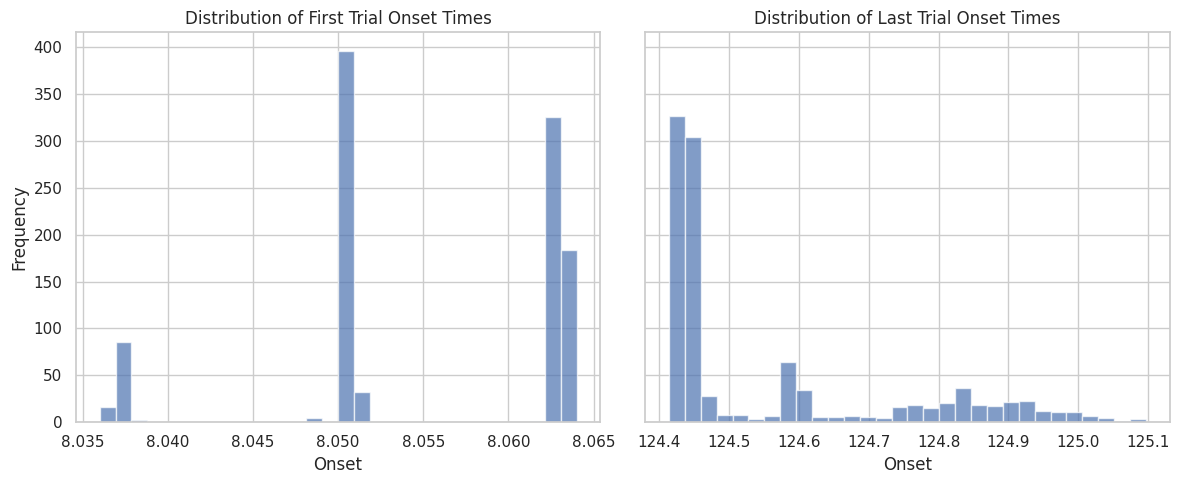

In [22]:
onset_times = emotion_df.groupby("subject")["onset"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Onset Times")
axes[0].set_xlabel("Onset")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Onset Times")
axes[1].set_xlabel("Onset")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstonset.png", dpi=300, bbox_inches='tight')
plt.show()

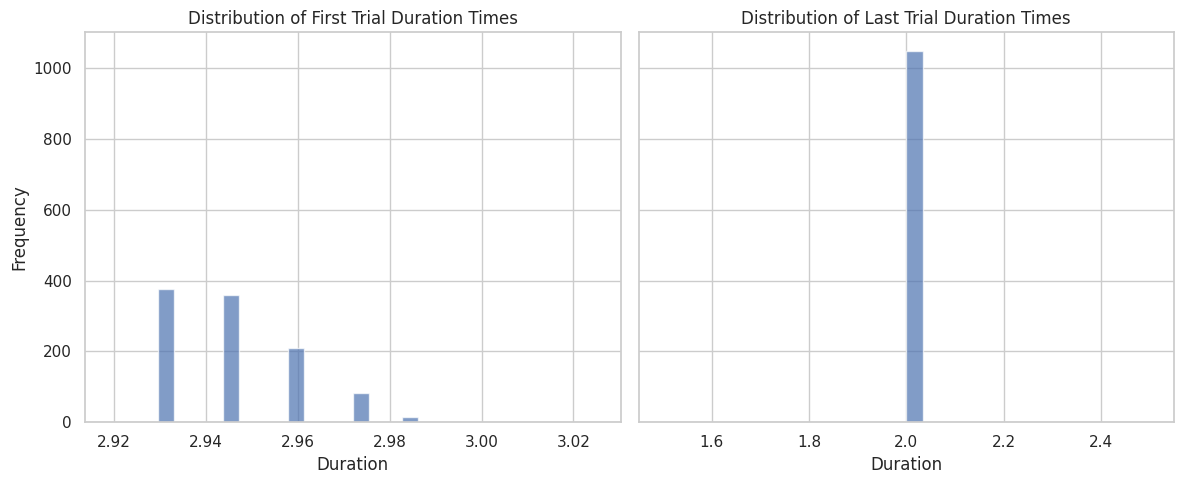

In [23]:
onset_times = emotion_df.groupby("subject")["duration"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Duration Times")
axes[0].set_xlabel("Duration")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Duration Times")
axes[1].set_xlabel("Duration")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstduration.png", dpi=300, bbox_inches='tight')
plt.show()

### Distribution of `Durations`

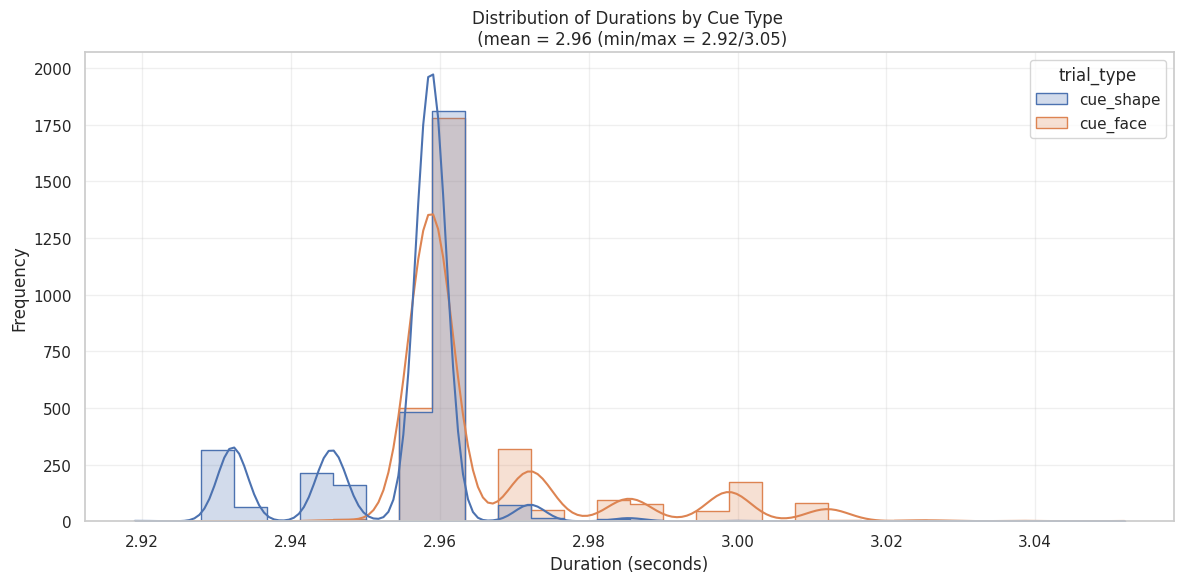

In [24]:
cue_trials = emotion_df[emotion_df['trial_type'].str.contains('cue', case=False)]


duration_mean = np.round(cue_trials['duration'].mean(),2)
duration_min = np.round(cue_trials['duration'].min(),2)
duration_max = np.round(cue_trials['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=cue_trials, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations by Cue Type \n (mean = {duration_mean} (min/max = {duration_min}/{duration_max})")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-cuedurations.png", dpi=300, bbox_inches='tight')
plt.show()


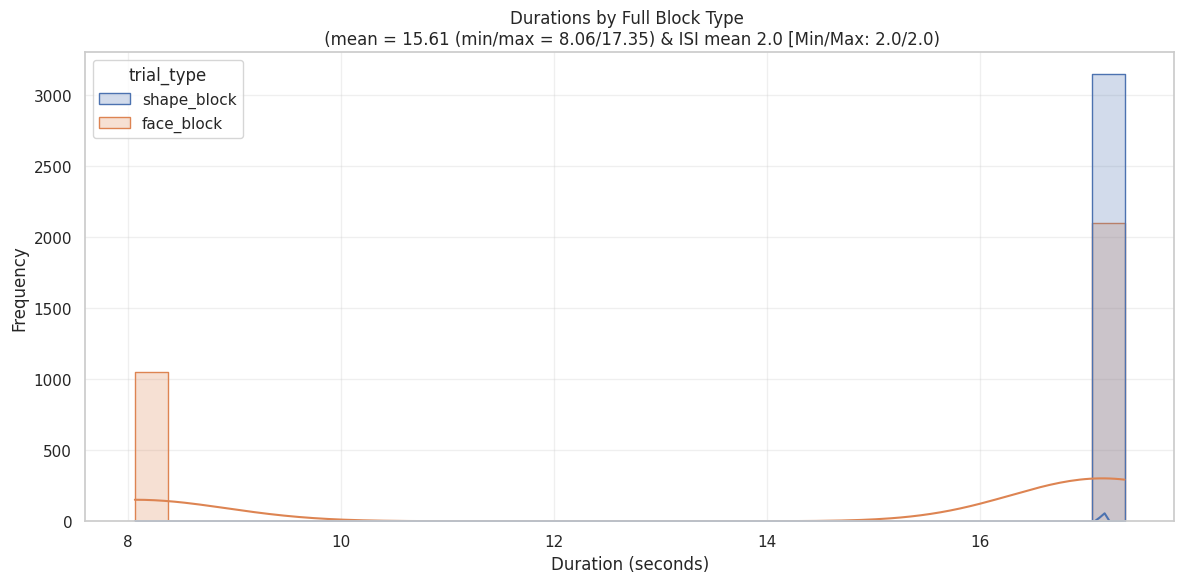

In [25]:
fullblk_trials = emotion_df[emotion_df['trial_type'].str.contains('block', case=False)]
plt.figure(figsize=(12, 6))
sns.histplot(data=fullblk_trials, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins

duration_mean = np.round(fullblk_trials['duration'].mean(),2)
duration_min = np.round(fullblk_trials['duration'].min(),2)
duration_max = np.round(fullblk_trials['duration'].max(),2)

plt.title(f"Durations by Full Block Type \n (mean = {duration_mean} (min/max = {duration_min}/{duration_max}) & ISI mean {avg_isi} [Min/Max: {min_isi}/{max_isi})")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fullblockdurations.png", dpi=300, bbox_inches='tight')
plt.show()


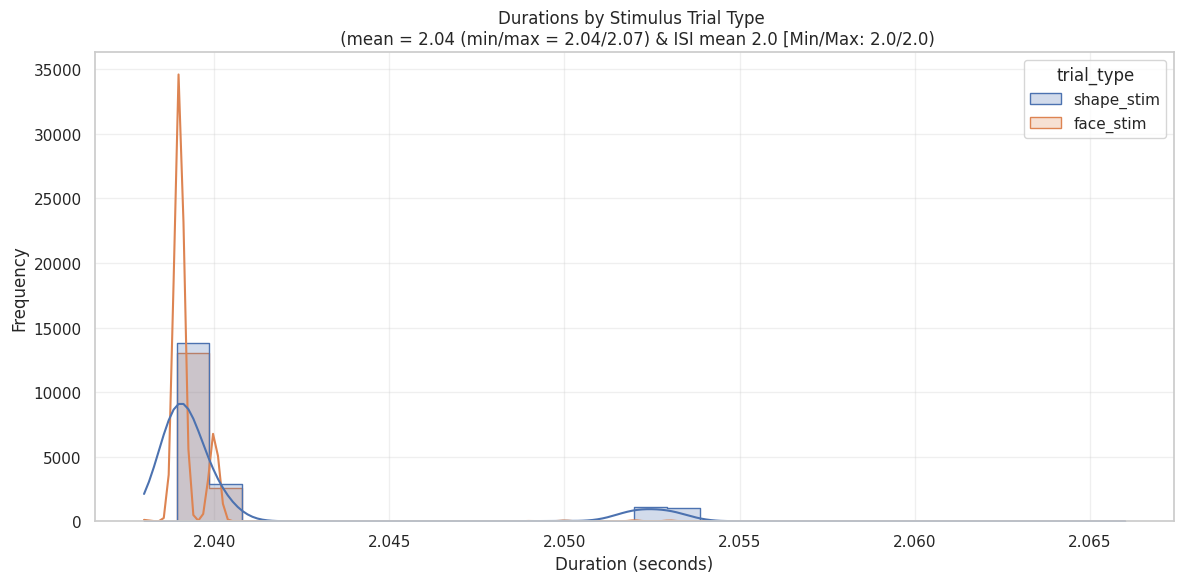

In [26]:
stimulus_trials = emotion_df[emotion_df['trial_type'].str.contains('stim', case=False)]
isi_trials = emotion_df[emotion_df['trial_type'].str.contains('isi', case=False)]
avg_isi = isi_trials['duration'].mean()
min_isi = isi_trials['duration'].min()
max_isi = isi_trials['duration'].max()
duration_mean = np.round(stimulus_trials['duration'].mean(),2)
duration_min = np.round(stimulus_trials['duration'].min(),2)
duration_max = np.round(stimulus_trials['duration'].max(),2)
plt.figure(figsize=(12, 6))
sns.histplot(data=stimulus_trials, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins

plt.title(f"Durations by Stimulus Trial Type \n (mean = {duration_mean} (min/max = {duration_min}/{duration_max}) & ISI mean {avg_isi} [Min/Max: {min_isi}/{max_isi})")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')

plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-stimulusdurations.png", dpi=300, bbox_inches='tight')
plt.show()


"there was a **bug in the E-prime script for this task such that the task stopped short of the last three trials of the last task block in each run**.".
The distribution below suggests that this is limited to the `Faces`. As the last and third block for Shapes is consistent with the others.

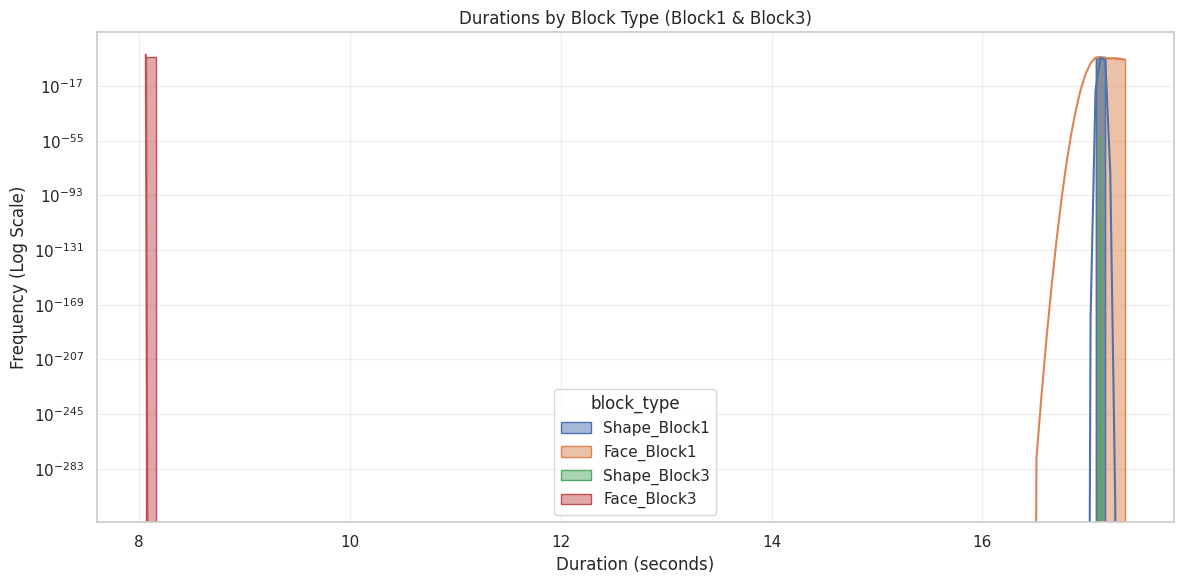

In [27]:
plt.figure(figsize=(12, 6))

# Filter data to include only Block1 and Block3
blocktype = emotion_df[
    emotion_df['block_type'].str.contains('Block1|Block3', case=False, na=False) & 
    emotion_df['trial_type'].str.contains('block', case=False, na=False)
]

sns.histplot(data=blocktype, x='duration', hue='block_type', kde=True, element='step',
             bins=100, alpha=0.5, multiple="layer") 

plt.yscale("log")  # Log scale to better see differences
plt.title("Durations by Block Type (Block1 & Block3)")
plt.xlabel("Duration (seconds)")
plt.ylabel("Frequency (Log Scale)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-blocktypedurations.png", dpi=300, bbox_inches='tight')
plt.show()


### `Responses` Times across Stimulus Type

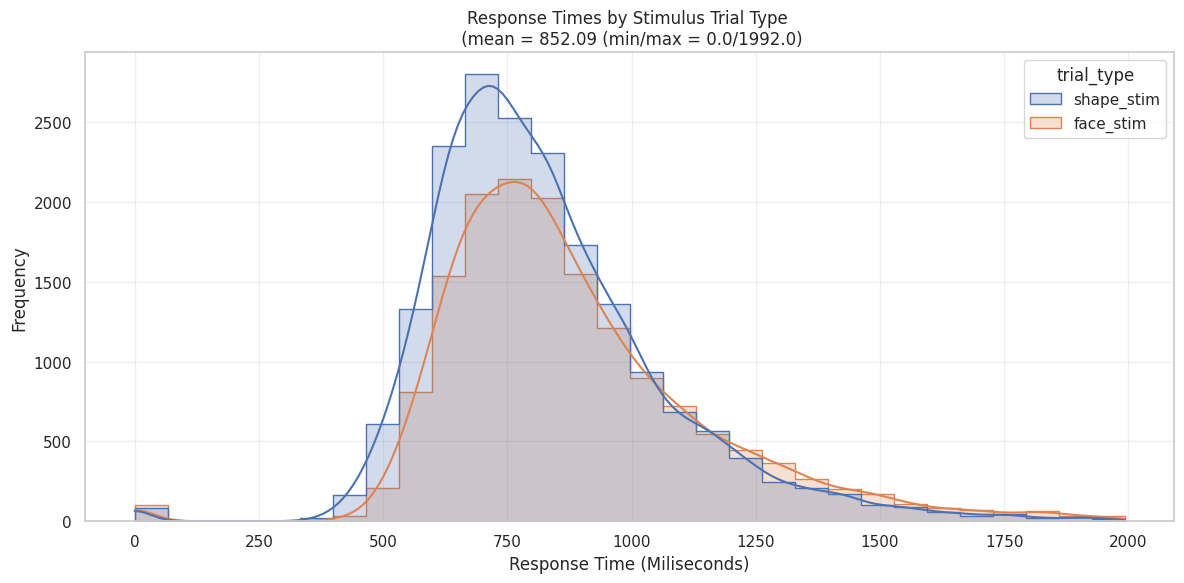

In [31]:
stimulus_trials = emotion_df[emotion_df['trial_type'].str.contains('stim', case=False)]
plt.figure(figsize=(12, 6))
sns.histplot(data=stimulus_trials, x='response_time', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins

resp_mean = np.round(stimulus_trials['response_time'].mean(),2)
resp_min = np.round(stimulus_trials['response_time'].min(),2)
resp_max = np.round(stimulus_trials['response_time'].max(),2)

plt.title(f"Response Times by Stimulus Trial Type \n (mean = {resp_mean} (min/max = {resp_min}/{resp_max})")
plt.xlabel('Response Time (Miliseconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-rtbystimulusdist.png", dpi=300, bbox_inches='tight')
plt.show()


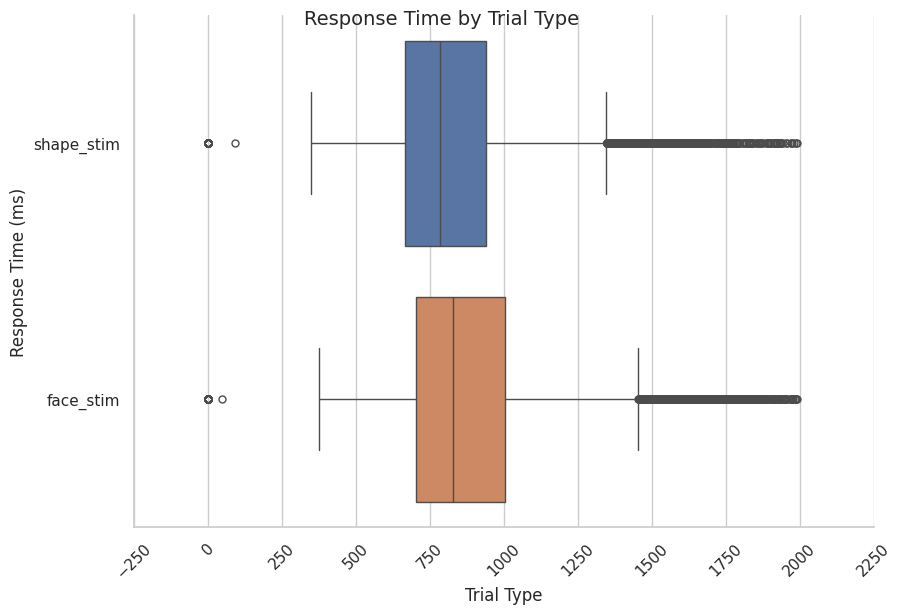

In [33]:
sns.set(style="whitegrid")

# Create the plot with facets by stim_type
g = sns.catplot(data=stimulus_trials, x="response_time", y="trial_type", hue="trial_type", kind="box", height=6, aspect=1.5)

# Label the axes
g.set_axis_labels("Trial Type", "Response Time (ms)")

# Title for the entire plot
g.fig.suptitle("Response Time by Trial Type", fontsize=14)

# Rotate x-axis labels if necessary
g.set_xticklabels(rotation=45)

# Show the plot
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-rtbystimulushist.png", dpi=300, bbox_inches='tight')
plt.show()


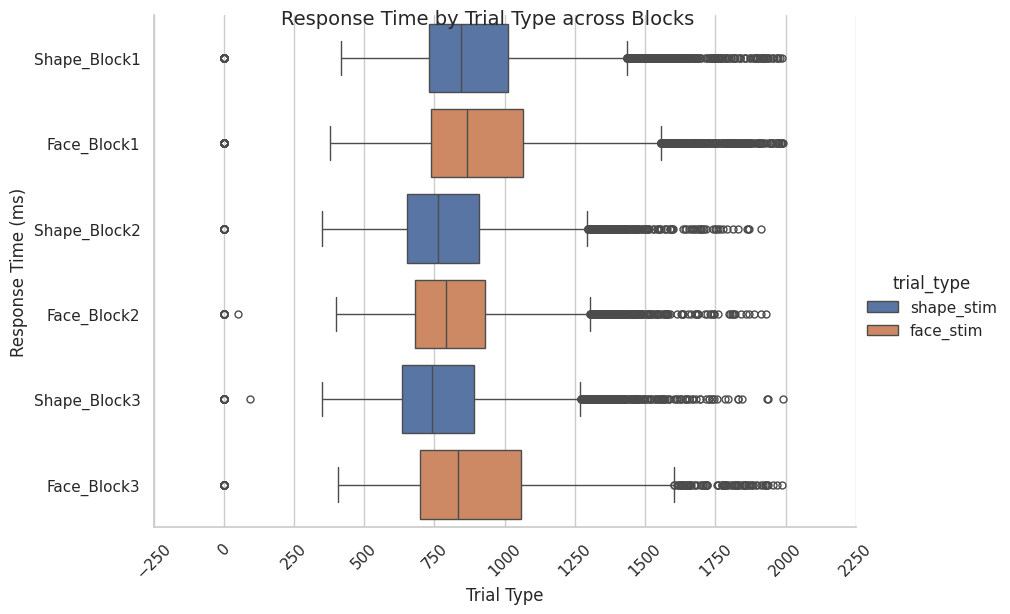

In [30]:
sns.set(style="whitegrid")

# Create the plot with facets by stim_type
g = sns.catplot(data=stimulus_trials, x="response_time", y="block_type", hue="trial_type", kind="box", height=6, aspect=1.5)

# Label the axes
g.set_axis_labels("Trial Type", "Response Time (ms)")

# Title for the entire plot
g.fig.suptitle("Response Time by Trial Type across Blocks", fontsize=14)

# Rotate x-axis labels if necessary
g.set_xticklabels(rotation=45)

# Show the plot
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-rtbyblockdist.png", dpi=300, bbox_inches='tight')
plt.show()


## Gambling

The [Barch et al. (2013, pg 177)](https://www.sciencedirect.com/science/article/pii/S1053811913005272) highlights the Gambling Task as:

"Incentive processing. This task was adapted from the one developed by Delgado et al. (2000), and was chosen based on prior evidence that the task elicits activations in the striatum and other reward related regions that are robust and reliable across the subjects (Delgado et al., 2000; Forbes et al., 2009; May et al., 2004; Tricomi et al., 2004). The participants play a card guessing game where they are asked to guess the number on a mystery card (represented by a “?”) in order to win or lose money. They are told that potential card numbers range from 1 to 9 and to indicate if they think the mystery card number is more or less than 5 by pressing one of two buttons on the  response box. Feedback is the number on the card (generated by the program as a function of whether the trial was a reward, loss or neutral trial) and either: 1) a green up arrow with `$1` for reward trials, 2) a red down arrow next to − `$0.50` for loss trials; or 3) the number 5 and a gray double headed arrow for neutral trials. The “?” is presented for up to 1.5 s (if the participant responds before 1.5 s, a fixation cross is displayed for the remaining time), following by feedback for 1.0 s. There is a 1.0 s ITI with a “+” presented on the screen. The task is presented in blocks of 8 trials that are either mostly reward (6 reward trials pseudo randomly interleaved with either 1 neutral and 1 loss trial, 2 neutral trials, or 2 loss trials) or mostly loss (6 loss trials interleaved with either 1 neutral and 1 reward trial, 2 neutral trials, or 2 reward trials). In each of the two runs, there are 2 mostly reward and 2 mostly loss blocks, interleaved with 4 fixation blocks (15 s each). All the participants are provided with money as a result of completing the task, though it is a standard amount across subjects."

In [34]:
task = 'gambling'
run = 'run1'

files = sorted(Path(events_folder).rglob(f"sub-*_ses-3T_task-{task}_dir-*_{run}_events.tsv"))
combined = []
for sub_file in files:
    subject = sub_file.parts[-4]    
    out = pd.read_csv(sub_file, sep='\t')
    combined.append((subject, out))  # Append tuple of subject ID and processed dataframe
gambling_df = pd.concat([df.assign(subject=subject) for subject, df in combined], ignore_index=True)
print("Rows in final Df:", len(gambling_df), "for unique subjects:", len(gambling_df['subject'].unique()))

Rows in final Df: 147152 for unique subjects: 1082


### Distribution of First/Last Onset Time & Duration

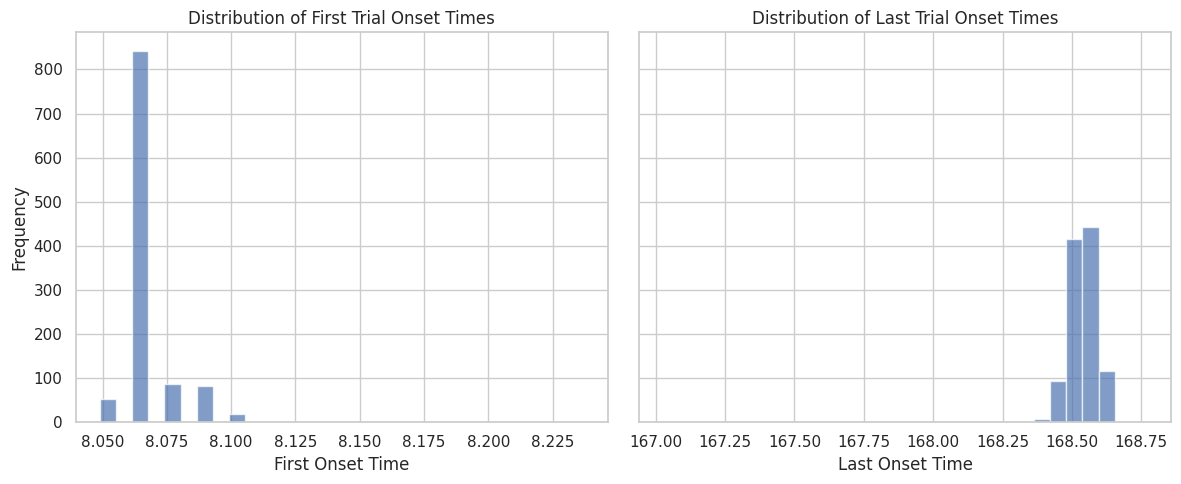

In [35]:
onset_times = gambling_df.groupby("subject")["onset"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Onset Times")
axes[0].set_xlabel("First Onset Time")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Onset Times")
axes[1].set_xlabel("Last Onset Time")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstonsets", dpi=300, bbox_inches='tight')
plt.show()

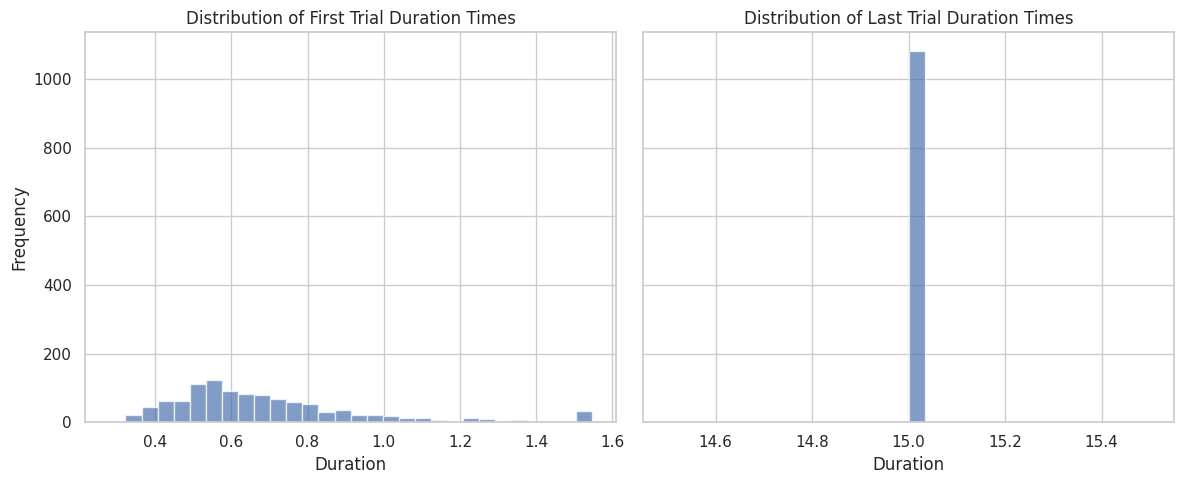

In [36]:
onset_times = gambling_df.groupby("subject")["duration"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Duration Times")
axes[0].set_xlabel("Duration")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Duration Times")
axes[1].set_xlabel("Duration")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstdurations", dpi=300, bbox_inches='tight')

plt.show()

### Distribution of `Durations`

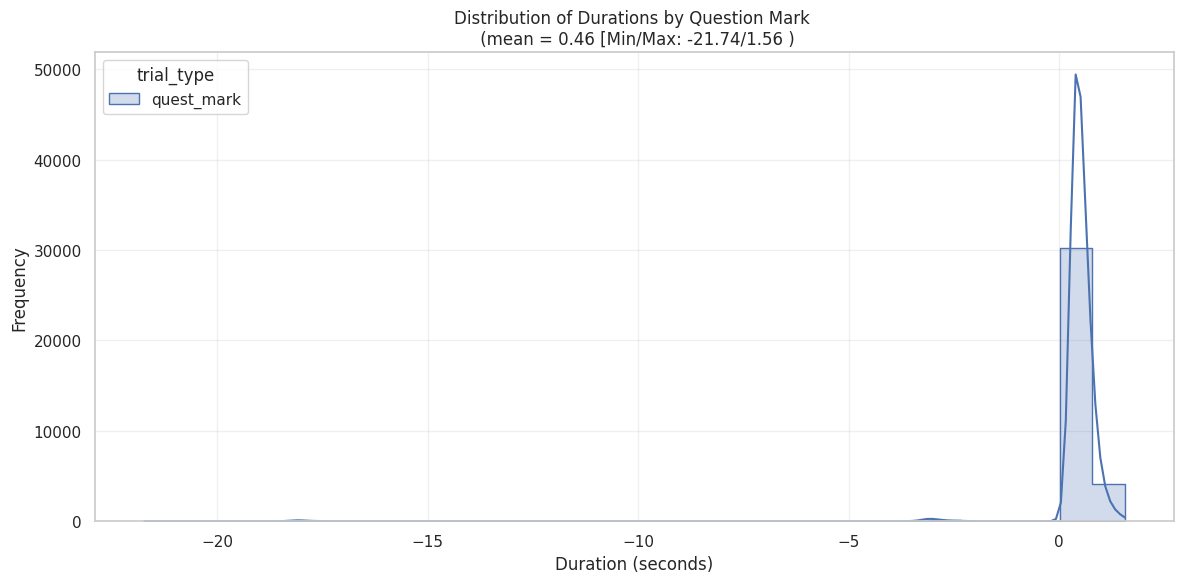

In [39]:
questmark_trials = gambling_df[gambling_df['trial_type'].str.contains('quest_mark', case=False)]

duration_mean = np.round(questmark_trials['duration'].mean(),2)
duration_min = np.round(questmark_trials['duration'].min(),2)
duration_max = np.round(questmark_trials['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=questmark_trials, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations by Question Mark \n (mean = {duration_mean} [Min/Max: {duration_min}/{duration_max} )")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-qmarkdurs", dpi=300, bbox_inches='tight')
plt.show()

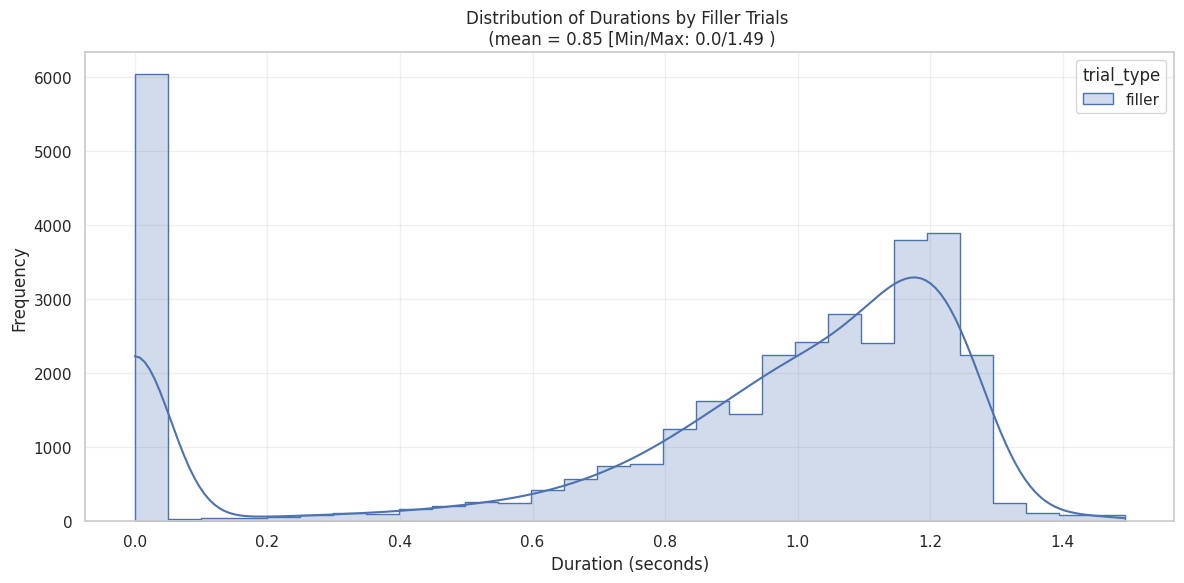

In [38]:
filler_trials = gambling_df[gambling_df['trial_type'].str.contains('filler', case=False)]

duration_mean = np.round(filler_trials['duration'].mean(),2)
duration_min = np.round(filler_trials['duration'].min(),2)
duration_max = np.round(filler_trials['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=filler_trials, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations by Filler Trials \n (mean = {duration_mean} [Min/Max: {duration_min}/{duration_max} )")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fillerdurs", dpi=300, bbox_inches='tight')

plt.show()

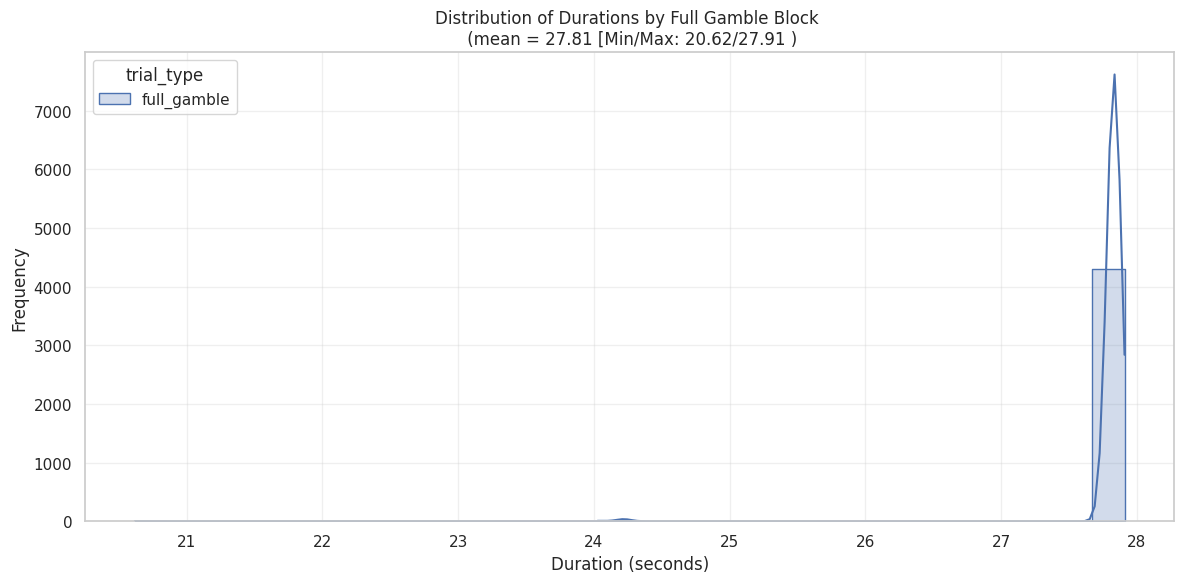

In [40]:
full_gamble_dur = gambling_df[gambling_df['trial_type'].str.contains('full', case=False)]

duration_mean = np.round(full_gamble_dur['duration'].mean(),2)
duration_min = np.round(full_gamble_dur['duration'].min(),2)
duration_max = np.round(full_gamble_dur['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=full_gamble_dur, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations by Full Gamble Block \n (mean = {duration_mean} [Min/Max: {duration_min}/{duration_max} )")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fullblockdur", dpi=300, bbox_inches='tight')

plt.show()

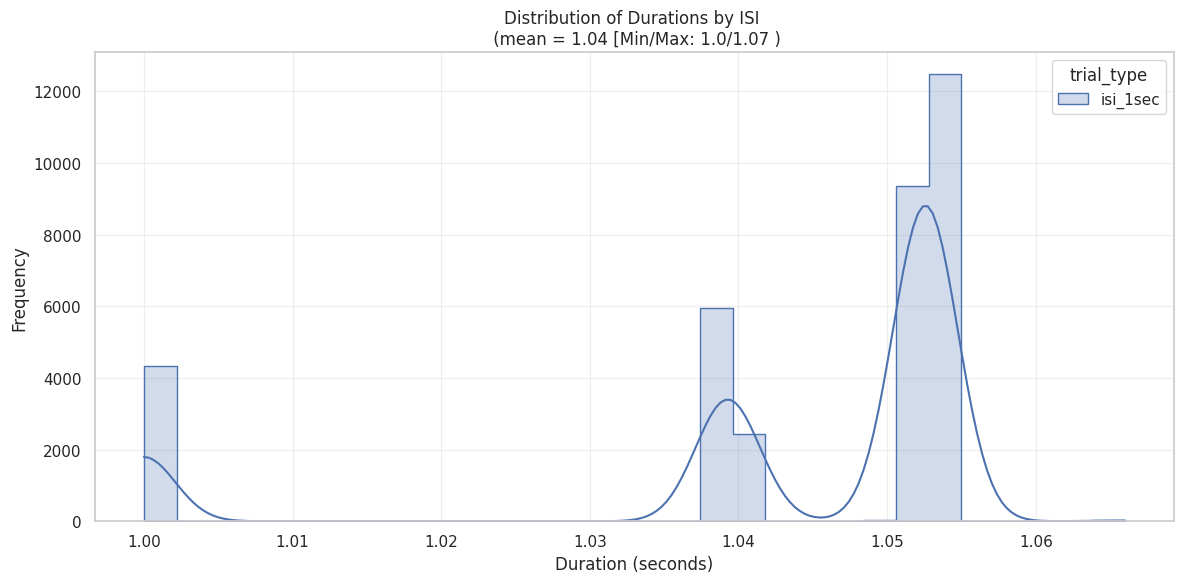

In [41]:
# Note, some ISIs are defered to the default 1000ms when next row is empty and unable to calculate (i.e., onsettoonset not informative)
isi_dur = gambling_df[gambling_df['trial_type'].str.contains('isi', case=False)]

duration_mean = np.round(isi_dur['duration'].mean(),2)
duration_min = np.round(isi_dur['duration'].min(),2)
duration_max = np.round(isi_dur['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=isi_dur, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations by ISI \n (mean = {duration_mean} [Min/Max: {duration_min}/{duration_max} )")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-isidura.png", dpi=300, bbox_inches='tight')

plt.show()

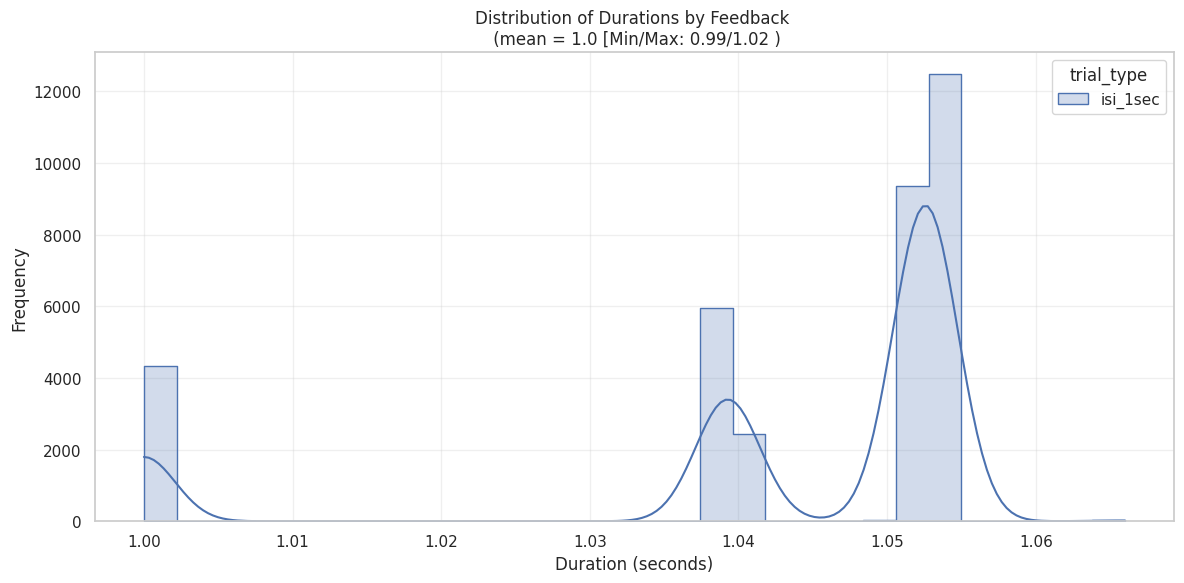

In [42]:
# Note, some Feedback Durations are defered to the default 1000ms when next row is empty and unable to calculate (i.e., onsettoonset not informative)

fb_dur = gambling_df[gambling_df['trial_type'].str.contains('feedback', case=False)]

duration_mean = np.round(fb_dur['duration'].mean(),2)
duration_min = np.round(fb_dur['duration'].min(),2)
duration_max = np.round(fb_dur['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=isi_dur, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations by Feedback \n (mean = {duration_mean} [Min/Max: {duration_min}/{duration_max} )")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-feedbackduration.png", dpi=300, bbox_inches='tight')

plt.show()

### Response times

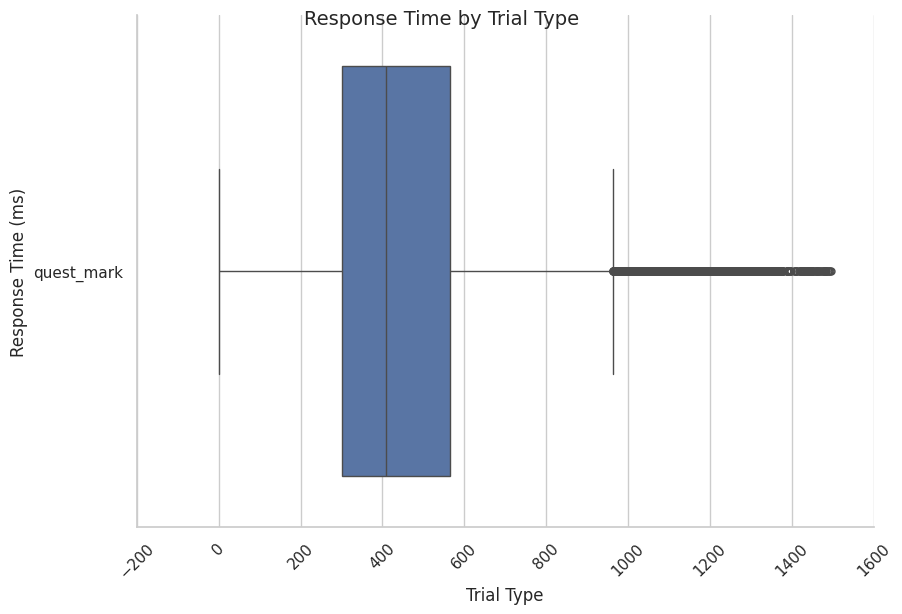

In [43]:
# Create the plot with facets by stim_type
g = sns.catplot(data=questmark_trials, x="response_time", y="trial_type", hue="trial_type", kind="box", height=6, aspect=1.5)

# Label the axes
g.set_axis_labels("Trial Type", "Response Time (ms)")

# Title for the entire plot
g.fig.suptitle("Response Time by Trial Type", fontsize=14)

# Rotate x-axis labels if necessary
g.set_xticklabels(rotation=45)

# Show the plot
plt.show()

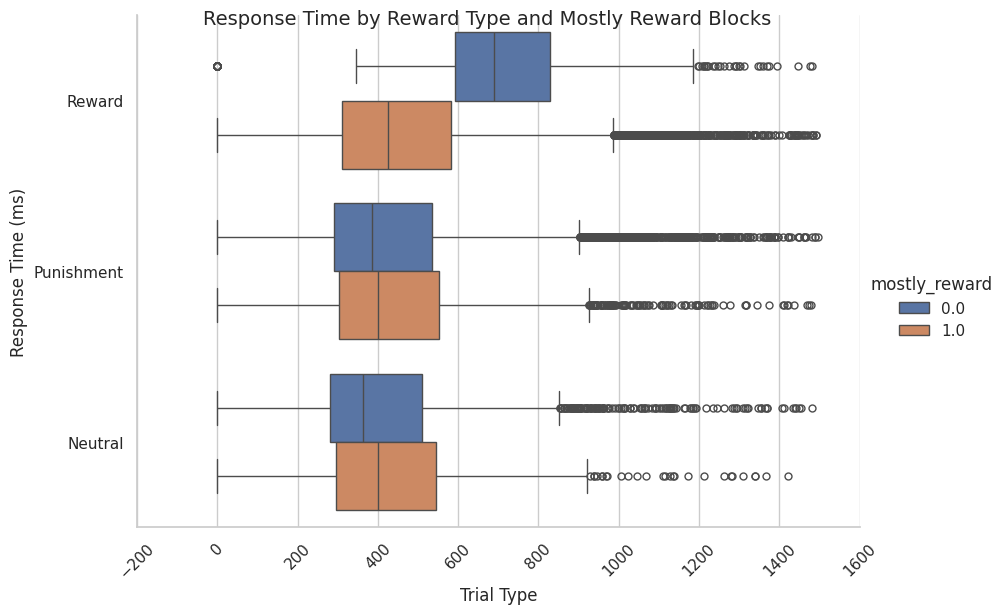

In [44]:
# Create the plot with facets by stim_type
g = sns.catplot(data=questmark_trials, x="response_time", y="reward_type", hue="mostly_reward", kind="box", height=6, aspect=1.5)

# Label the axes
g.set_axis_labels("Trial Type", "Response Time (ms)")

# Title for the entire plot
g.fig.suptitle("Response Time by Reward Type and Mostly Reward Blocks", fontsize=14)

# Rotate x-axis labels if necessary
g.set_xticklabels(rotation=45)

# Show the plot
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-responserewardtype.png", dpi=300, bbox_inches='tight')

plt.show()

## Language 

The [Barch et al. (2013, pg 177-178)](https://www.sciencedirect.com/science/article/pii/S1053811913005272) highlights the Language Task as:


"Language processing. The task being used in Phase II was developed by Binder et al. (2011) and used the E-prime scripts kindly provided by these investigators, which were then modified for our purposes. The task consists of two runs that each interleave 4 blocks of a story task and 4 blocks of a math task. As described in detail in Binder et. al. (2011), the goal of including the math blocks was to provide a comparison task that was attentionally demanding, similar in auditory and phonological input, and unlikely to generate activation of anterior temporal lobe regions involved in semantic processing, though likely to engage numerosity related processing in the parietal cortex. The lengths of the blocks vary (average of approximately 30 s), but the task was designed so that the math task blocks match the length of the story task blocks, with some additional math trials at the end of the task to complete the 3.8 min run as needed. The story blocks present participants with brief auditory stories (5–9 sentences) adapted from Aesop's fables, followed by a 2-alternative forcedchoice question that asks the participants about the topic of the story. The example provided in the original Binder paper (p. 1466) is “For example, after a story about an eagle that saves a man who had done him a favor, participants were asked, ‘That was about revenge or reciprocity?’” The math task also presents trials auditorily and requires the subjects to complete addition and subtraction problems. The trials present the subjects with a series of arithmetic operations (e.g., “Fourteen plus twelve”), followed by “equals” and then two choices (e.g., “twenty-nine or twenty-six”). The participants push a button to select either the first or the second answer. The math task is adaptive to maintain a similar level of difficulty across the participants. For more details on the task, see Binder et al. (2011)."

In [58]:
task = 'language'
run = 'run1'

files = sorted(Path(events_folder).rglob(f"sub-*_ses-3T_task-{task}_dir-*_{run}_events.tsv"))
combined = []
for sub_file in files:
    subject = sub_file.parts[-4]    
    out = pd.read_csv(sub_file, sep='\t')
    combined.append((subject, out))  # Append tuple of subject ID and processed dataframe
language_df = pd.concat([df.assign(subject=subject) for subject, df in combined], ignore_index=True)
print("Rows in final Df:", len(language_df), "for unique subjects:", len(language_df['subject'].unique()))

Rows in final Df: 62721 for unique subjects: 1023


### Distribution of First/Last OnsetTime

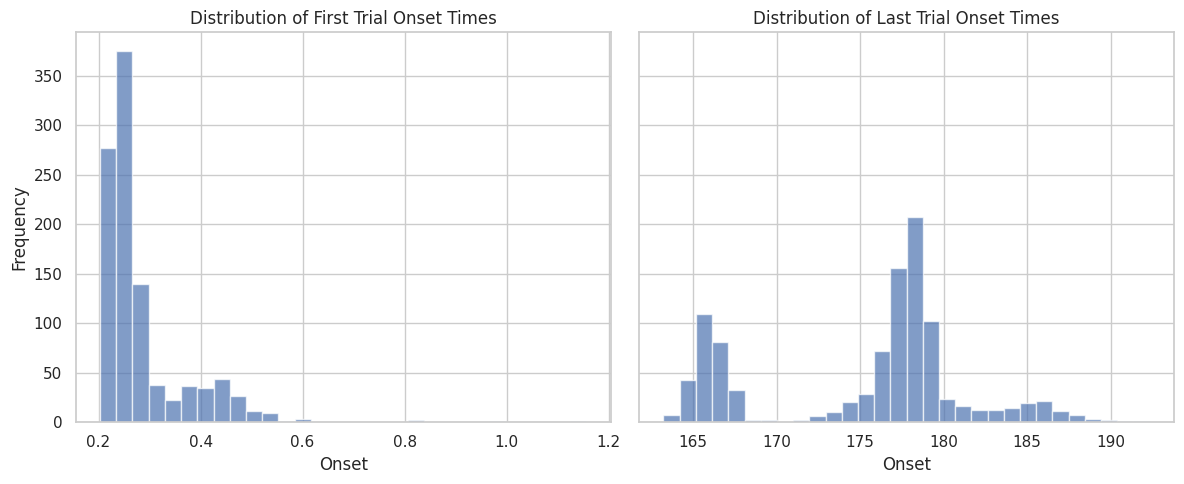

In [59]:
onset_times = language_df.groupby("subject")["onset"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Onset Times")
axes[0].set_xlabel("Onset")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Onset Times")
axes[1].set_xlabel("Onset")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstonsets.png", dpi=300, bbox_inches='tight')
plt.show()

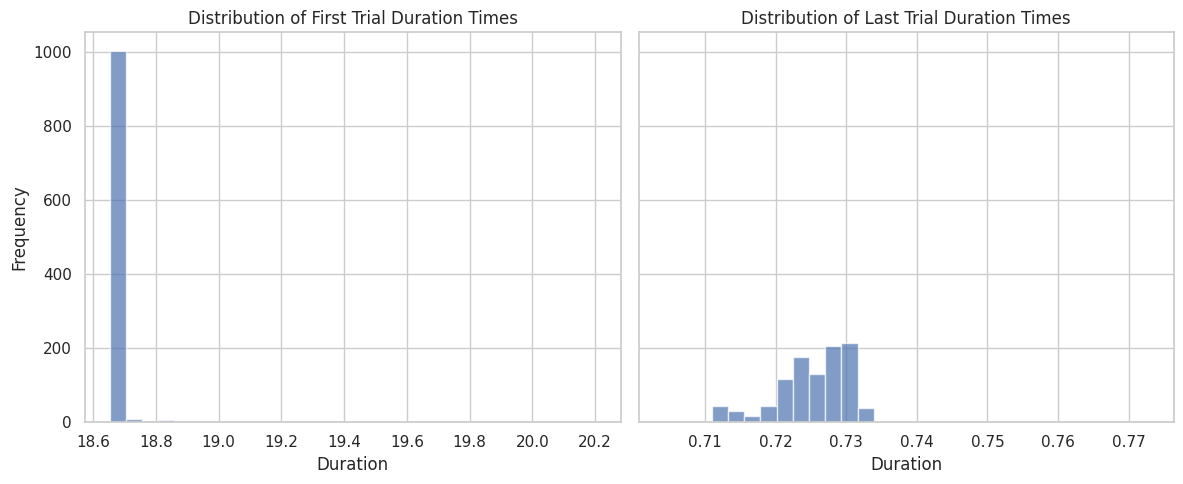

In [60]:
onset_times = language_df.groupby("subject")["duration"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Duration Times")
axes[0].set_xlabel("Duration")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Duration Times")
axes[1].set_xlabel("Duration")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstdurations.png", dpi=300, bbox_inches='tight')
plt.show()

### Distribution of `Durations`

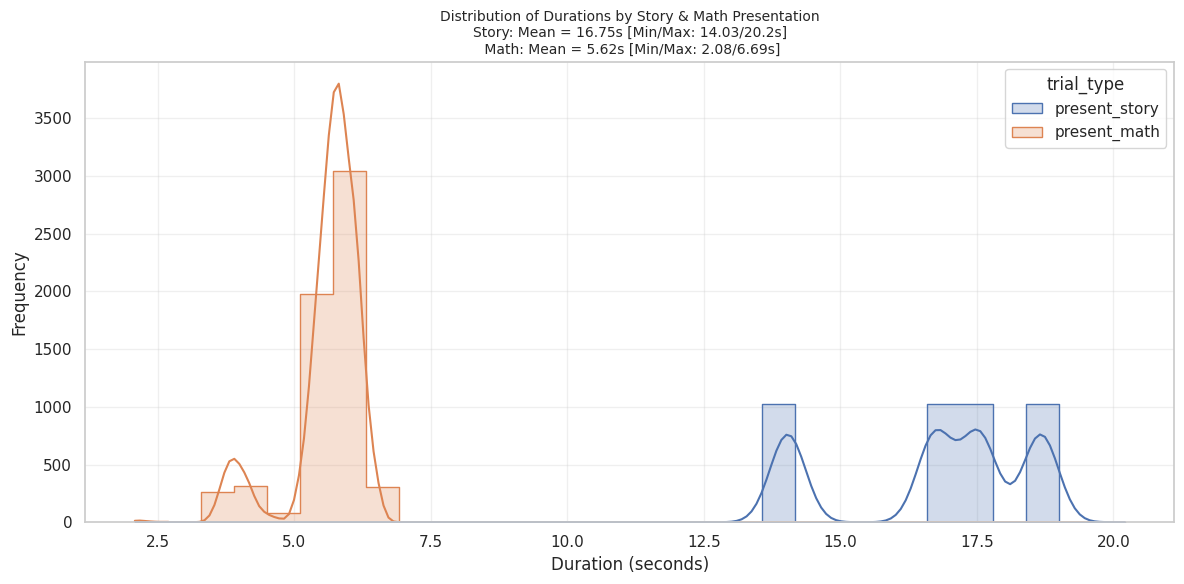

In [48]:
presentation = language_df[language_df['trial_type'].str.contains('present_story|present_math', case=False, na=False)]

# Compute summary statistics for each trial_type
stats = presentation.groupby('trial_type')['duration'].agg(['mean', 'min', 'max']).round(2)

# Extract values
story_mean, story_min, story_max = stats.loc['present_story']
math_mean, math_min, math_max = stats.loc['present_math']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=presentation, 
    x='duration', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations by Story & Math Presentation\n"
    f"Story: Mean = {story_mean}s [Min/Max: {story_min}/{story_max}s]\n "
    f"Math: Mean = {math_mean}s [Min/Max: {math_min}/{math_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-presentationduration", dpi=300, bbox_inches='tight')

plt.tight_layout()

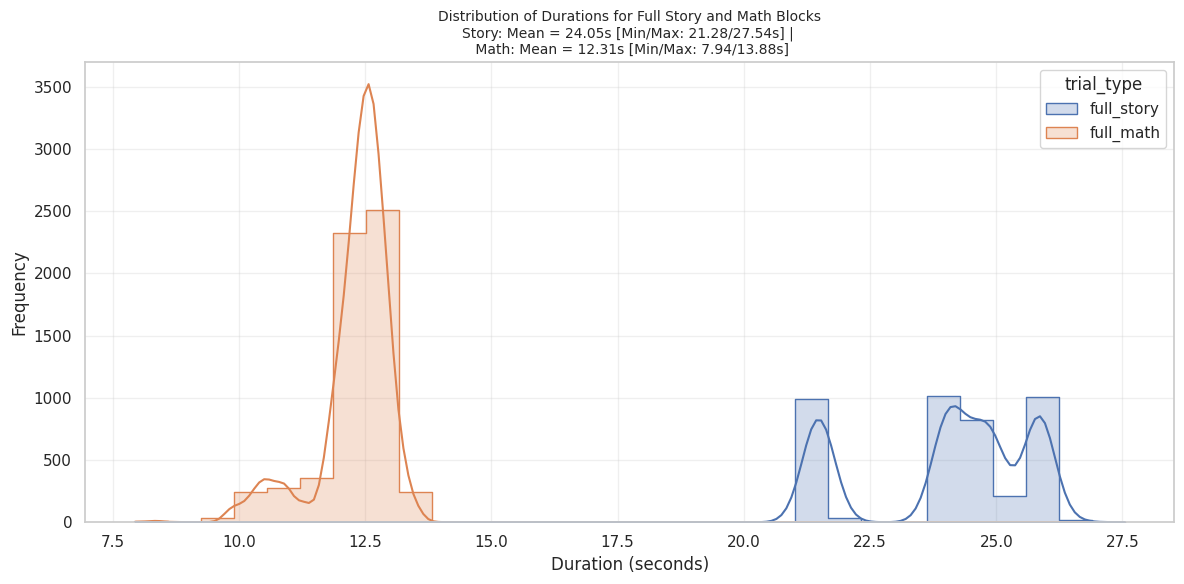

In [49]:
full_block = language_df[language_df['trial_type'].str.contains('full_story|full_math', case=False, na=False)]
stats = full_block.groupby('trial_type')['duration'].agg(['mean', 'min', 'max']).round(2)

story_mean, story_min, story_max = stats.loc['full_story']
math_mean, math_min, math_max = stats.loc['full_math']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=full_block, 
    x='duration', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations for Full Story and Math Blocks\n"
    f"Story: Mean = {story_mean}s [Min/Max: {story_min}/{story_max}s] | \n "
    f"Math: Mean = {math_mean}s [Min/Max: {math_min}/{math_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fullblockdurations", dpi=300, bbox_inches='tight')

plt.show()


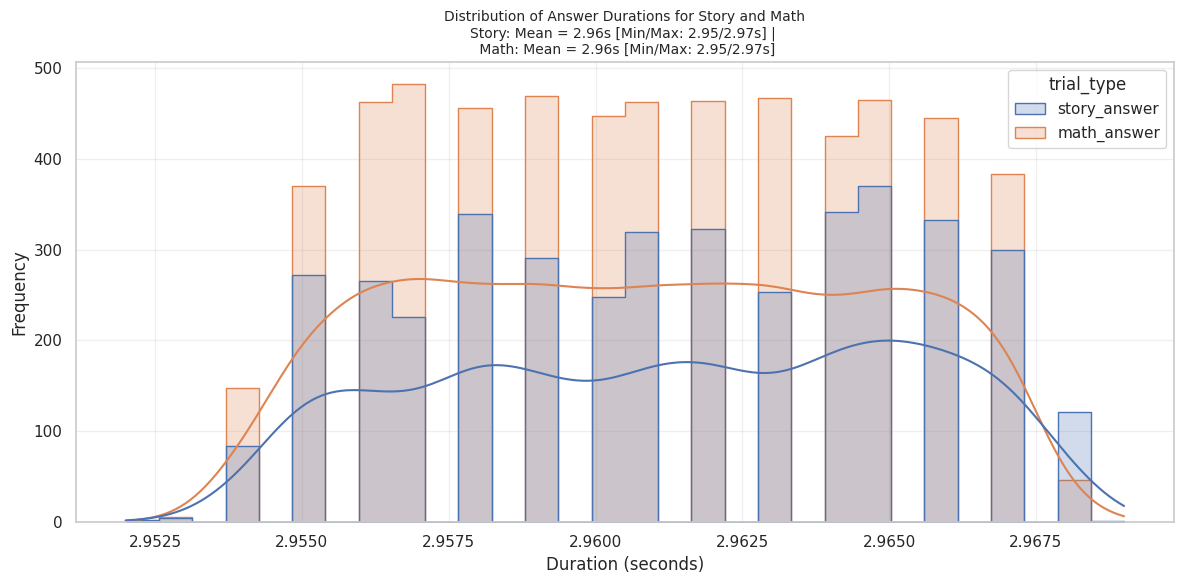

In [50]:
answers = language_df[language_df['trial_type'].str.contains('story_answer|math_answer', case=False, na=False)]
stats = answers.groupby('trial_type')['duration'].agg(['mean', 'min', 'max']).round(2)

story_mean, story_min, story_max = stats.loc['story_answer']
math_mean, math_min, math_max = stats.loc['math_answer']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=answers, 
    x='duration', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Answer Durations for Story and Math\n"
    f"Story: Mean = {story_mean}s [Min/Max: {story_min}/{story_max}s] | \n "
    f"Math: Mean = {math_mean}s [Min/Max: {math_min}/{math_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-answerdurations", dpi=300, bbox_inches='tight')

plt.show()


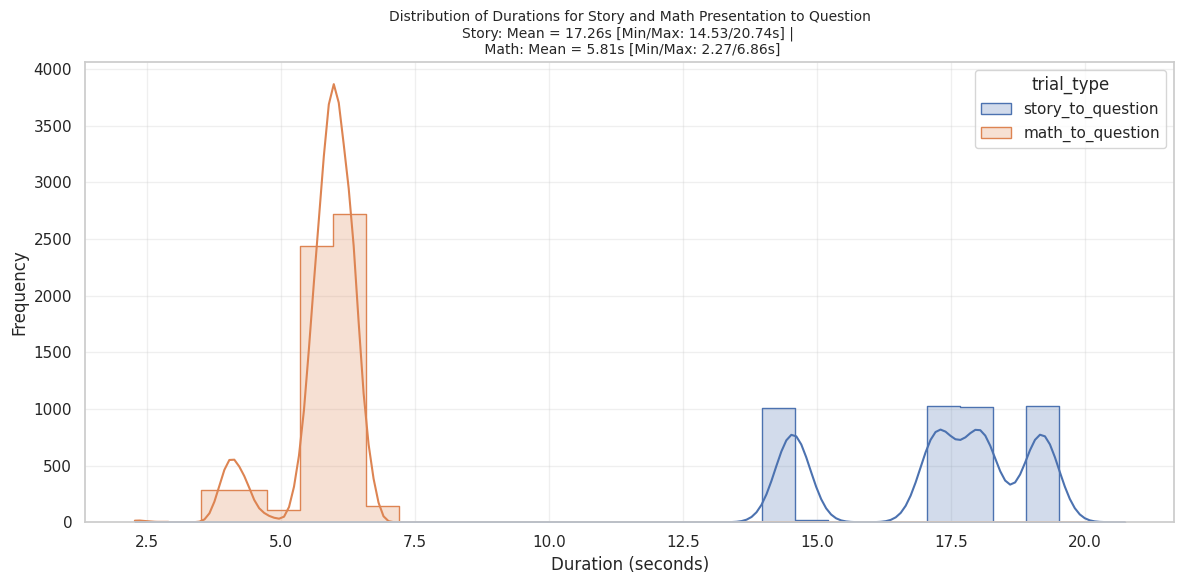

In [52]:
to_question = language_df[language_df['trial_type'].str.contains('story_to_question|math_to_question', case=False, na=False)]
stats = to_question.groupby('trial_type')['duration'].agg(['mean', 'min', 'max']).round(2)

story_mean, story_min, story_max = stats.loc['story_to_question']
math_mean, math_min, math_max = stats.loc['math_to_question']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=to_question, 
    x='duration', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations for Story and Math Presentation to Question\n"
    f"Story: Mean = {story_mean}s [Min/Max: {story_min}/{story_max}s] | \n "
    f"Math: Mean = {math_mean}s [Min/Max: {math_min}/{math_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-cuetoquestionduration", dpi=300, bbox_inches='tight')

plt.show()


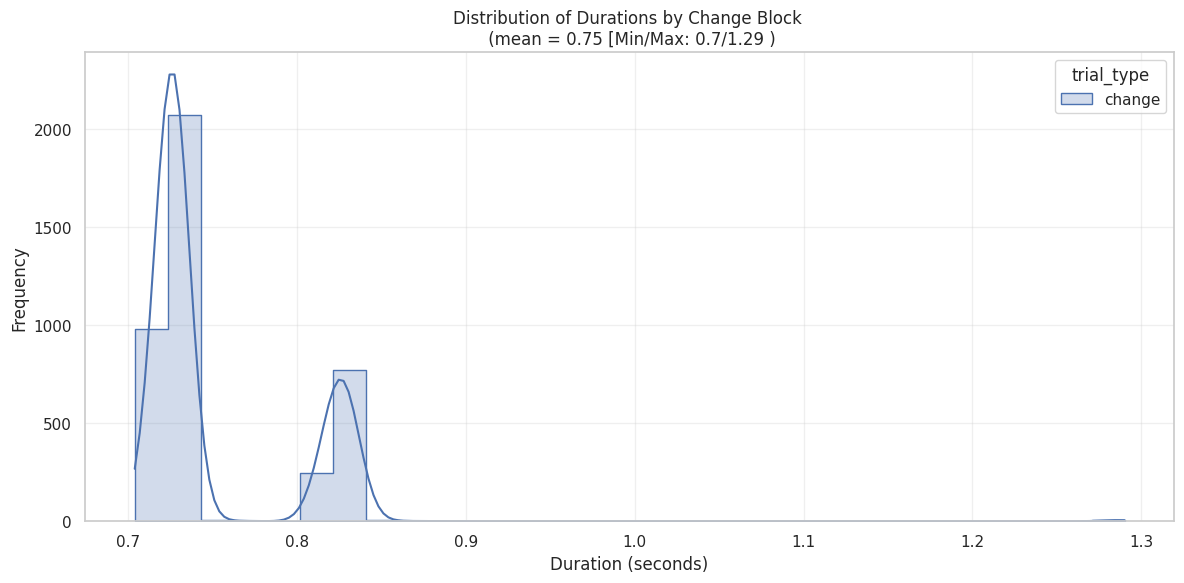

In [53]:
change = language_df[language_df['trial_type'].str.contains('change', case=False)]

duration_mean = np.round(change['duration'].mean(),2)
duration_min = np.round(change['duration'].min(),2)
duration_max = np.round(change['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=change, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations by Change Block \n (mean = {duration_mean} [Min/Max: {duration_min}/{duration_max} )")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-changeblockdurations", dpi=300, bbox_inches='tight')

plt.show()

### Response times

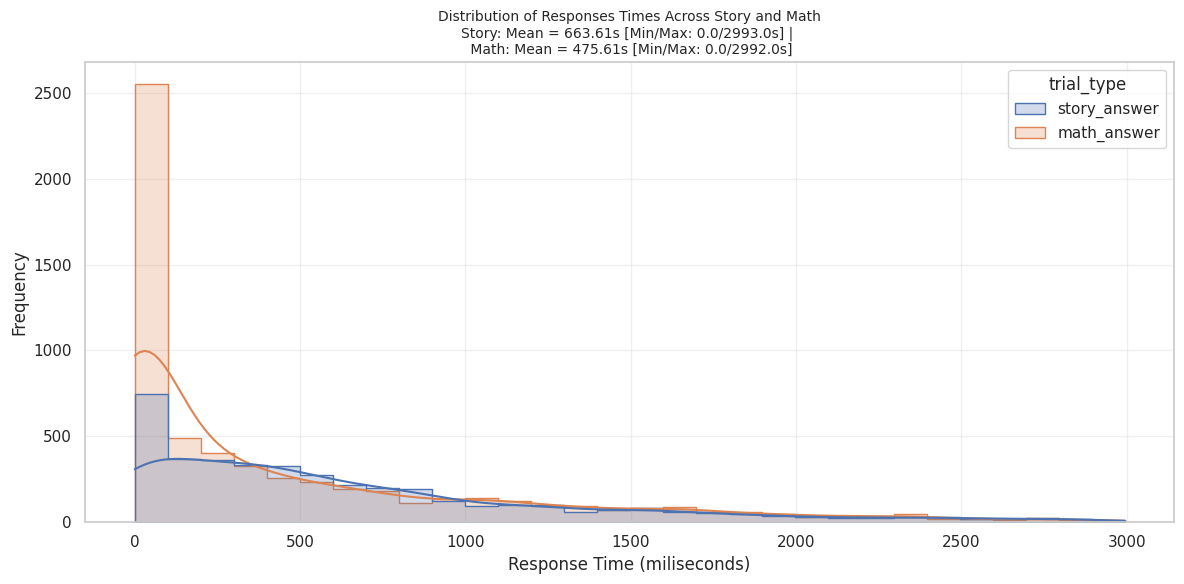

In [54]:
response_times = language_df[language_df['trial_type'].str.contains('story_answer|math_answer', case=False, na=False)]
stats = answers.groupby('trial_type')['response_time'].agg(['mean', 'min', 'max']).round(2)

story_mean, story_min, story_max = stats.loc['story_answer']
math_mean, math_min, math_max = stats.loc['math_answer']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=answers, 
    x='response_time', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Responses Times Across Story and Math\n"
    f"Story: Mean = {story_mean}s [Min/Max: {story_min}/{story_max}s] | \n "
    f"Math: Mean = {math_mean}s [Min/Max: {math_min}/{math_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Response Time (miliseconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-responsetimesdist", dpi=300, bbox_inches='tight')

plt.show()

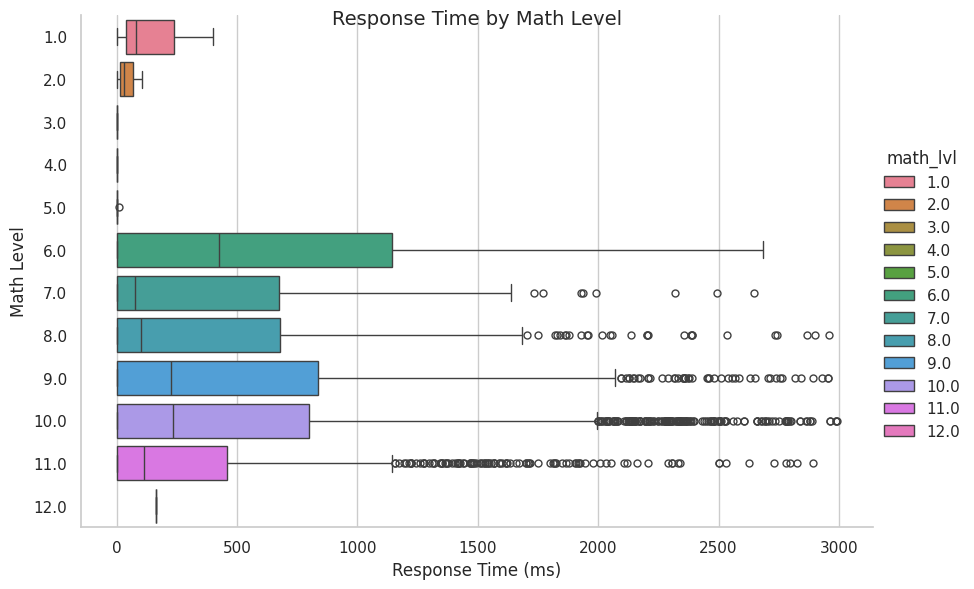

In [56]:
response_times = language_df[language_df['trial_type'].str.contains('math_answer', case=False, na=False)]
response_times = response_times.copy()  # Ensures it's a standalone DataFrame
response_times.loc[:, 'math_lvl'] = response_times['math_lvl'].astype('category')

# Create the box plot
g = sns.catplot(
    data=response_times, 
    x="response_time", 
    y="math_lvl", 
    hue="math_lvl", 
    kind="box", 
    height=6, 
    aspect=1.5
)

# Label the axes
g.set_axis_labels("Response Time (ms)", "Math Level")

# Title for the plot
g.fig.suptitle("Response Time by Math Level", fontsize=14)

# Show the plot
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-responsetimesmathdiff.png", dpi=300, bbox_inches='tight')

plt.show()

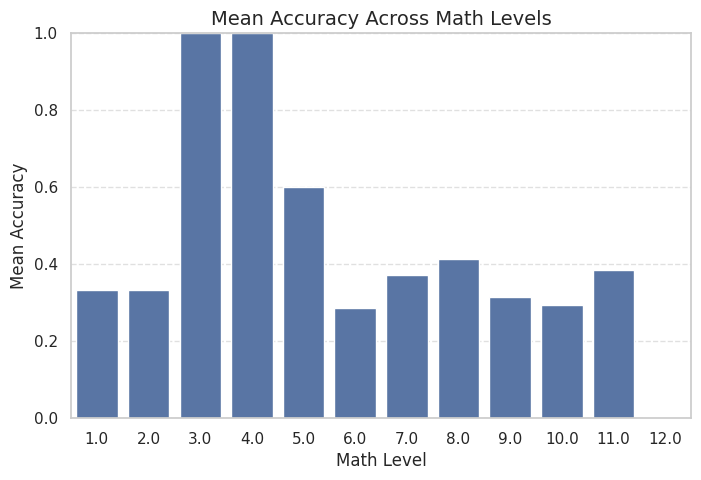

In [57]:
response_times.copy()
response_times.loc[:, 'math_lvl'] = response_times['math_lvl'].astype('category')

# Compute mean accuracy for each math level
accuracy_means = response_times.groupby('math_lvl')['accuracy'].mean().reset_index()

# Create a bar plot for mean accuracy
plt.figure(figsize=(8, 5))
sns.barplot(data=accuracy_means, x='math_lvl', y='accuracy')

# Label the axes
plt.xlabel("Math Level")
plt.ylabel("Mean Accuracy")
plt.title("Mean Accuracy Across Math Levels", fontsize=14)

# Show the plot
plt.ylim(0, 1)  # Since accuracy is between 0 and 1
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-mathdiffaccuracy.png", dpi=300, bbox_inches='tight')

plt.show()

## MOTOR

The [Barch et al. (2013, pg 177-178)](https://www.sciencedirect.com/science/article/pii/S1053811913005272) highlights the Language Task as:


"Motor. This task was adapted from the one developed by Buckner and colleagues which had evidence that it could identify effector specific activations in individual subjects (Buckner et al., 2011; Yeo et al., 2011). The participants are presented with visual cues that ask them to tap their left or right fingers, squeeze their left or right toes, or move their tongue to map motor areas. Each block of a movement type lasts 12 s (10 movements), and is preceded by a 3 s cue. In each of the two runs, there are 13 blocks, with 2 of tongue movements, 4 of hand movements (2 right and 2 left), 4 of foot movements (2 right and 2 left) and three 15 s fixation blocks per run."

In [61]:
task = 'motor'
run = 'run1'

files = sorted(Path(events_folder).rglob(f"sub-*_ses-3T_task-{task}_dir-*_{run}_events.tsv"))
combined = []
for sub_file in files:
    subject = sub_file.parts[-4]    
    out = pd.read_csv(sub_file, sep='\t')
    combined.append((subject, out))  # Append tuple of subject ID and processed dataframe
motor_df = pd.concat([df.assign(subject=subject) for subject, df in combined], ignore_index=True)
print("Rows in final Df:", len(motor_df), "for unique subjects:", len(motor_df['subject'].unique()))

Rows in final Df: 24978 for unique subjects: 1086


### Distribution of First/Last Onset Time

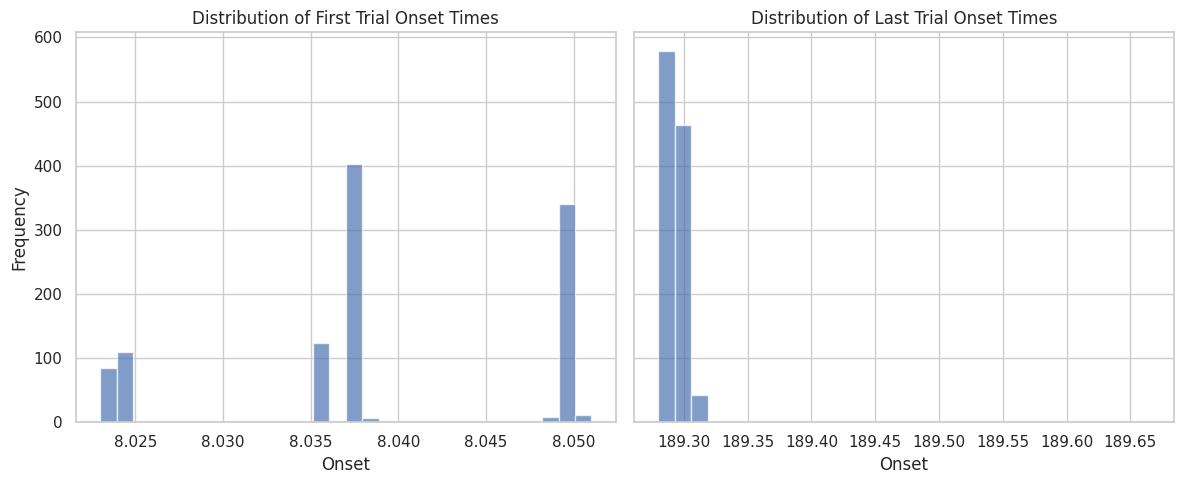

In [62]:
onset_times = motor_df.groupby("subject")["onset"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Onset Times")
axes[0].set_xlabel("Onset")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Onset Times")
axes[1].set_xlabel("Onset")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstonsets.png", dpi=300, bbox_inches='tight')

plt.show()

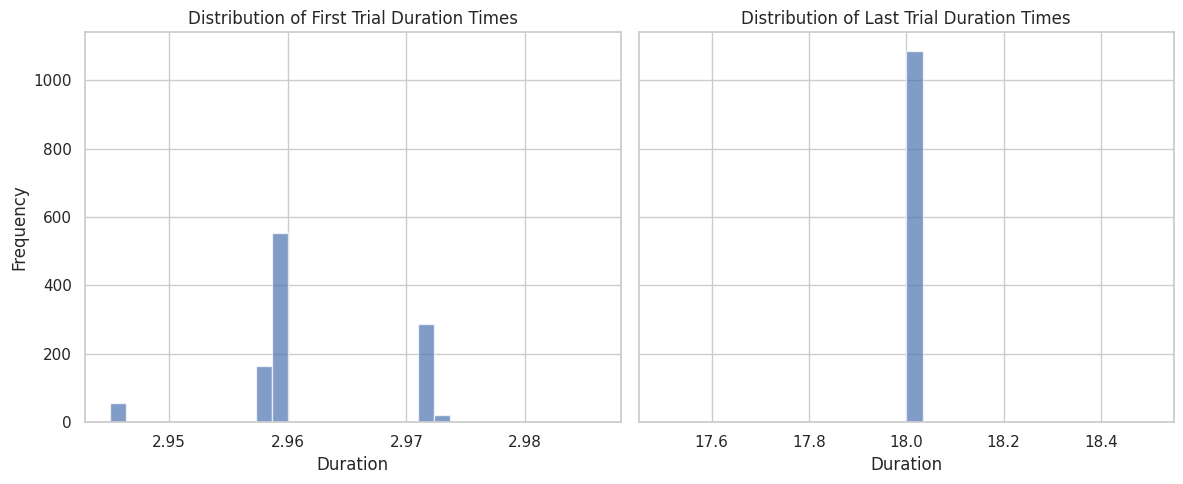

In [63]:
onset_times = motor_df.groupby("subject")["duration"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Duration Times")
axes[0].set_xlabel("Duration")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Duration Times")
axes[1].set_xlabel("Duration")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstdurations.png", dpi=300, bbox_inches='tight')

plt.show()

### Distribution of Durations

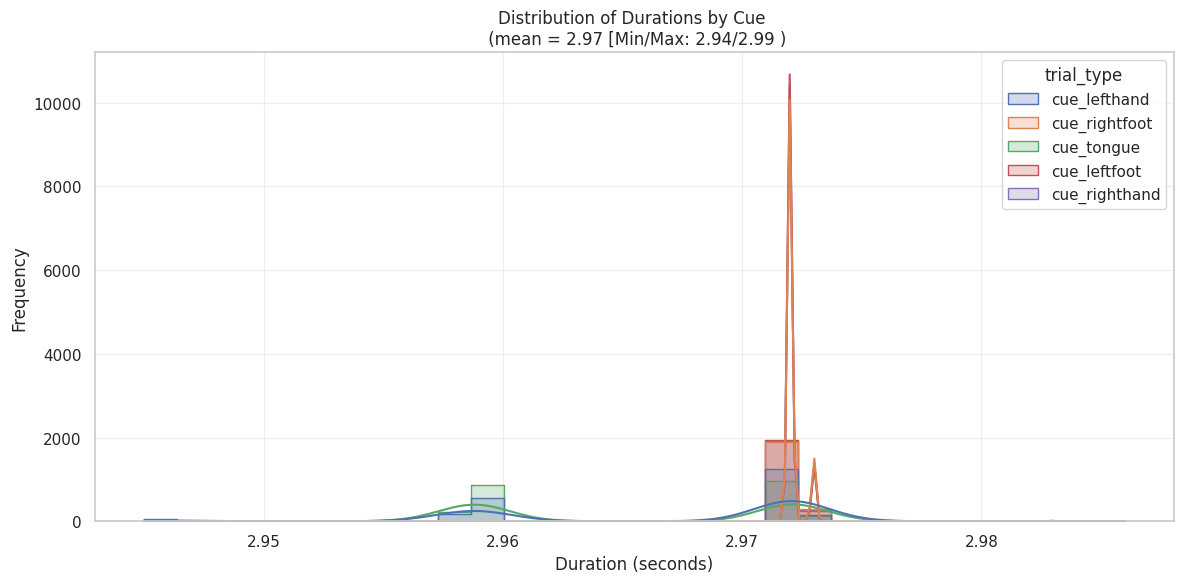

In [64]:
cue_dur = motor_df[motor_df['trial_type'].str.contains('cue', case=False)]

duration_mean = np.round(cue_dur['duration'].mean(),2)
duration_min = np.round(cue_dur['duration'].min(),2)
duration_max = np.round(cue_dur['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=cue_dur, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations by Cue \n (mean = {duration_mean} [Min/Max: {duration_min}/{duration_max} )")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-cuedurations.png", dpi=300, bbox_inches='tight')

plt.show()

Fixation is constant of 18, as trial-by-trial hovers near this and does not vary. Calculating unique across blocks added unnecessary risks of erros.

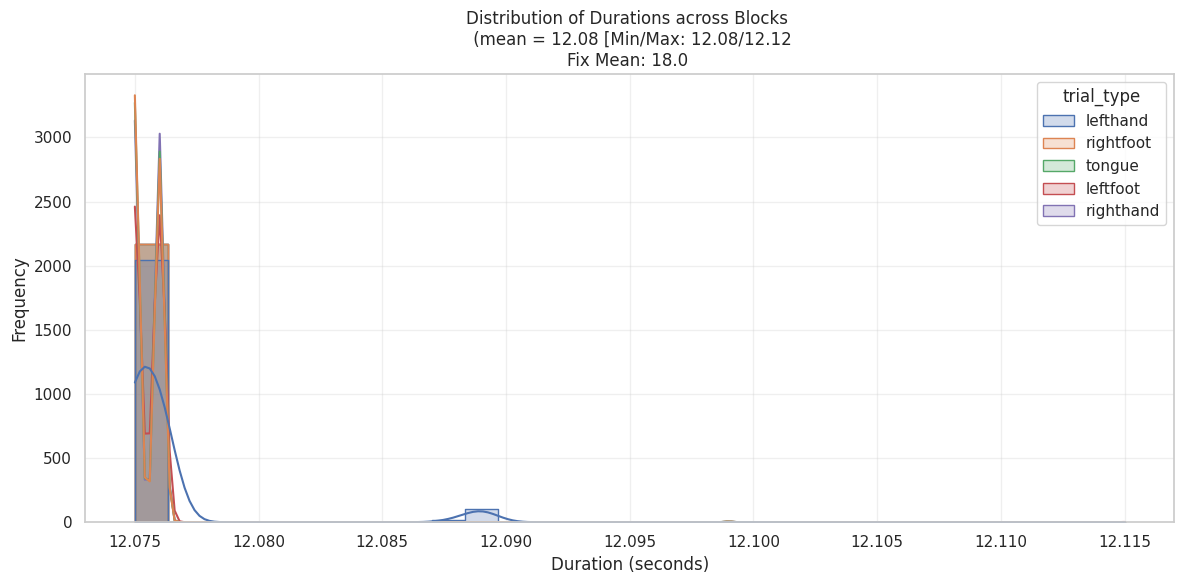

In [65]:
fixdur = motor_df[motor_df['trial_type'].str.contains('fixation', case=False, na=False)]
fixdur_mean = np.round(fixdur['duration'].mean(),2)

blocks = motor_df[
    motor_df['trial_type'].str.contains('lefthand|righthand|rightfoot|leftfoot|tongue', case=False, na=False) & 
    ~motor_df['trial_type'].str.contains('cue', case=False, na=False)
]

duration_mean = np.round(blocks['duration'].mean(),2)
duration_min = np.round(blocks['duration'].min(),2)
duration_max = np.round(blocks['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=blocks, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations across Blocks \n (mean = {duration_mean} [Min/Max: {duration_min}/{duration_max}\nFix Mean: {fixdur_mean} ")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-moveblockdurations.png", dpi=300, bbox_inches='tight')

plt.show()

## Social

The [Barch et al. (2013, pg 178)](https://www.sciencedirect.com/science/article/pii/S1053811913005272) highlights the Social Task as:


"Social cognition (theory of mind). An engaging and validated video task was chosen as a measure of social cognition, given evidence that it generates robust task related activation in brain regions associated with social cognition and is reliable across subjects (Castelli et al., 2000, 2002; Wheatley et al., 2007; White et al., 2011). The participants are presented with short video clips (20 s) of objects (squares, circles, triangles) either interacting in some way, or moving randomly. These videos were developed by either Castelli et al. (2000) or Wheatley et al. (2007). After each video clip, the participants chose between 3 possibilities: whether the objects had a social interaction (an interaction that appears as if the shapes are taking into account each other's feelings and thoughts), Not Sure, or No interaction (i.e., there is no obvious interaction between the shapes and the  movement appears in random). Each of the two task runs has 5 video blocks (2 Mental and 3 Random in one run, 3 Mental and 2 Random in the other run) and 5 fixation blocks (15 s each). Of note, the video clips were shortened to 20 s (the Castelli et al. clips were originally 40 s) by either splitting the videos in two or truncating them. We conducted a pilot study in Phase I in which the participants made ratings about the presence or absence of mental interactions in the videos to confirm that the shorter videos elicited similar responses to the longer videos."

In [69]:
task = 'social'
run = 'run1'

files = sorted(Path(events_folder).rglob(f"sub-*_ses-3T_task-{task}_dir-*_{run}_events.tsv"))
combined = []
for sub_file in files:
    subject = sub_file.parts[-4]    
    out = pd.read_csv(sub_file, sep='\t')
    combined.append((subject, out))  # Append tuple of subject ID and processed dataframe
social_df = pd.concat([df.assign(subject=subject) for subject, df in combined], ignore_index=True)
print("Rows in final Df:", len(social_df), "for unique subjects:", len(social_df['subject'].unique()))

Rows in final Df: 20940 for unique subjects: 1047


### Distribution First/Last timing

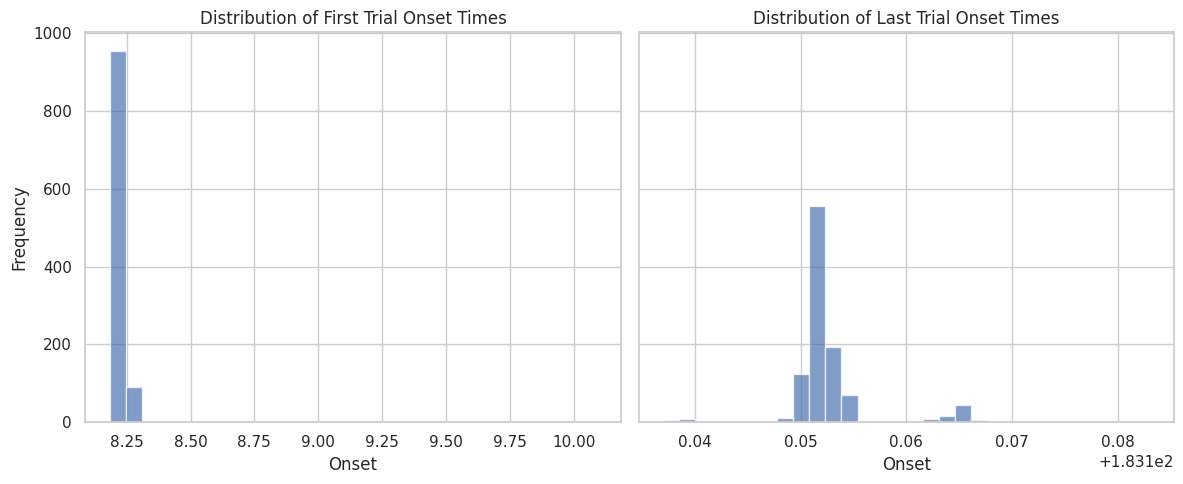

In [72]:
onset_times = social_df.groupby("subject")["onset"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Onset Times")
axes[0].set_xlabel("Onset")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Onset Times")
axes[1].set_xlabel("Onset")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstonsets.png", dpi=300, bbox_inches='tight')
plt.show()

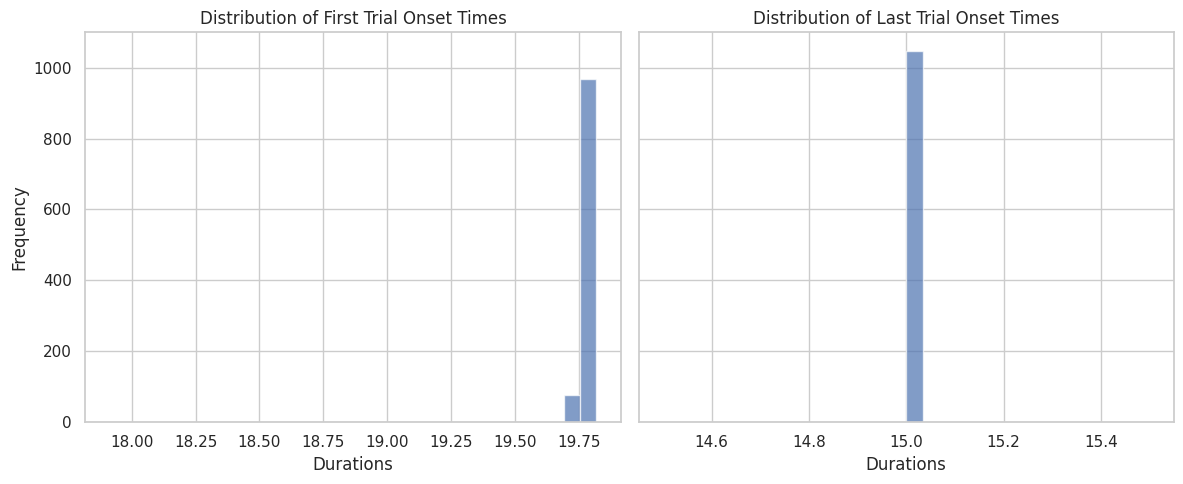

In [75]:
onset_times = social_df.groupby("subject")["duration"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Onset Times")
axes[0].set_xlabel("Durations")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Onset Times")
axes[1].set_xlabel("Durations")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstduration.png", dpi=300, bbox_inches='tight')
plt.show()

### Distribution of Durations

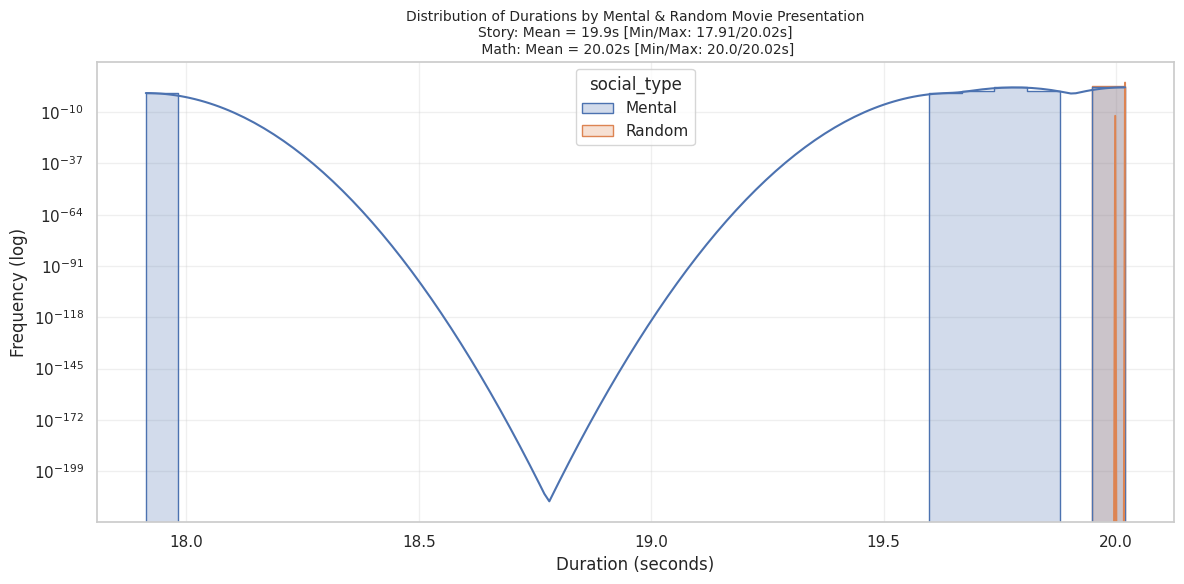

In [76]:
presentation = social_df[social_df['trial_type'].str.contains('movie', case=False, na=False)]

# Compute summary statistics for each trial_type
stats = presentation.groupby('social_type')['duration'].agg(['mean', 'min', 'max']).round(2)

# Extract values
mental_mean, mental_min, mental_max = stats.loc['Mental']
rand_mean, rand_min, rand_max = stats.loc['Random']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=presentation, 
    x='duration', 
    hue='social_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations by Mental & Random Movie Presentation\n"
    f"Story: Mean = {mental_mean}s [Min/Max: {mental_min}/{mental_max}s]\n "
    f"Math: Mean = {rand_mean}s [Min/Max: {rand_min}/{rand_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.yscale("log")  # Log scale to better see differences
plt.ylabel('Frequency (log)')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-presentationduration.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

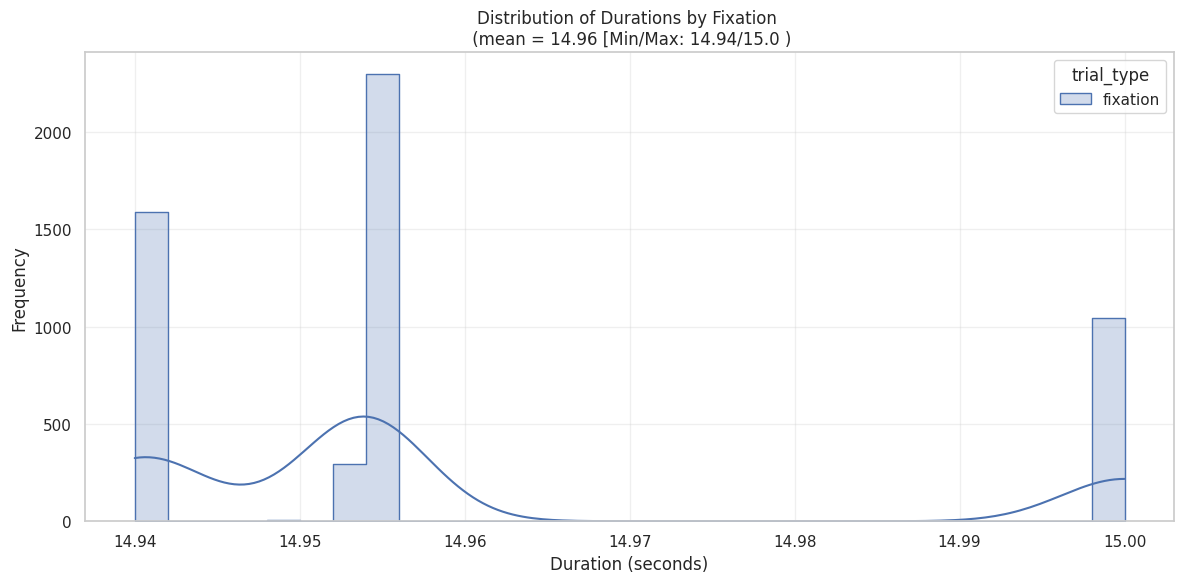

In [77]:
fixation = social_df[social_df['trial_type'].str.contains('fixation', case=False)]

duration_mean = np.round(fixation['duration'].mean(),2)
duration_min = np.round(fixation['duration'].min(),2)
duration_max = np.round(fixation['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=fixation, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations by Fixation \n (mean = {duration_mean} [Min/Max: {duration_min}/{duration_max} )")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fixationduration.png", dpi=300, bbox_inches='tight')

plt.show()

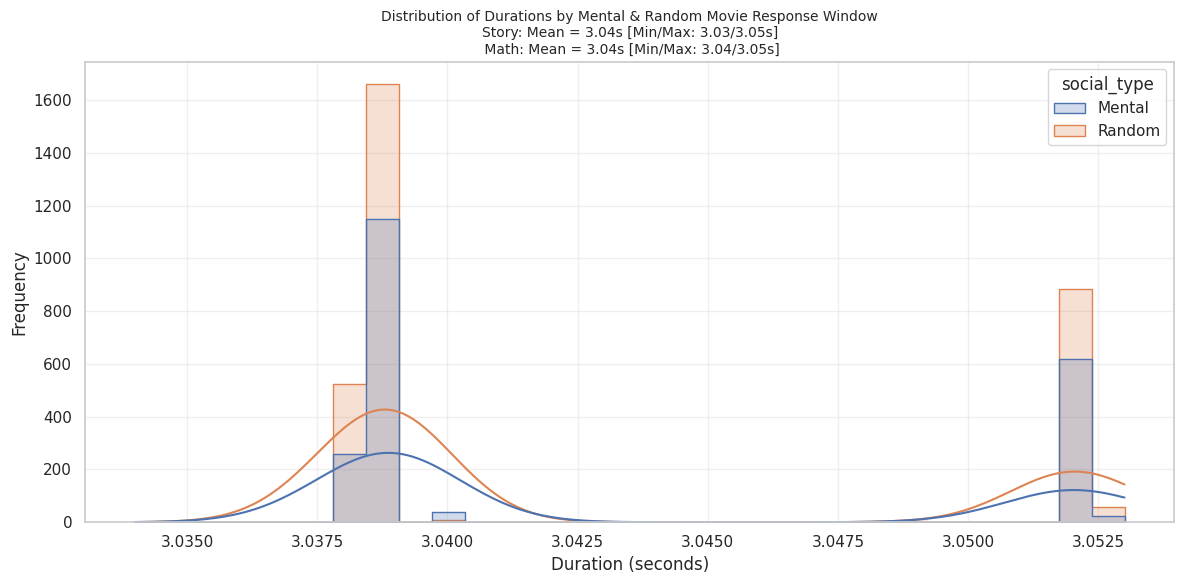

In [78]:
response = social_df[social_df['trial_type'].str.contains('response', case=False, na=False)]

# Compute summary statistics for each trial_type
stats = response.groupby('social_type')['duration'].agg(['mean', 'min', 'max']).round(2)

# Extract values
mental_mean, mental_min, mental_max = stats.loc['Mental']
rand_mean, rand_min, rand_max = stats.loc['Random']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=response, 
    x='duration', 
    hue='social_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations by Mental & Random Movie Response Window\n"
    f"Story: Mean = {mental_mean}s [Min/Max: {mental_min}/{mental_max}s]\n "
    f"Math: Mean = {rand_mean}s [Min/Max: {rand_min}/{rand_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-responseduration.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

### Response Times

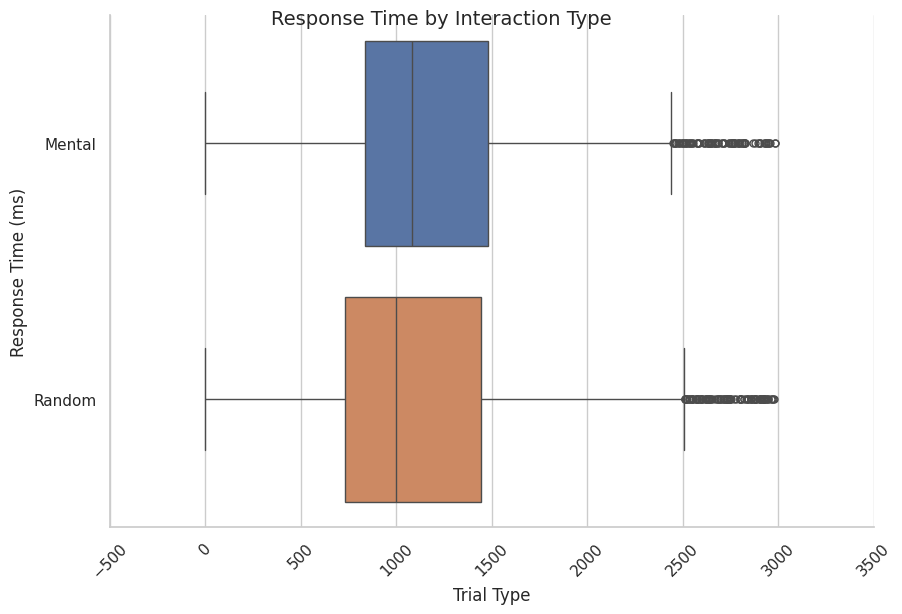

In [79]:
response_times = social_df[social_df['trial_type'].str.contains('response', case=False)]

# Create the plot with facets by stim_type
g = sns.catplot(data=response_times, x="response_time", y="social_type", hue="social_type", kind="box", height=6, aspect=1.5)

# Label the axes
g.set_axis_labels("Trial Type", "Response Time (ms)")

# Title for the entire plot
g.fig.suptitle("Response Time by Interaction Type", fontsize=14)

# Rotate x-axis labels if necessary
g.set_xticklabels(rotation=45)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-responsetimebyinteraction.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

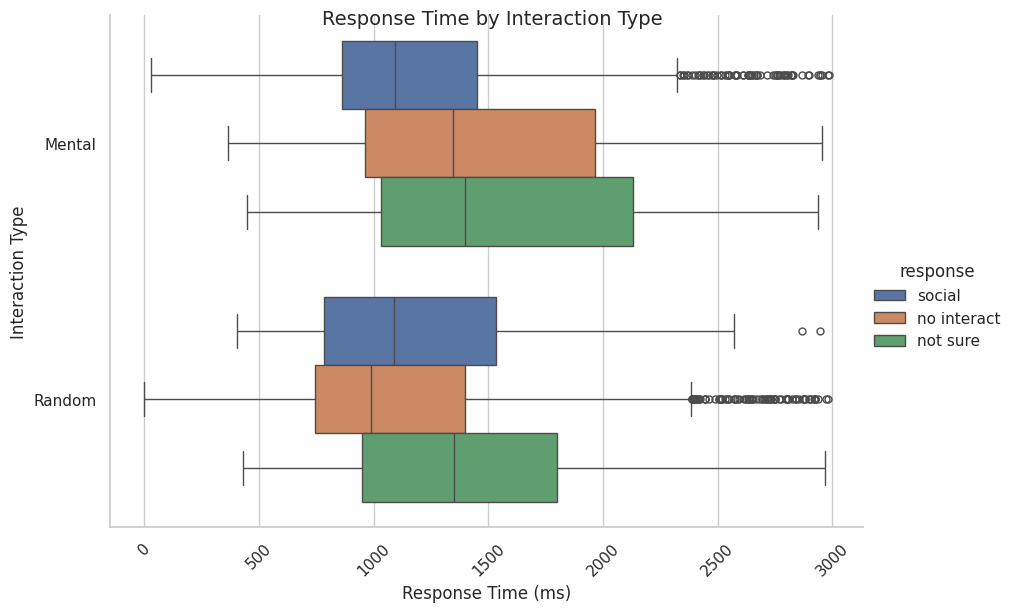

In [80]:
response_times = social_df[social_df['trial_type'].str.contains('response', case=False)].copy()

# **Recode Response Types**
response_mapping = {2: "social", 3: "not sure", 4: "no interact"}
response_times["response"] = response_times["response"].replace(response_mapping)

# Create the box plot
g = sns.catplot(
    data=response_times, 
    x="response_time", 
    y="social_type", 
    hue="response",  # Hue now reflects the relabeled response types
    kind="box", 
    height=6, 
    aspect=1.5
)

# Label axes
g.set_axis_labels("Response Time (ms)", "Interaction Type")

# Title for the plot
g.fig.suptitle("Response Time by Interaction Type", fontsize=14)

# Rotate x-axis labels
plt.xticks(rotation=45)

# Save the figure before plt.show()
g.savefig(f"{out_figs}/task-{task}_run-{run}_type-responsetimebyinteractresptype.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

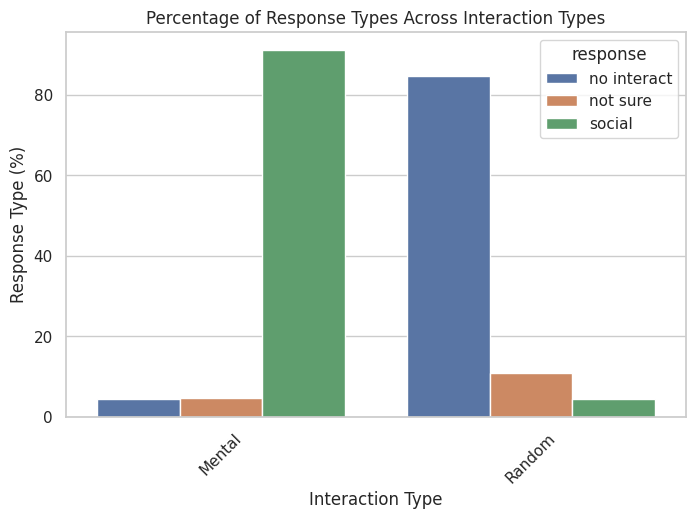

In [81]:
response_counts = response_times.groupby(["social_type", "response"]).size().reset_index(name="count")

# Normalize counts to percentages
response_counts["percent"] = response_counts.groupby("social_type")["count"].transform(lambda x: x / x.sum() * 100)

plt.figure(figsize=(8, 5))
sns.barplot(data=response_counts, x="social_type", y="percent", hue="response")
plt.xlabel("Interaction Type")
plt.ylabel("Response Type (%)")
plt.title("Percentage of Response Types Across Interaction Types")
plt.xticks(rotation=45)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-responsetypeprop.png", dpi=300, bbox_inches='tight')

plt.show()

## Relational

The [Barch et al. (2013, pg 178)](https://www.sciencedirect.com/science/article/pii/S1053811913005272) highlights the Social Task as:


"Relational processing. This task was adapted from the one developed by Smith et al. (2007) which was demonstrated to localize activation in anterior prefrontal cortex in individual subjects. The stimuli are 6 different shapes filled with 1 of 6 different textures. In the relational processing condition, the participants are presented with 2 pairs of objects, with one pair at the top of the screen and the other pair at the bottom of the screen. They are told that they should first decide what dimension differs across the top pair of objects (shape or texture) and then they should decide whether the bottom pair of objects also differs along that same dimension (e.g., if the top pair differs in shape, does the bottom pair also differ in shape). In the control matching condition, the participants are shown two objects at the top of the screen and one object at the bottom of the screen, and a word in the middle of the screen (either “shape” or “texture”). They are told to decide whether the bottom object matches either of the top two objects on that dimension (e.g., if the word is “shape”, is the bottom object the same shape as either of the top two objects). For the relational condition, the stimuli are presented for 3500 ms, with a 500 ms ITI, with four trials per block. In the matching condition, stimuli are presented for 2800 ms, with a 400 ms ITI, with 5 trials per block. Each type of block (relational or matching) lasts a total of 18 s. In each of the two runs of this task, there are 3 relational blocks, 3 matching blocks and three 16 s fixation blocks (see Table 4)."

In [95]:
task = 'relational'
run = 'run1'

files = sorted(Path(events_folder).rglob(f"sub-*_ses-3T_task-{task}_dir-*_{run}_events.tsv"))
combined = []
for sub_file in files:
    subject = sub_file.parts[-4]    
    out = pd.read_csv(sub_file, sep='\t')
    combined.append((subject, out))  # Append tuple of subject ID and processed dataframe
rel_df = pd.concat([df.assign(subject=subject) for subject, df in combined], ignore_index=True)
print("Rows in final Df:", len(rel_df), "for unique subjects:", len(rel_df['subject'].unique()))

Rows in final Df: 62583 for unique subjects: 907


### Distribution of First/Last Onset Time

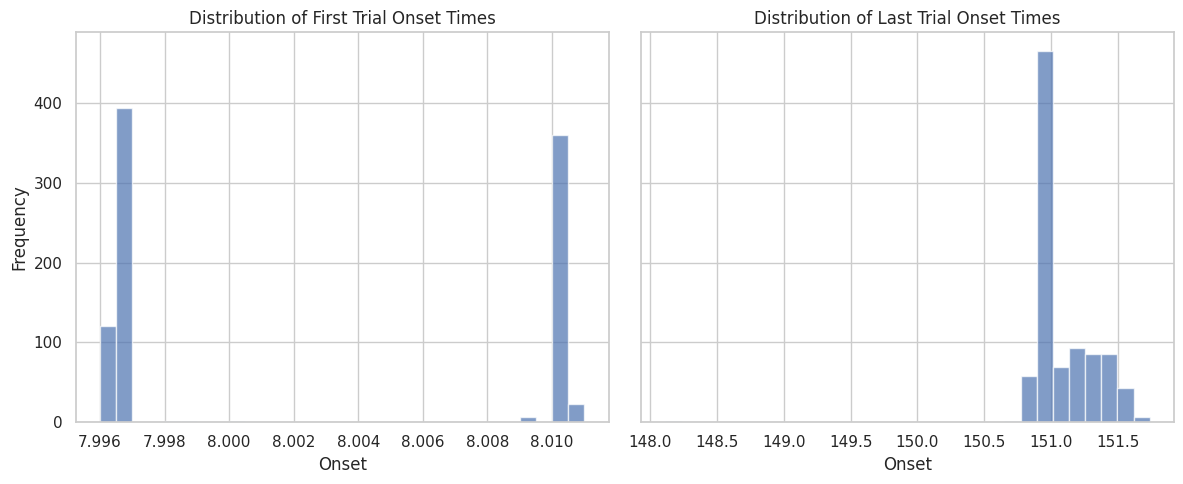

In [96]:
onset_times = rel_df.groupby("subject")["onset"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Onset Times")
axes[0].set_xlabel("Onset")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Onset Times")
axes[1].set_xlabel("Onset")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstonset.png", dpi=300, bbox_inches='tight')

plt.show()

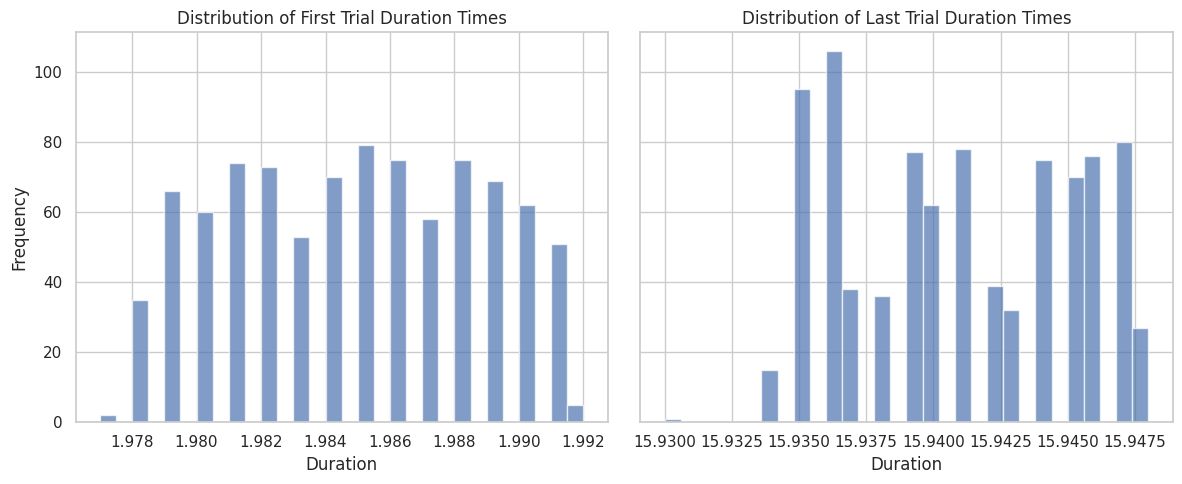

In [97]:
onset_times = rel_df.groupby("subject")["duration"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Duration Times")
axes[0].set_xlabel("Duration")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Duration Times")
axes[1].set_xlabel("Duration")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstduration.png", dpi=300, bbox_inches='tight')

plt.show()

### Distribution of Durations

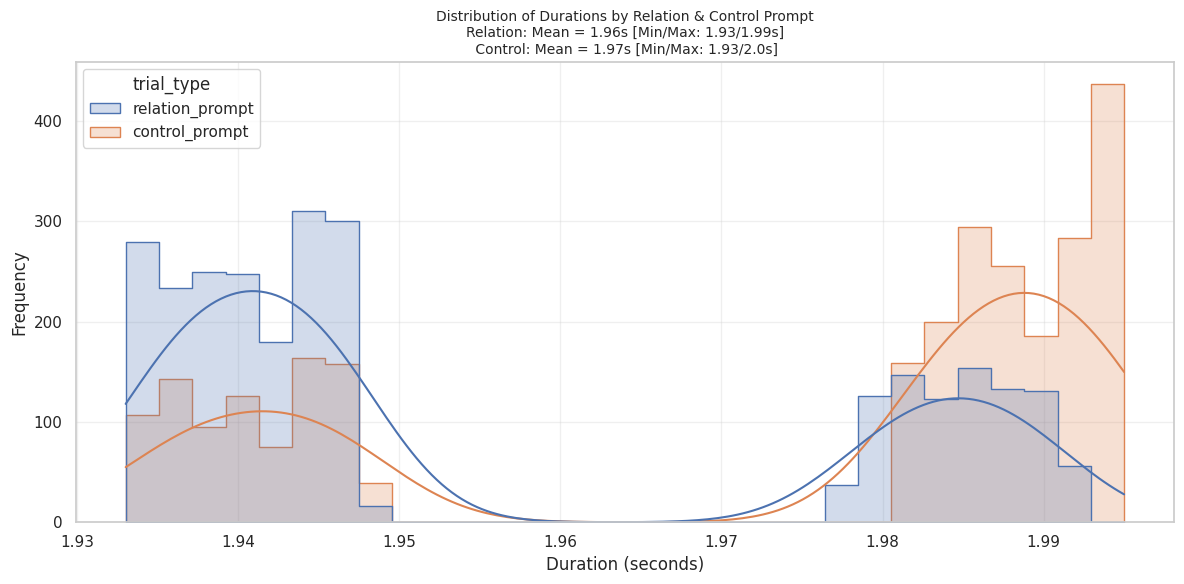

In [98]:
prompt_pres = rel_df[rel_df['trial_type'].str.contains('relation_prompt|control_prompt', case=False, na=False)]

# Compute summary statistics for each trial_type
stats = prompt_pres.groupby('trial_type')['duration'].agg(['mean', 'min', 'max']).round(2)

# Extract values
a_mean, a_min, a_max = stats.loc['relation_prompt']
b_mean, b_min, b_max = stats.loc['control_prompt']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=prompt_pres, 
    x='duration', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations by Relation & Control Prompt\n"
    f"Relation: Mean = {a_mean}s [Min/Max: {a_min}/{a_max}s]\n "
    f"Control: Mean = {b_mean}s [Min/Max: {b_min}/{b_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-promptduration.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

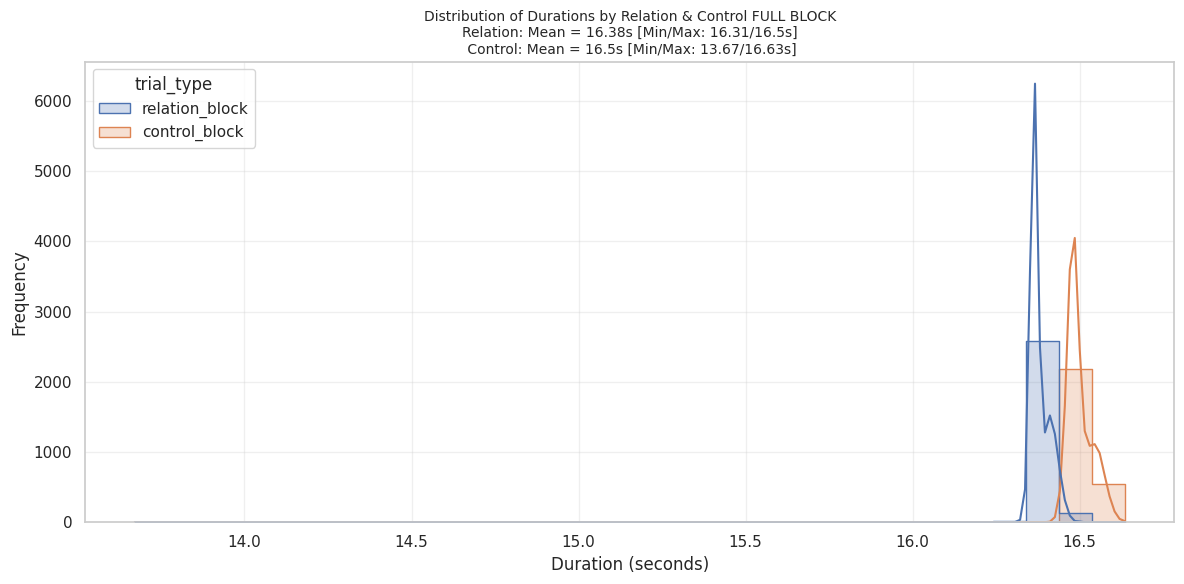

In [99]:
prompt_block = rel_df[rel_df['trial_type'].str.contains('relation_block|control_block', case=False, na=False)]

# Compute summary statistics for each trial_type
stats = prompt_block.groupby('trial_type')['duration'].agg(['mean', 'min', 'max']).round(2)

# Extract values
a_mean, a_min, a_max = stats.loc['relation_block']
b_mean, b_min, b_max = stats.loc['control_block']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=prompt_block, 
    x='duration', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations by Relation & Control FULL BLOCK\n"
    f"Relation: Mean = {a_mean}s [Min/Max: {a_min}/{a_max}s]\n "
    f"Control: Mean = {b_mean}s [Min/Max: {b_min}/{b_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fullblockduration.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

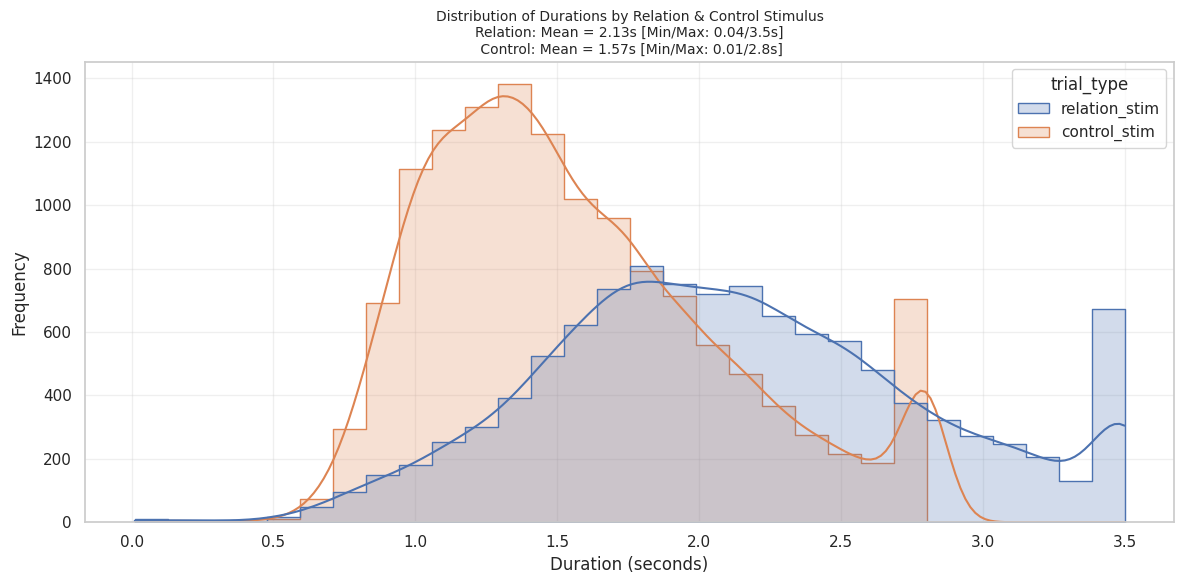

In [100]:
prompt_stim = rel_df[rel_df['trial_type'].str.contains('relation_stim|control_stim', case=False, na=False)]

# Compute summary statistics for each trial_type
stats = prompt_stim.groupby('trial_type')['duration'].agg(['mean', 'min', 'max']).round(2)

# Extract values
a_mean, a_min, a_max = stats.loc['relation_stim']
b_mean, b_min, b_max = stats.loc['control_stim']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=prompt_stim, 
    x='duration', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations by Relation & Control Stimulus\n"
    f"Relation: Mean = {a_mean}s [Min/Max: {a_min}/{a_max}s]\n "
    f"Control: Mean = {b_mean}s [Min/Max: {b_min}/{b_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-stimulusduration.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

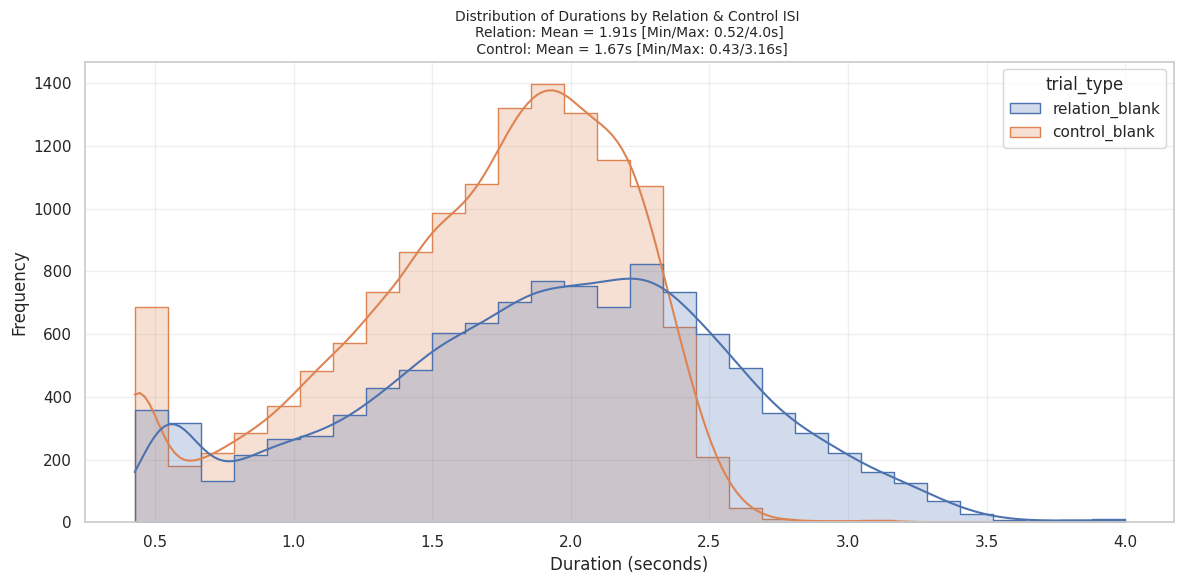

In [101]:
prompt_isi = rel_df[rel_df['trial_type'].str.contains('relation_blank|control_blank', case=False, na=False)]

# Compute summary statistics for each trial_type
stats = prompt_isi.groupby('trial_type')['duration'].agg(['mean', 'min', 'max']).round(2)

# Extract values
a_mean, a_min, a_max = stats.loc['relation_blank']
b_mean, b_min, b_max = stats.loc['control_blank']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=prompt_isi, 
    x='duration', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations by Relation & Control ISI \n"
    f"Relation: Mean = {a_mean}s [Min/Max: {a_min}/{a_max}s]\n "
    f"Control: Mean = {b_mean}s [Min/Max: {b_min}/{b_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-isiduration.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

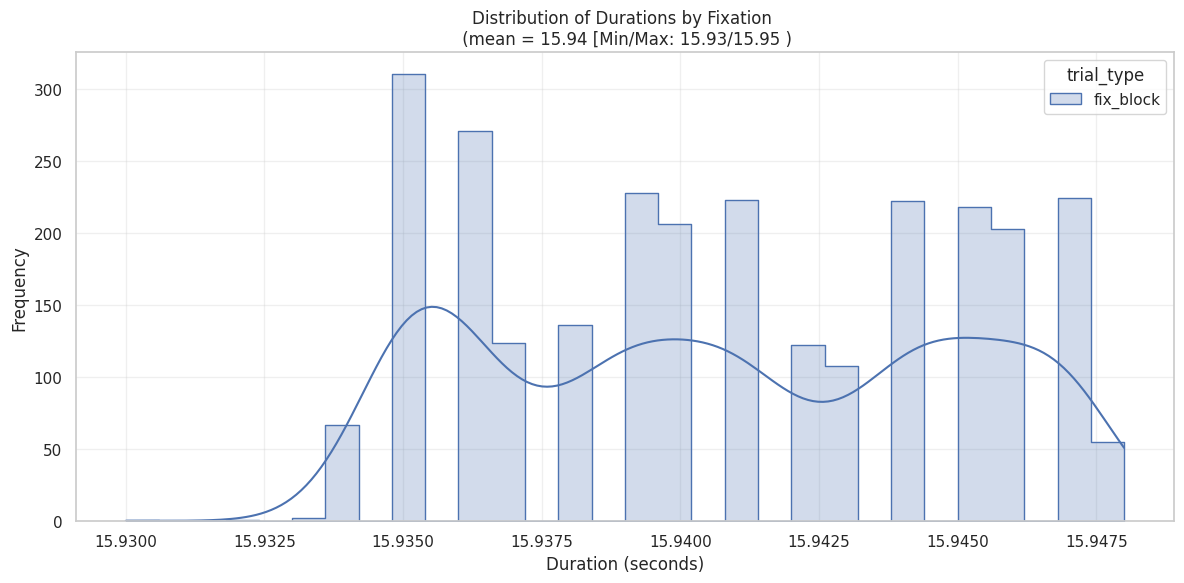

In [102]:
fixation = rel_df[rel_df['trial_type'].str.contains('fix', case=False)]

duration_mean = np.round(fixation['duration'].mean(),2)
duration_min = np.round(fixation['duration'].min(),2)
duration_max = np.round(fixation['duration'].max(),2)

plt.figure(figsize=(12, 6))
sns.histplot(data=fixation, x='duration', hue='trial_type', kde=True, element='step',
             bins=30)  # Adjust the number of bins
plt.title(f"Distribution of Durations by Fixation \n (mean = {duration_mean} [Min/Max: {duration_min}/{duration_max} )")
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fixationduration.png", dpi=300, bbox_inches='tight')

plt.show()

### Response Times

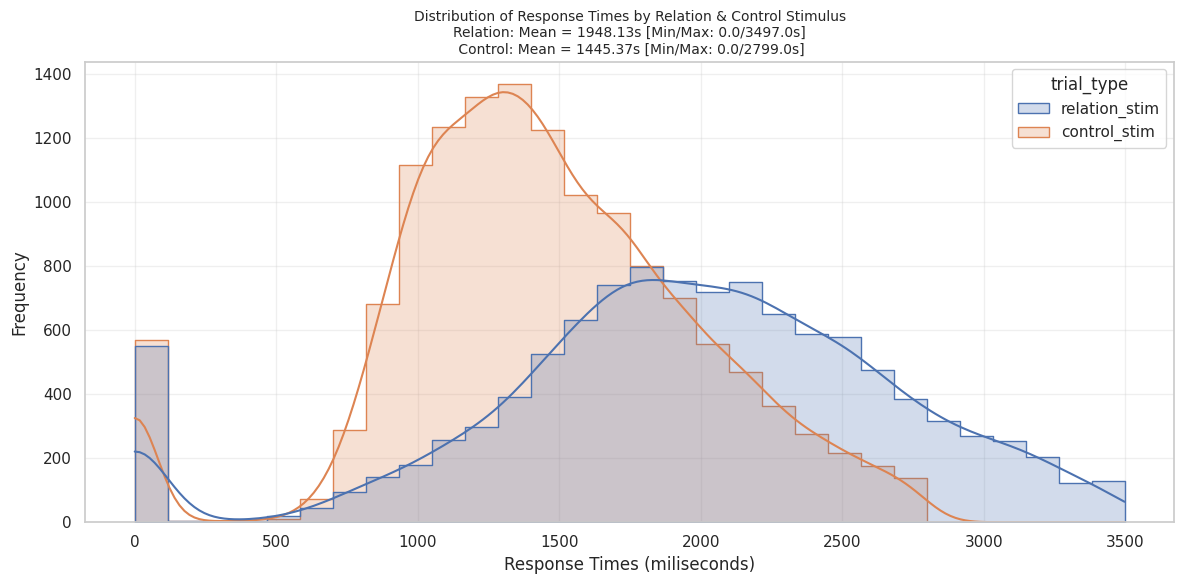

In [103]:
stim_response = rel_df[rel_df['trial_type'].str.contains('relation_stim|control_stim', case=False, na=False)]

# Compute summary statistics for each trial_type
stats = stim_response.groupby('trial_type')['response_time'].agg(['mean', 'min', 'max']).round(2)

# Extract values
a_mean, a_min, a_max = stats.loc['relation_stim']
b_mean, b_min, b_max = stats.loc['control_stim']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=stim_response, 
    x='response_time', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Response Times by Relation & Control Stimulus\n"
    f"Relation: Mean = {a_mean}s [Min/Max: {a_min}/{a_max}s]\n "
    f"Control: Mean = {b_mean}s [Min/Max: {b_min}/{b_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Response Times (miliseconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-responsetimestimulus.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

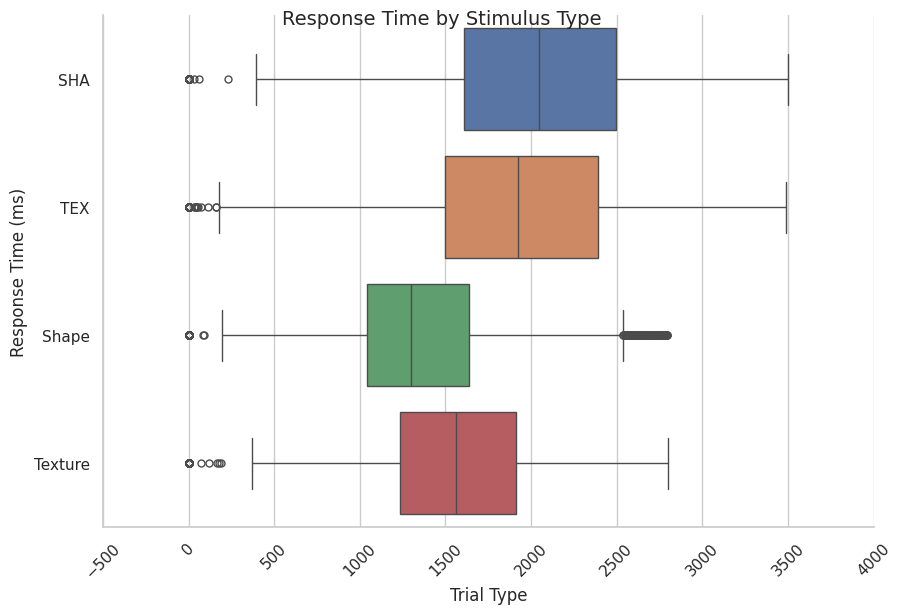

In [104]:
response_times = rel_df[rel_df['trial_type'].str.contains('stim', case=False)]

# Create the plot with facets by stim_type
g = sns.catplot(data=response_times, x="response_time", y="stim_type", hue="stim_type", kind="box", height=6, aspect=1.5)

# Label the axes
g.set_axis_labels("Trial Type", "Response Time (ms)")

# Title for the entire plot
g.fig.suptitle("Response Time by Stimulus Type", fontsize=14)

# Rotate x-axis labels if necessary
g.set_xticklabels(rotation=45)

plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-histresponsetimetype.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

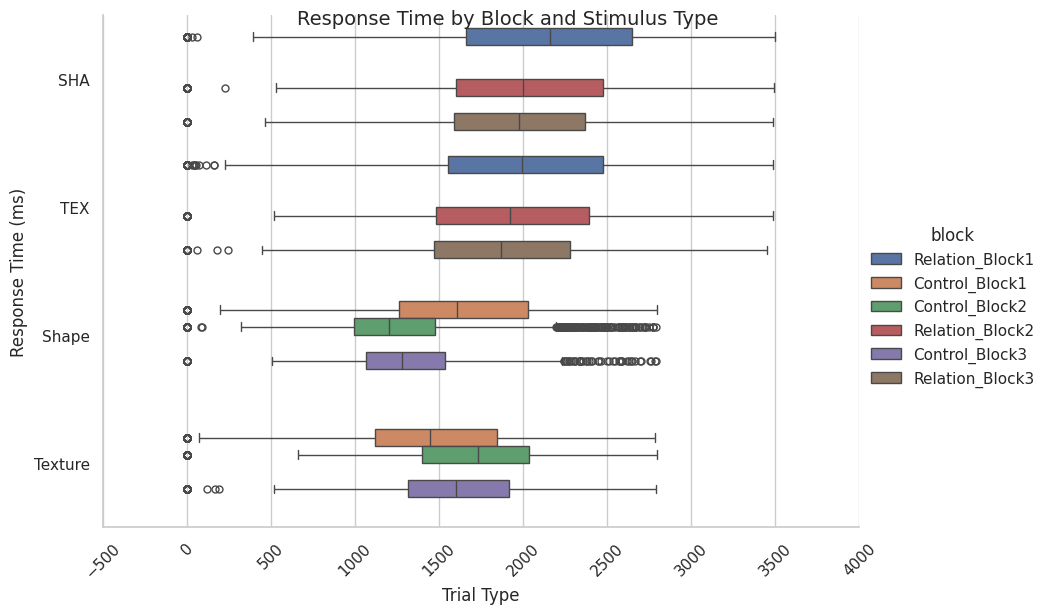

In [105]:
response_times = rel_df[rel_df['trial_type'].str.contains('stim', case=False)]

# Create the plot with facets by stim_type
g = sns.catplot(data=response_times, x="response_time", y="stim_type", hue="block", kind="box", height=6, aspect=1.5)

# Label the axes
g.set_axis_labels("Trial Type", "Response Time (ms)")

# Title for the entire plot
g.fig.suptitle("Response Time by Block and Stimulus Type", fontsize=14)

# Rotate x-axis labels if necessary
g.set_xticklabels(rotation=45)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-histresponsetimetypeblock.png", dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

## Working Memory

The [Barch et al. (2013, pg 178)](https://www.sciencedirect.com/science/article/pii/S1053811913005272) highlights the Working Memory Task as:


"Recognition memory. After the participants exit the scanner from the session that includes the Working Memory tasks, they are given a “Remember, Know, New” item recognition test for the faces and places presented during the working memory task, as well as an equal number of new faces and places similar on visual characteristics (e.g., an equal number of old and new stimuli came from the same stimuli sets). We did not include body parts or tools as we did not have a sufficient number of unique stimuli to serve as “new” items. Responses to this recognition memory test can be used to segregate events to analyze the working memory trials as a function of whether the item was subsequently recognized (remember or know) or not (new), which is referred to as a subsequent memory analysis. Each item is presented for 2 s. There is then a 2 s ITI before the next stimulus. There are 48 old and 48 new stimuli (1/2 of each stimulus type). Please see the Supplemental materials for exact instructions. Data from this subsequent memory analysis will be presented in a future publication."

In [82]:
task = 'wm'
run = 'run1'

files = sorted(Path(events_folder).rglob(f"sub-*_ses-3T_task-{task}_dir-*_{run}_events.tsv"))
combined = []
for sub_file in files:
    subject = sub_file.parts[-4]    
    out = pd.read_csv(sub_file, sep='\t')
    combined.append((subject, out))  # Append tuple of subject ID and processed dataframe
wm_df = pd.concat([df.assign(subject=subject) for subject, df in combined], ignore_index=True)
print("Rows in final Df:", len(wm_df), "for unique subjects:", len(wm_df['subject'].unique()))

Rows in final Df: 100700 for unique subjects: 1007


### Distribution of First/Last Onset Time

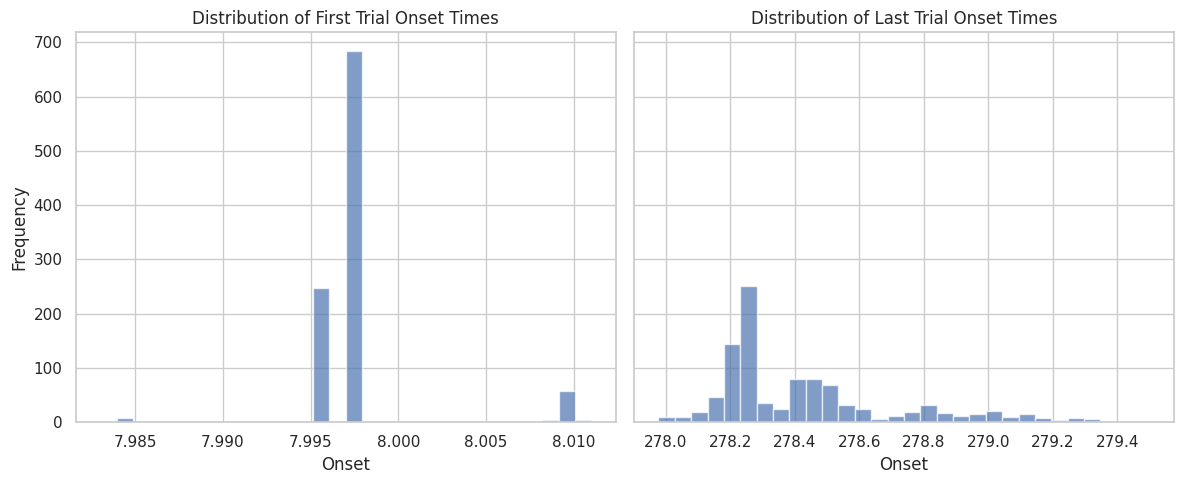

In [83]:
onset_times = wm_df.groupby("subject")["onset"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Onset Times")
axes[0].set_xlabel("Onset")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Onset Times")
axes[1].set_xlabel("Onset")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstonset.png", dpi=300, bbox_inches='tight')

plt.show()

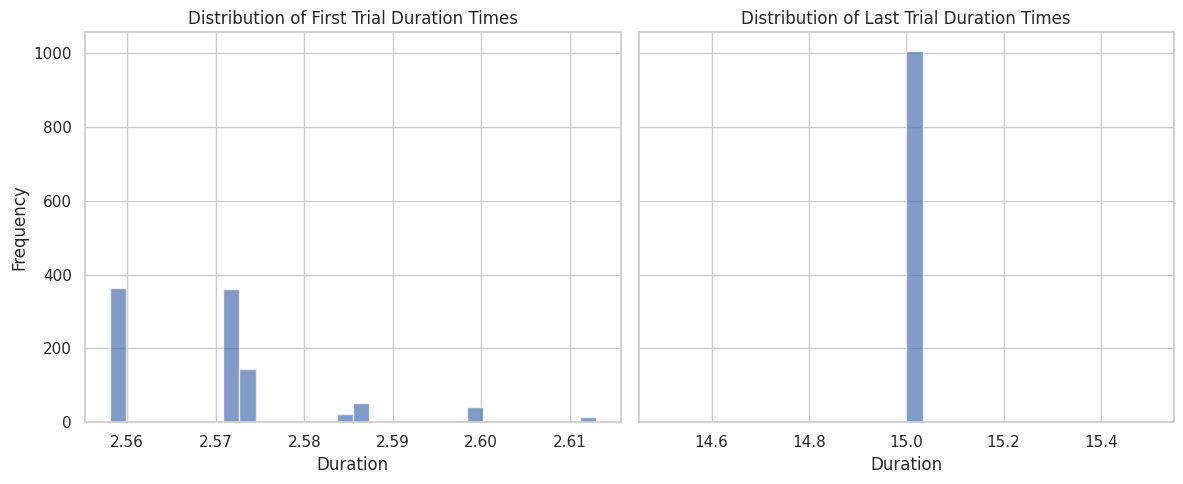

In [84]:
onset_times = wm_df.groupby("subject")["duration"].agg(["first", "last"])

# Plotting
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# First onset distribution
axes[0].hist(onset_times["first"], bins=30, alpha=0.7)
axes[0].set_title("Distribution of First Trial Duration Times")
axes[0].set_xlabel("Duration")
axes[0].set_ylabel("Frequency")

# Last onset distribution
axes[1].hist(onset_times["last"], bins=30, alpha=0.7)
axes[1].set_title("Distribution of Last Trial Duration Times")
axes[1].set_xlabel("Duration")

plt.tight_layout()
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fstlstduration.png", dpi=300, bbox_inches='tight')

plt.show()

### Distribution of Durations

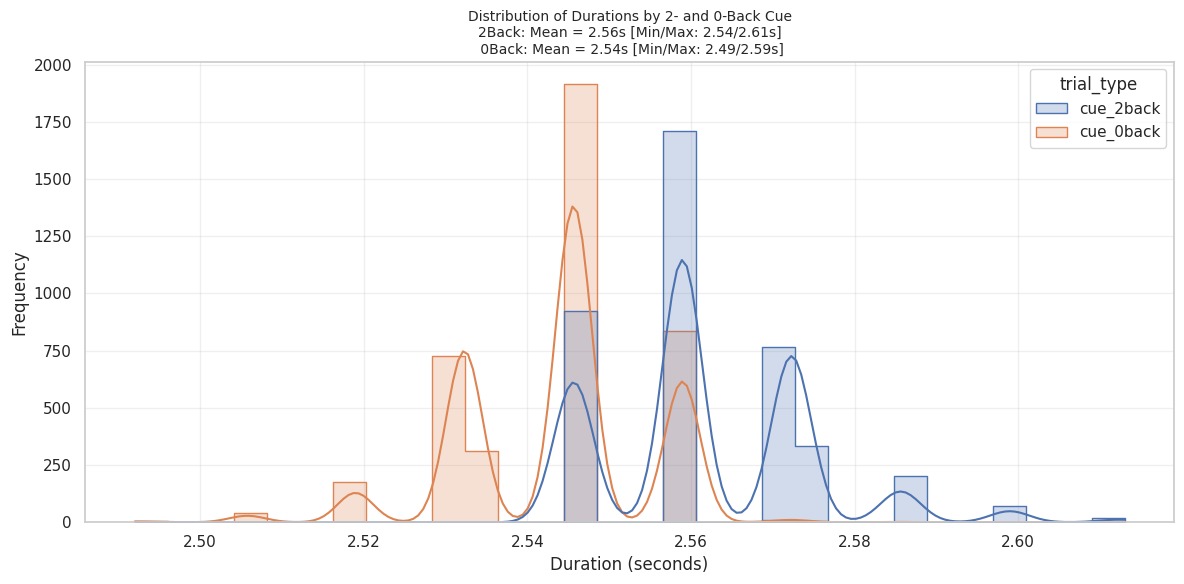

In [86]:
cueback = wm_df[wm_df['trial_type'].str.contains('cue_2back|cue_0back', case=False, na=False)]

# Compute summary statistics for each trial_type
stats = cueback.groupby('trial_type')['duration'].agg(['mean', 'min', 'max']).round(2)

# Extract values
a_mean, a_min, a_max = stats.loc['cue_2back']
b_mean, b_min, b_max = stats.loc['cue_0back']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=cueback, 
    x='duration', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations by 2- and 0-Back Cue\n"
    f"2Back: Mean = {a_mean}s [Min/Max: {a_min}/{a_max}s]\n "
    f"0Back: Mean = {b_mean}s [Min/Max: {b_min}/{b_max}s]", 
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-cuedurations.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

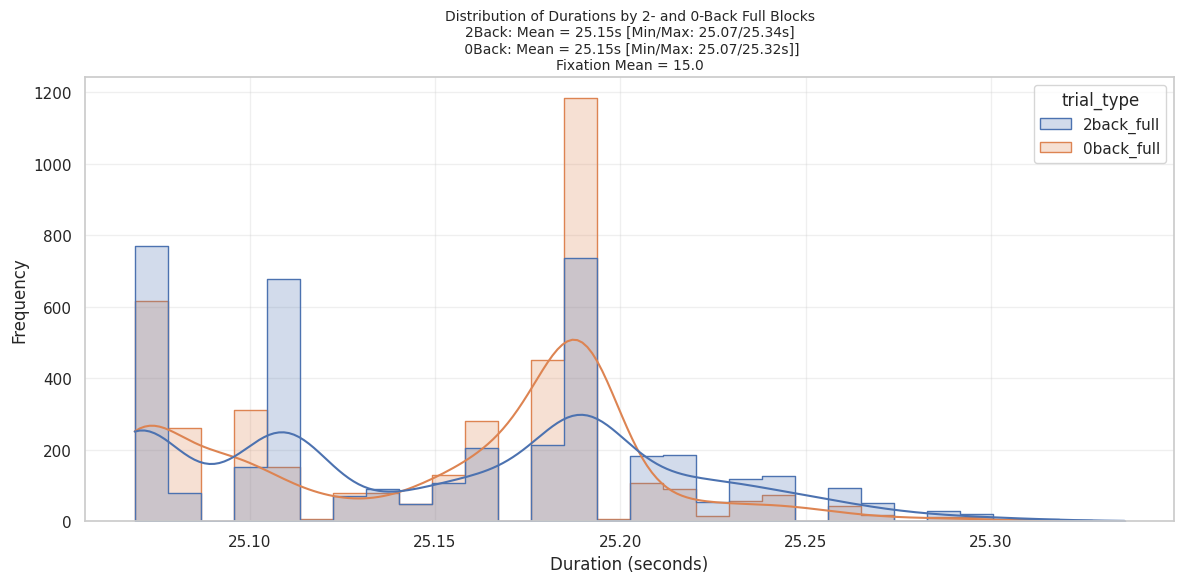

In [87]:
fullblocks = wm_df[wm_df['trial_type'].str.contains('2back_full|0back_full', case=False, na=False)]
fixblocks = wm_df[wm_df['trial_type'].str.contains('fixation', case=False, na=False)]
fix_dur = np.round(fixblocks['duration'].mean(),2)
# Compute summary statistics for each trial_type
stats = fullblocks.groupby('trial_type')['duration'].agg(['mean', 'min', 'max']).round(2)

# Extract values
a_mean, a_min, a_max = stats.loc['2back_full']
b_mean, b_min, b_max = stats.loc['0back_full']

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=fullblocks, 
    x='duration', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Durations by 2- and 0-Back Full Blocks\n"
    f"2Back: Mean = {a_mean}s [Min/Max: {a_min}/{a_max}s]\n "
    f"0Back: Mean = {b_mean}s [Min/Max: {b_min}/{b_max}s]]\n"
    f"Fixation Mean = {fix_dur}",
    fontsize=10
)

# Label axes
plt.xlabel('Duration (seconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-fullblockdurations.png", dpi=300, bbox_inches='tight')
plt.tight_layout()

### Response Times

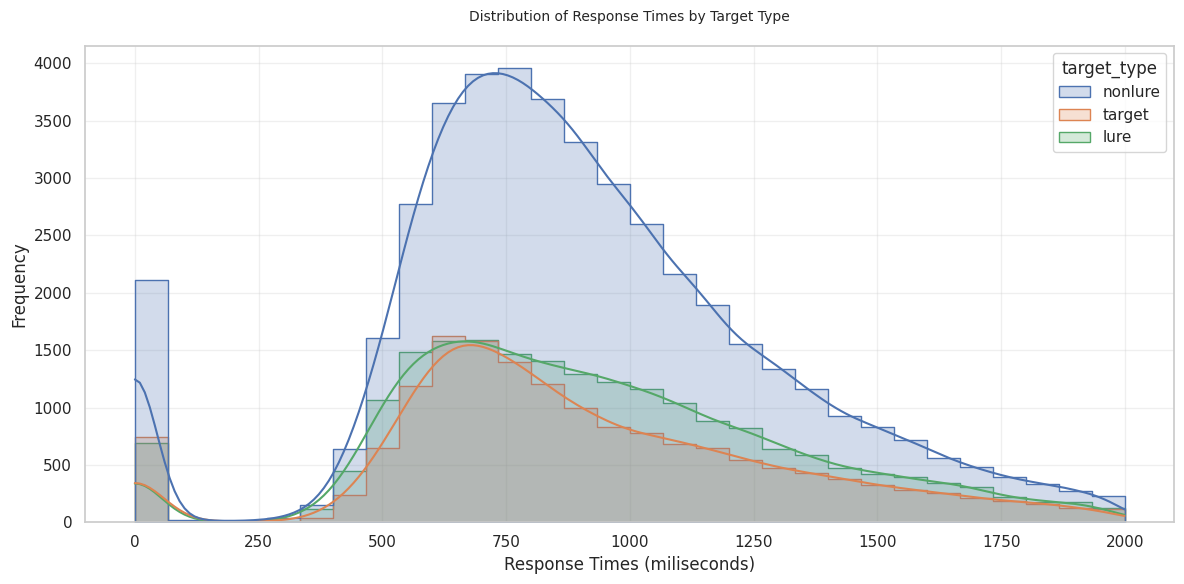

In [88]:
wmstim_response = wm_df[
    wm_df['trial_type'].str.contains('0back|2back', case=False, na=False) &  # Include '0back' or '2back'
    ~wm_df['trial_type'].str.contains('cue_|_full|fixation', case=False, na=False)  # Exclude these
]

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=wmstim_response, 
    x='response_time', 
    hue='target_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Response Times by Target Type\n",
    fontsize=10
)

# Label axes
plt.xlabel('Response Times (miliseconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-responsetimestarget.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

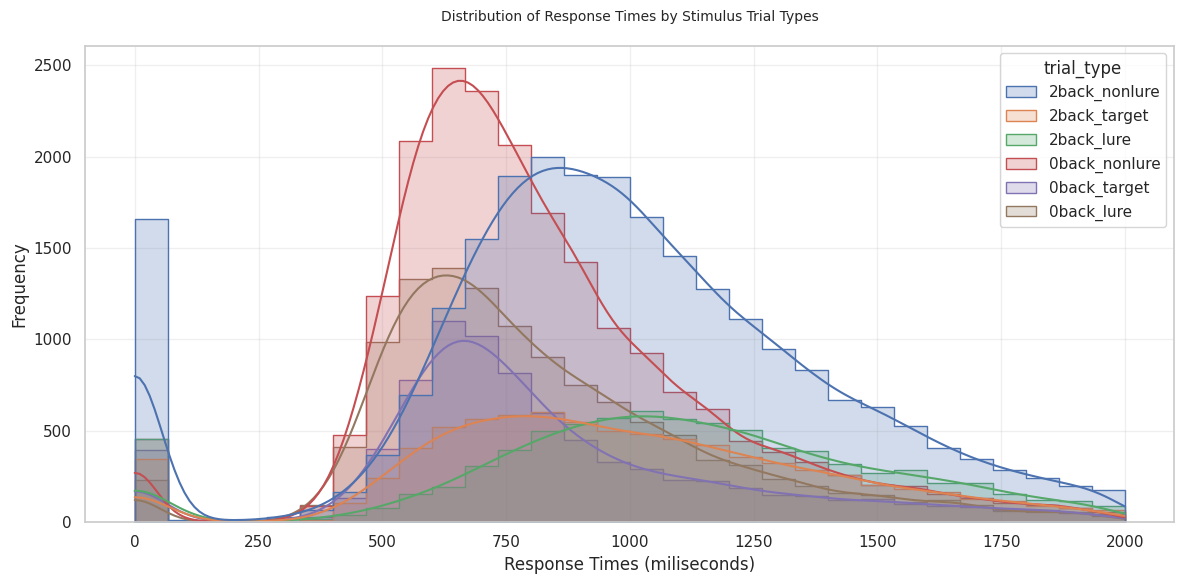

In [90]:
wmstim_response = wm_df[
    wm_df['trial_type'].str.contains('0back|2back', case=False, na=False) &  # Include '0back' or '2back'
    ~wm_df['trial_type'].str.contains('cue_|_full|fixation', case=False, na=False)  # Exclude these
]

# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=wmstim_response, 
    x='response_time', 
    hue='trial_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Response Times by Stimulus Trial Types\n",
    fontsize=10
)

# Label axes
plt.xlabel('Response Times (miliseconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-responsetimestargetnback.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

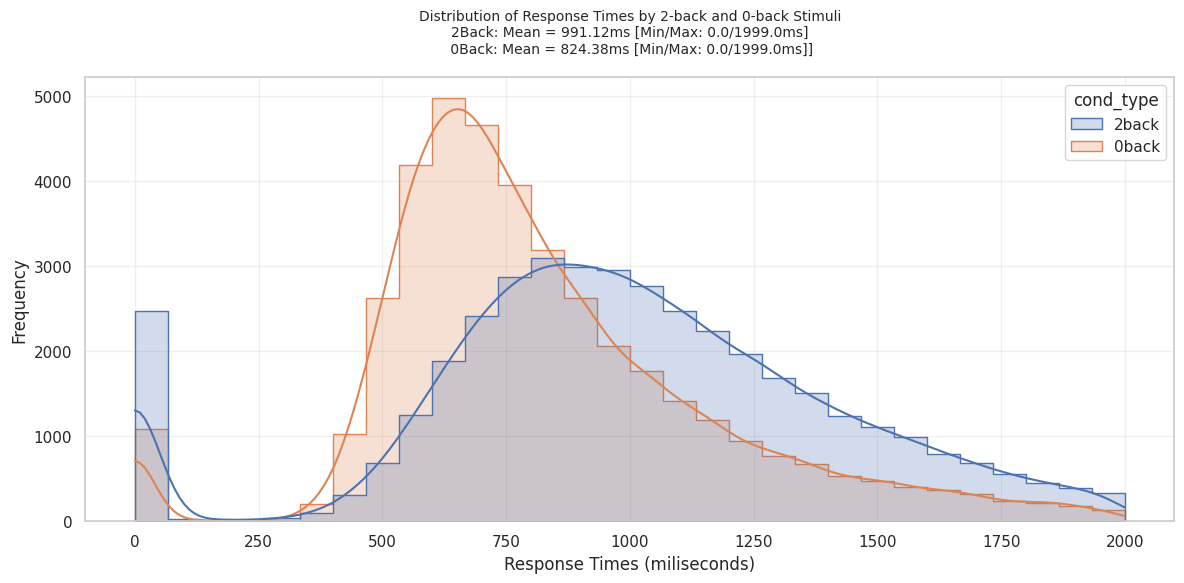

In [93]:
# Make a copy to avoid SettingWithCopyWarning
wmstim_response = wmstim_response.copy()

# Create cond_type column
wmstim_response.loc[:, 'cond_type'] = wmstim_response['trial_type'].apply(
    lambda x: '0back' if '0back' in x else ('2back' if '2back' in x else None)
)


# Compute summary statistics for each trial_type
stats = wmstim_response.groupby('cond_type')['response_time'].agg(['mean', 'min', 'max']).round(2)
# Extract values
a_mean, a_min, a_max = stats.loc['2back']
b_mean, b_min, b_max = stats.loc['0back']


# Create the histogram
plt.figure(figsize=(12, 6))
sns.histplot(
    data=wmstim_response, 
    x='response_time', 
    hue='cond_type', 
    kde=True, 
    element='step', 
    bins=30  # Adjust the number of bins
)

# Title with separate stats for each trial_type
plt.title(
    f"Distribution of Response Times by 2-back and 0-back Stimuli\n"
    f"2Back: Mean = {a_mean}ms [Min/Max: {a_min}/{a_max}ms]\n "
    f"0Back: Mean = {b_mean}ms [Min/Max: {b_min}/{b_max}ms]]\n",
    fontsize=10
)

# Label axes
plt.xlabel('Response Times (miliseconds)')
plt.ylabel('Frequency')
plt.grid(True, alpha=0.3)
plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-responsetimesnback.png", dpi=300, bbox_inches='tight')

plt.tight_layout()

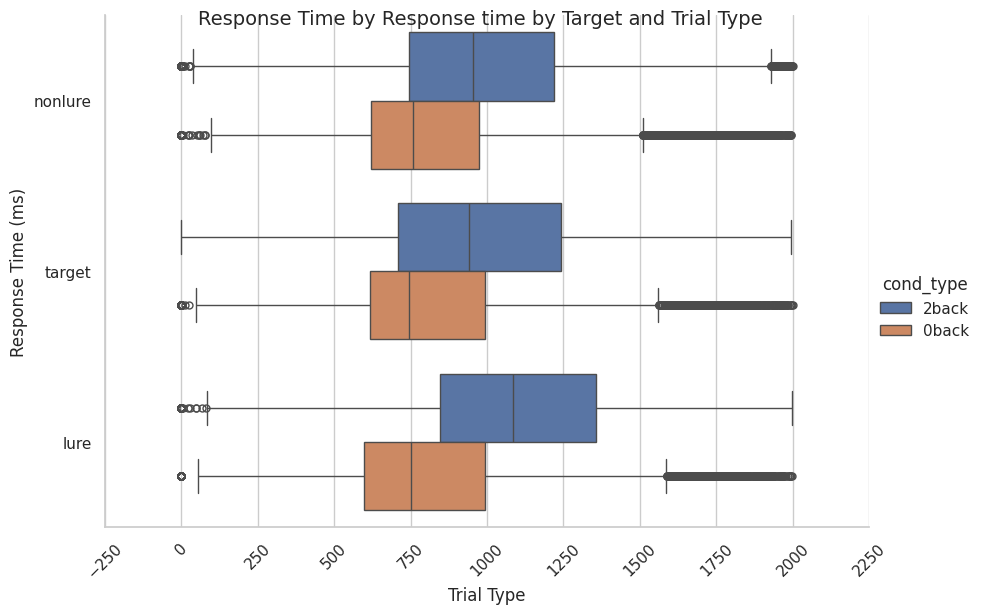

In [92]:
response_times = wmstim_response

# Create the plot with facets by stim_type
g = sns.catplot(data=response_times, x="response_time", y="target_type", hue="cond_type", kind="box", height=6, aspect=1.5)

# Label the axes
g.set_axis_labels("Trial Type", "Response Time (ms)")

# Title for the entire plot
g.fig.suptitle("Response Time by Response time by Target and Trial Type", fontsize=14)

# Rotate x-axis labels if necessary
g.set_xticklabels(rotation=45)

plt.savefig(f"{out_figs}/task-{task}_run-{run}_type-histresponsetimestarget.png", dpi=300, bbox_inches='tight')


# Show the plot
plt.show()